<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [2]:
from sklearn.metrics import roc_auc_score, roc_curve

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [4]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

In [5]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Посмотрим какой-то семпл из 5 строк:

In [6]:
train_data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
174,1,24.80,24.8,Female,0,Yes,No,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
290,71,100.45,7159.7,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,No,Yes,Two year,No,Electronic check,0
964,72,89.40,6376.55,Male,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Mailed check,0
1357,15,74.90,1107.25,Male,0,Yes,Yes,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),1
3565,33,50.00,1750.85,Male,1,Yes,No,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,No,Month-to-month,Yes,Electronic check,0


Выведем информацию о данных, обратим внимание на Non-Null Count и Dtype:

In [7]:
train_data.info()
# TotalSpent is object, not float64 (!)
# no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Видим, что у TotalSpent dtype, не соответствующий значениям, которые там лежат. Проверим эту фичу на пропуски:

In [8]:
np.unique(train_data.TotalSpent.values, return_counts=True) # 9 пропусков вида ' '

(array([' ', '100.2', '100.25', ..., '997.65', '998.1', '999.9'],
       dtype=object),
 array([9, 1, 1, ..., 1, 1, 1], dtype=int64))

Видно 9 пропусков типа ' '. Заменим их единичкой (почему нет) и установим dtype=float64

In [9]:
train_data.TotalSpent.replace(' ', 1.0, inplace=True)
test_data.TotalSpent.replace(' ', 1.0, inplace=True)

In [10]:
train_data.TotalSpent = train_data.TotalSpent.astype('float64')
test_data.TotalSpent = test_data.TotalSpent.astype('float64')

In [11]:
# еще раз посмотрим на данные
train_data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

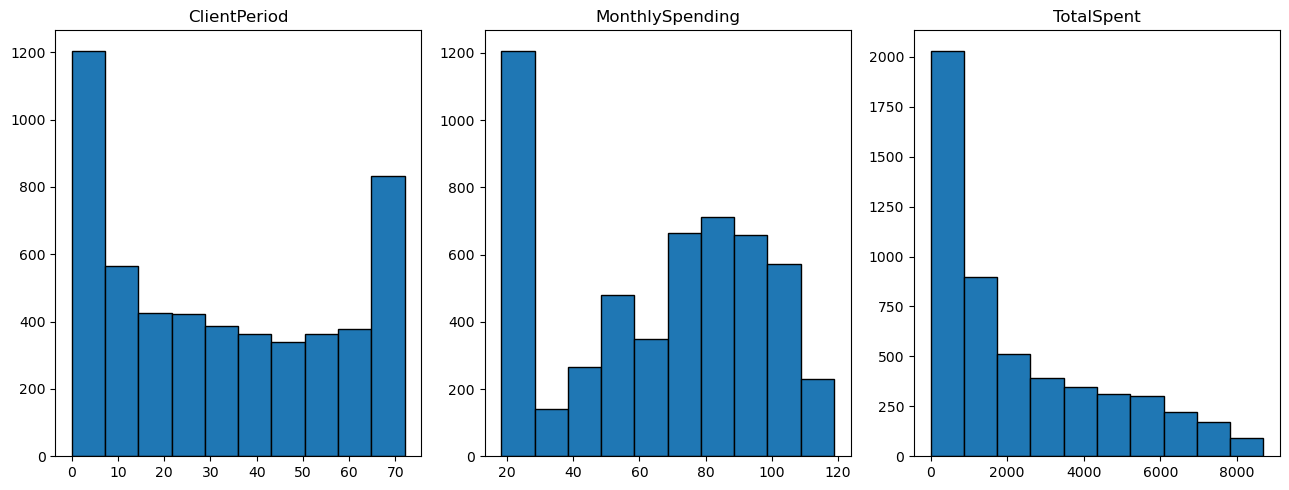

In [12]:
# гистограммы для численных признаков
fig, ax = plt.subplots(1, 3, figsize=(13, 5))

for i, col in enumerate(num_cols):
    ax[i].hist(train_data[col], edgecolor='black')
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [13]:
train_data[cat_cols].nunique() # посчитаем число уникальных признаков для каждой колонки

Sex                         2
IsSeniorCitizen             2
HasPartner                  2
HasChild                    2
HasPhoneService             2
HasMultiplePhoneNumbers     3
HasInternetService          3
HasOnlineSecurityService    3
HasOnlineBackup             3
HasDeviceProtection         3
HasTechSupportAccess        3
HasOnlineTV                 3
HasMovieSubscription        3
HasContractPhone            3
IsBillingPaperless          2
PaymentMethod               4
dtype: int64

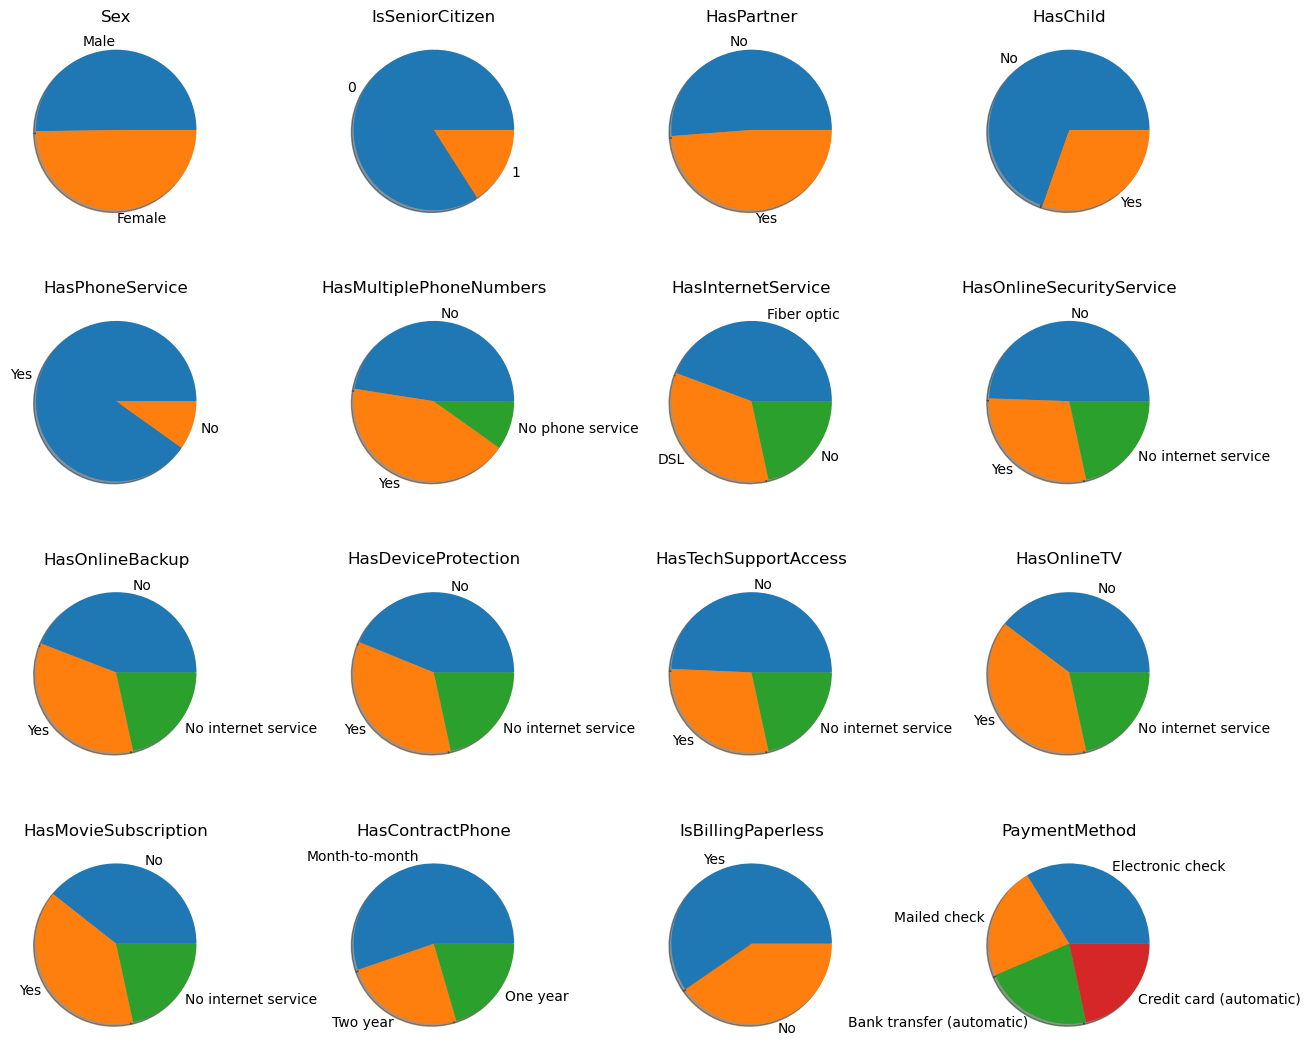

In [14]:
# pie-charts для категориальных признаков
fig, ax = plt.subplots(4, 4, figsize=(13, 11))
ax = ax.flatten()
for i, col in enumerate(cat_cols):
    data = train_data[col].value_counts()
    ax[i].pie(data.values, labels=data.index, shadow=True)
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

# видно, что не для всех фич классы сбалансированы

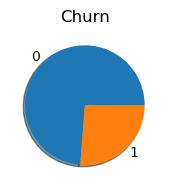

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

target_data = train_data["Churn"].value_counts()

ax.pie(target_data.values, labels=target_data.index, shadow=True)
ax.set_title("Churn")

plt.tight_layout()
plt.show()

In [16]:
target_data

0    3898
1    1384
Name: Churn, dtype: int64

Видно, что классы несбалансированы: объектов класса 1 примерно в 3 раза больше объектов класса 0.

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [17]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

Применим one-hot encoding для категориальных фич, чтобы можно было их потом засунуть в линейную модель.

In [18]:
# one-hot encoding
dummie_features = pd.get_dummies(train_data[cat_cols])
numeric_features = train_data[num_cols]

X = pd.concat([numeric_features, dummie_features], axis=1)
X_orig = train_data.iloc[:, :-1]

y = train_data.Churn

In [19]:
X.head()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,55,19.50,1026.35,0,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
1,72,25.85,1872.20,0,0,1,0,1,1,0,...,0,0,0,1,1,0,0,1,0,0
2,1,75.90,75.90,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
3,32,79.30,2570.00,1,1,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
4,60,115.25,6758.45,0,1,0,0,1,0,1,...,1,0,0,1,1,0,0,1,0,0


Разделим данные на train и validation:

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1111)

Отнормируем данные в виде нормального распределения с помощью StandardScaler (только на train данных, разумеется):

In [21]:
# без make_pipeline, чтобы отдельно сделать fit только на train данных
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])

Зададим несколько параметров C, отвечающих за силу регуляризации (чем меньше C, тем сильнее регуляризация) и с помощью кросс-валидации найдем оптимальное C. Метрика -- ROC-AUC. Модель сама выберет лучшее C и переобучится заново с ним.

In [22]:
Cs = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
linear_model = LogisticRegressionCV(Cs=Cs, scoring='roc_auc', refit=True, random_state=1111)
linear_model.fit(X_train, y_train)

LogisticRegressionCV(Cs=[100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                     random_state=1111, scoring='roc_auc')

Выведем ROC-AUC score для каждого из параметров C (усредненный по всем сплитам).

In [23]:
train_scores = linear_model.scores_[1].mean(axis=0)
train_scores

array([0.84433378, 0.84440559, 0.84446845, 0.84389085, 0.84162783,
       0.83661134, 0.83238195])

Сохраним оптимальное C отдельно.

In [24]:
C_best = linear_model.C_[0]
C_best

1.0

In [25]:
y_train_pred = linear_model.predict_proba(X_train)[:, 1]
y_val_pred = linear_model.predict_proba(X_val)[:, 1]

Выпишем какое лучшее качество и с какими параметрами удалось получить:

In [26]:
train_score = train_scores.max()
val_score = roc_auc_score(y_val, y_val_pred)

print(f"train_score: {train_score:.3}")
print(f"val_score: {val_score:.3}")
print(f"parameters: C={C_best}")

train_score: 0.844
val_score: 0.845
parameters: C=1.0


Отразим на графике ROC кривую для train и validation выборок:

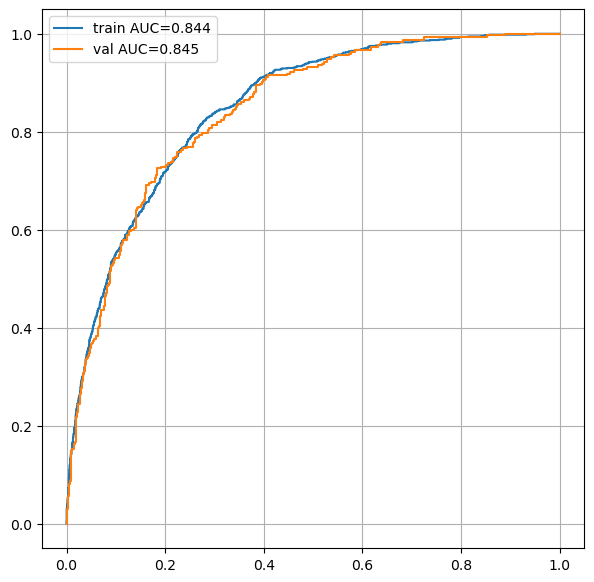

In [27]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(*roc_curve(y_train, y_train_pred)[:2], label=f'train AUC={train_score:.3f}')
ax.plot(*roc_curve(y_val, y_val_pred)[:2], label=f'val AUC={val_score:.3f}')
ax.legend()
ax.grid()

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [28]:
import catboost

In [29]:
X_orig

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check
5278,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic)
5279,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check
5280,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic)


Так как catboost сам обрабатывает категориальные признаки, one-hot encoding не делаем:

In [30]:
# split оригинальных данных без one-hot encoding
X_train, X_val, y_train, y_val = train_test_split(X_orig, y, test_size=0.20, random_state=1111)

Запустим CatBoostClassifier со стандартными параметрами:

In [31]:
boost_model = catboost.CatBoostClassifier(cat_features=cat_cols, eval_metric='AUC', random_seed=1111)

boost_model.fit(X_train, y_train)

Learning rate set to 0.019062
0:	total: 126ms	remaining: 2m 5s
1:	total: 172ms	remaining: 1m 25s
2:	total: 228ms	remaining: 1m 15s
3:	total: 282ms	remaining: 1m 10s
4:	total: 324ms	remaining: 1m 4s
5:	total: 357ms	remaining: 59.2s
6:	total: 392ms	remaining: 55.6s
7:	total: 427ms	remaining: 52.9s
8:	total: 466ms	remaining: 51.3s
9:	total: 504ms	remaining: 49.8s
10:	total: 536ms	remaining: 48.1s
11:	total: 573ms	remaining: 47.2s
12:	total: 592ms	remaining: 45s
13:	total: 631ms	remaining: 44.4s
14:	total: 667ms	remaining: 43.8s
15:	total: 707ms	remaining: 43.5s
16:	total: 726ms	remaining: 42s
17:	total: 756ms	remaining: 41.3s
18:	total: 793ms	remaining: 40.9s
19:	total: 829ms	remaining: 40.6s
20:	total: 878ms	remaining: 40.9s
21:	total: 943ms	remaining: 41.9s
22:	total: 989ms	remaining: 42s
23:	total: 1.03s	remaining: 41.9s
24:	total: 1.08s	remaining: 42.3s
25:	total: 1.13s	remaining: 42.5s
26:	total: 1.16s	remaining: 41.8s
27:	total: 1.21s	remaining: 41.9s
28:	total: 1.25s	remaining: 41.

247:	total: 8.17s	remaining: 24.8s
248:	total: 8.2s	remaining: 24.7s
249:	total: 8.23s	remaining: 24.7s
250:	total: 8.26s	remaining: 24.7s
251:	total: 8.29s	remaining: 24.6s
252:	total: 8.33s	remaining: 24.6s
253:	total: 8.35s	remaining: 24.5s
254:	total: 8.38s	remaining: 24.5s
255:	total: 8.41s	remaining: 24.5s
256:	total: 8.44s	remaining: 24.4s
257:	total: 8.47s	remaining: 24.4s
258:	total: 8.49s	remaining: 24.3s
259:	total: 8.52s	remaining: 24.3s
260:	total: 8.55s	remaining: 24.2s
261:	total: 8.58s	remaining: 24.2s
262:	total: 8.62s	remaining: 24.2s
263:	total: 8.65s	remaining: 24.1s
264:	total: 8.69s	remaining: 24.1s
265:	total: 8.71s	remaining: 24s
266:	total: 8.75s	remaining: 24s
267:	total: 8.79s	remaining: 24s
268:	total: 8.82s	remaining: 24s
269:	total: 8.85s	remaining: 23.9s
270:	total: 8.88s	remaining: 23.9s
271:	total: 8.91s	remaining: 23.9s
272:	total: 8.92s	remaining: 23.8s
273:	total: 8.95s	remaining: 23.7s
274:	total: 8.96s	remaining: 23.6s
275:	total: 8.98s	remaining: 

485:	total: 15.6s	remaining: 16.5s
486:	total: 15.6s	remaining: 16.5s
487:	total: 15.7s	remaining: 16.5s
488:	total: 15.7s	remaining: 16.4s
489:	total: 15.8s	remaining: 16.4s
490:	total: 15.8s	remaining: 16.4s
491:	total: 15.9s	remaining: 16.4s
492:	total: 15.9s	remaining: 16.3s
493:	total: 15.9s	remaining: 16.3s
494:	total: 16s	remaining: 16.3s
495:	total: 16s	remaining: 16.3s
496:	total: 16s	remaining: 16.2s
497:	total: 16.1s	remaining: 16.2s
498:	total: 16.1s	remaining: 16.2s
499:	total: 16.1s	remaining: 16.1s
500:	total: 16.2s	remaining: 16.1s
501:	total: 16.2s	remaining: 16.1s
502:	total: 16.2s	remaining: 16s
503:	total: 16.3s	remaining: 16s
504:	total: 16.3s	remaining: 16s
505:	total: 16.4s	remaining: 16s
506:	total: 16.4s	remaining: 15.9s
507:	total: 16.4s	remaining: 15.9s
508:	total: 16.5s	remaining: 15.9s
509:	total: 16.5s	remaining: 15.8s
510:	total: 16.5s	remaining: 15.8s
511:	total: 16.5s	remaining: 15.8s
512:	total: 16.6s	remaining: 15.7s
513:	total: 16.6s	remaining: 15.7s

722:	total: 25.5s	remaining: 9.77s
723:	total: 25.5s	remaining: 9.73s
724:	total: 25.6s	remaining: 9.7s
725:	total: 25.6s	remaining: 9.66s
726:	total: 25.6s	remaining: 9.63s
727:	total: 25.7s	remaining: 9.6s
728:	total: 25.7s	remaining: 9.56s
729:	total: 25.8s	remaining: 9.53s
730:	total: 25.8s	remaining: 9.49s
731:	total: 25.8s	remaining: 9.46s
732:	total: 25.9s	remaining: 9.42s
733:	total: 25.9s	remaining: 9.39s
734:	total: 25.9s	remaining: 9.35s
735:	total: 26s	remaining: 9.32s
736:	total: 26s	remaining: 9.28s
737:	total: 26s	remaining: 9.25s
738:	total: 26.1s	remaining: 9.22s
739:	total: 26.1s	remaining: 9.18s
740:	total: 26.2s	remaining: 9.15s
741:	total: 26.2s	remaining: 9.11s
742:	total: 26.2s	remaining: 9.08s
743:	total: 26.3s	remaining: 9.04s
744:	total: 26.3s	remaining: 9s
745:	total: 26.3s	remaining: 8.97s
746:	total: 26.4s	remaining: 8.94s
747:	total: 26.4s	remaining: 8.9s
748:	total: 26.5s	remaining: 8.87s
749:	total: 26.5s	remaining: 8.83s
750:	total: 26.5s	remaining: 8.8

963:	total: 34.8s	remaining: 1.3s
964:	total: 34.8s	remaining: 1.26s
965:	total: 34.9s	remaining: 1.23s
966:	total: 34.9s	remaining: 1.19s
967:	total: 34.9s	remaining: 1.16s
968:	total: 35s	remaining: 1.12s
969:	total: 35s	remaining: 1.08s
970:	total: 35.1s	remaining: 1.05s
971:	total: 35.1s	remaining: 1.01s
972:	total: 35.1s	remaining: 975ms
973:	total: 35.2s	remaining: 939ms
974:	total: 35.2s	remaining: 903ms
975:	total: 35.3s	remaining: 867ms
976:	total: 35.3s	remaining: 831ms
977:	total: 35.3s	remaining: 795ms
978:	total: 35.4s	remaining: 759ms
979:	total: 35.4s	remaining: 723ms
980:	total: 35.5s	remaining: 687ms
981:	total: 35.5s	remaining: 651ms
982:	total: 35.5s	remaining: 615ms
983:	total: 35.6s	remaining: 579ms
984:	total: 35.6s	remaining: 542ms
985:	total: 35.7s	remaining: 506ms
986:	total: 35.7s	remaining: 470ms
987:	total: 35.7s	remaining: 434ms
988:	total: 35.8s	remaining: 398ms
989:	total: 35.8s	remaining: 362ms
990:	total: 35.8s	remaining: 325ms
991:	total: 35.9s	remaini

Выведем его параметры, ROC-AUC score на train и validation выборках:

In [32]:
print(f"n_estimators: {boost_model.get_all_params()['iterations']}")
print(f"learning rate: {boost_model.learning_rate_:.2f}")

n_estimators: 1000
learning rate: 0.02


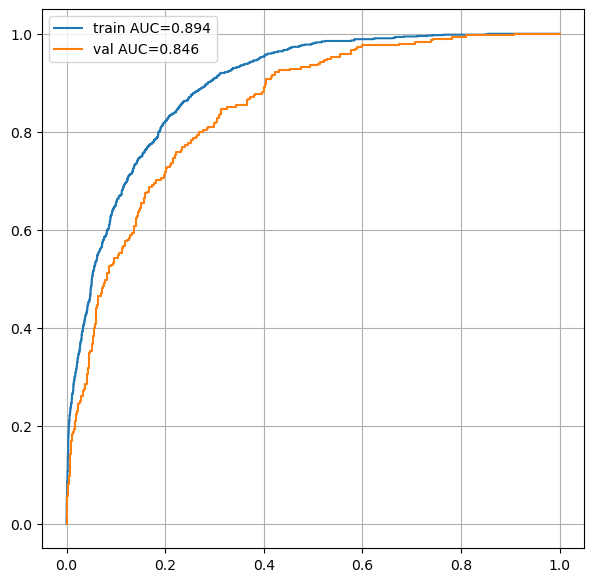

In [33]:
y_train_pred = boost_model.predict_proba(X_train)[:, 1]
y_val_pred = boost_model.predict_proba(X_val)[:, 1]

train_score = roc_auc_score(y_train, y_train_pred)
val_score = roc_auc_score(y_val, y_val_pred)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(*roc_curve(y_train, y_train_pred)[:2], label=f'train AUC={train_score:.3f}')
ax.plot(*roc_curve(y_val, y_val_pred)[:2], label=f'val AUC={val_score:.3f}')
ax.legend()
ax.grid()

Запустим grid_search с cv=3:

In [77]:
n_estimators = [200, 400, 600, 800, 1000]
lrs = [0.001, 0.005, 0.01, 0.05, 0.1]

In [85]:
boost_model_cv = catboost.CatBoostClassifier(cat_features=cat_cols, eval_metric='AUC', random_seed=1111)
boost_model_cv.grid_search(param_grid={"n_estimators": n_estimators, "learning_rate": lrs}, X=X_train, y=y_train, cv=3)

0:	test: 0.7635069	best: 0.7635069 (0)	total: 27ms	remaining: 5.37s
1:	test: 0.7792347	best: 0.7792347 (1)	total: 54.7ms	remaining: 5.41s
2:	test: 0.7788797	best: 0.7792347 (1)	total: 82.4ms	remaining: 5.41s
3:	test: 0.7979724	best: 0.7979724 (3)	total: 110ms	remaining: 5.41s
4:	test: 0.8114832	best: 0.8114832 (4)	total: 133ms	remaining: 5.2s
5:	test: 0.8122801	best: 0.8122801 (5)	total: 152ms	remaining: 4.9s
6:	test: 0.8138738	best: 0.8138738 (6)	total: 174ms	remaining: 4.79s
7:	test: 0.8143393	best: 0.8143393 (7)	total: 192ms	remaining: 4.61s
8:	test: 0.8163511	best: 0.8163511 (8)	total: 218ms	remaining: 4.63s
9:	test: 0.8159606	best: 0.8163511 (8)	total: 245ms	remaining: 4.66s
10:	test: 0.8165325	best: 0.8165325 (10)	total: 279ms	remaining: 4.79s
11:	test: 0.8168836	best: 0.8168836 (11)	total: 304ms	remaining: 4.76s
12:	test: 0.8187101	best: 0.8187101 (12)	total: 331ms	remaining: 4.75s
13:	test: 0.8190809	best: 0.8190809 (13)	total: 352ms	remaining: 4.68s
14:	test: 0.8187968	best: 0

120:	test: 0.8262051	best: 0.8262288 (116)	total: 3.48s	remaining: 2.27s
121:	test: 0.8261420	best: 0.8262288 (116)	total: 3.53s	remaining: 2.25s
122:	test: 0.8261026	best: 0.8262288 (116)	total: 3.59s	remaining: 2.25s
123:	test: 0.8259290	best: 0.8262288 (116)	total: 3.62s	remaining: 2.22s
124:	test: 0.8259369	best: 0.8262288 (116)	total: 3.66s	remaining: 2.2s
125:	test: 0.8260868	best: 0.8262288 (116)	total: 3.71s	remaining: 2.18s
126:	test: 0.8261815	best: 0.8262288 (116)	total: 3.76s	remaining: 2.16s
127:	test: 0.8260316	best: 0.8262288 (116)	total: 3.81s	remaining: 2.15s
128:	test: 0.8260868	best: 0.8262288 (116)	total: 3.85s	remaining: 2.12s
129:	test: 0.8261105	best: 0.8262288 (116)	total: 3.86s	remaining: 2.08s
130:	test: 0.8260237	best: 0.8262288 (116)	total: 3.9s	remaining: 2.06s
131:	test: 0.8260394	best: 0.8262288 (116)	total: 3.95s	remaining: 2.03s
132:	test: 0.8260158	best: 0.8262288 (116)	total: 3.98s	remaining: 2s
133:	test: 0.8259684	best: 0.8262288 (116)	total: 4.01s	

32:	test: 0.8268560	best: 0.8278698 (15)	total: 895ms	remaining: 4.53s
33:	test: 0.8268087	best: 0.8278698 (15)	total: 927ms	remaining: 4.53s
34:	test: 0.8264260	best: 0.8278698 (15)	total: 957ms	remaining: 4.51s
35:	test: 0.8268126	best: 0.8278698 (15)	total: 989ms	remaining: 4.5s
36:	test: 0.8266509	best: 0.8278698 (15)	total: 1.02s	remaining: 4.49s
37:	test: 0.8266824	best: 0.8278698 (15)	total: 1.04s	remaining: 4.42s
38:	test: 0.8264615	best: 0.8278698 (15)	total: 1.07s	remaining: 4.4s
39:	test: 0.8263195	best: 0.8278698 (15)	total: 1.08s	remaining: 4.34s
40:	test: 0.8259961	best: 0.8278698 (15)	total: 1.12s	remaining: 4.36s
41:	test: 0.8259606	best: 0.8278698 (15)	total: 1.17s	remaining: 4.38s
42:	test: 0.8257949	best: 0.8278698 (15)	total: 1.21s	remaining: 4.41s
43:	test: 0.8257396	best: 0.8278698 (15)	total: 1.25s	remaining: 4.43s
44:	test: 0.8258935	best: 0.8278698 (15)	total: 1.29s	remaining: 4.44s
45:	test: 0.8261065	best: 0.8278698 (15)	total: 1.32s	remaining: 4.43s
46:	test

149:	test: 0.8296016	best: 0.8299684 (126)	total: 4.03s	remaining: 1.34s
150:	test: 0.8296568	best: 0.8299684 (126)	total: 4.05s	remaining: 1.31s
151:	test: 0.8296252	best: 0.8299684 (126)	total: 4.08s	remaining: 1.29s
152:	test: 0.8295779	best: 0.8299684 (126)	total: 4.09s	remaining: 1.26s
153:	test: 0.8295937	best: 0.8299684 (126)	total: 4.12s	remaining: 1.23s
154:	test: 0.8294517	best: 0.8299684 (126)	total: 4.15s	remaining: 1.2s
155:	test: 0.8294753	best: 0.8299684 (126)	total: 4.17s	remaining: 1.18s
156:	test: 0.8296331	best: 0.8299684 (126)	total: 4.19s	remaining: 1.15s
157:	test: 0.8296252	best: 0.8299684 (126)	total: 4.22s	remaining: 1.12s
158:	test: 0.8295148	best: 0.8299684 (126)	total: 4.25s	remaining: 1.1s
159:	test: 0.8295937	best: 0.8299684 (126)	total: 4.29s	remaining: 1.07s
160:	test: 0.8296095	best: 0.8299684 (126)	total: 4.33s	remaining: 1.05s
161:	test: 0.8299014	best: 0.8299684 (126)	total: 4.36s	remaining: 1.02s
162:	test: 0.8299882	best: 0.8299882 (162)	total: 4.4

62:	test: 0.8305878	best: 0.8306272 (57)	total: 2s	remaining: 4.35s
63:	test: 0.8306746	best: 0.8306746 (63)	total: 2.04s	remaining: 4.33s
64:	test: 0.8308639	best: 0.8308639 (64)	total: 2.08s	remaining: 4.31s
65:	test: 0.8309586	best: 0.8309586 (65)	total: 2.1s	remaining: 4.26s
66:	test: 0.8310059	best: 0.8310059 (66)	total: 2.14s	remaining: 4.25s
67:	test: 0.8311243	best: 0.8311243 (67)	total: 2.18s	remaining: 4.23s
68:	test: 0.8317791	best: 0.8317791 (68)	total: 2.21s	remaining: 4.2s
69:	test: 0.8317870	best: 0.8317870 (69)	total: 2.24s	remaining: 4.16s
70:	test: 0.8318185	best: 0.8318185 (70)	total: 2.27s	remaining: 4.13s
71:	test: 0.8318659	best: 0.8318659 (71)	total: 2.3s	remaining: 4.09s
72:	test: 0.8317791	best: 0.8318659 (71)	total: 2.34s	remaining: 4.07s
73:	test: 0.8318501	best: 0.8318659 (71)	total: 2.37s	remaining: 4.04s
74:	test: 0.8318895	best: 0.8318895 (74)	total: 2.41s	remaining: 4.01s
75:	test: 0.8318580	best: 0.8318895 (74)	total: 2.44s	remaining: 3.98s
76:	test: 0.

179:	test: 0.8397278	best: 0.8397278 (179)	total: 5.55s	remaining: 617ms
180:	test: 0.8398619	best: 0.8398619 (180)	total: 5.59s	remaining: 587ms
181:	test: 0.8397673	best: 0.8398619 (180)	total: 5.63s	remaining: 556ms
182:	test: 0.8397673	best: 0.8398619 (180)	total: 5.63s	remaining: 523ms
183:	test: 0.8397909	best: 0.8398619 (180)	total: 5.66s	remaining: 493ms
184:	test: 0.8398146	best: 0.8398619 (180)	total: 5.69s	remaining: 462ms
185:	test: 0.8399093	best: 0.8399093 (185)	total: 5.72s	remaining: 431ms
186:	test: 0.8398777	best: 0.8399093 (185)	total: 5.76s	remaining: 400ms
187:	test: 0.8399882	best: 0.8399882 (187)	total: 5.79s	remaining: 370ms
188:	test: 0.8400118	best: 0.8400118 (188)	total: 5.83s	remaining: 339ms
189:	test: 0.8401381	best: 0.8401381 (189)	total: 5.85s	remaining: 308ms
190:	test: 0.8402564	best: 0.8402564 (190)	total: 5.91s	remaining: 278ms
191:	test: 0.8402801	best: 0.8402801 (191)	total: 5.95s	remaining: 248ms
192:	test: 0.8402170	best: 0.8402801 (191)	total: 5

92:	test: 0.8424970	best: 0.8429546 (89)	total: 3.73s	remaining: 4.29s
93:	test: 0.8425444	best: 0.8429546 (89)	total: 3.79s	remaining: 4.27s
94:	test: 0.8425444	best: 0.8429546 (89)	total: 3.8s	remaining: 4.2s
95:	test: 0.8425444	best: 0.8429546 (89)	total: 3.83s	remaining: 4.15s
96:	test: 0.8425444	best: 0.8429546 (89)	total: 3.85s	remaining: 4.08s
97:	test: 0.8426943	best: 0.8429546 (89)	total: 3.9s	remaining: 4.06s
98:	test: 0.8426943	best: 0.8429546 (89)	total: 3.92s	remaining: 4s
99:	test: 0.8427179	best: 0.8429546 (89)	total: 3.94s	remaining: 3.94s
100:	test: 0.8427732	best: 0.8429546 (89)	total: 3.96s	remaining: 3.89s
101:	test: 0.8430572	best: 0.8430572 (101)	total: 4s	remaining: 3.84s
102:	test: 0.8430572	best: 0.8430572 (101)	total: 4.02s	remaining: 3.78s
103:	test: 0.8431045	best: 0.8431045 (103)	total: 4.05s	remaining: 3.74s
104:	test: 0.8437751	best: 0.8437751 (104)	total: 4.09s	remaining: 3.7s
105:	test: 0.8436331	best: 0.8437751 (104)	total: 4.11s	remaining: 3.65s
106:	

2:	test: 0.7895069	best: 0.7895069 (2)	total: 160ms	remaining: 10.5s
3:	test: 0.7895266	best: 0.7895266 (3)	total: 196ms	remaining: 9.61s
4:	test: 0.8041657	best: 0.8041657 (4)	total: 254ms	remaining: 9.89s
5:	test: 0.8140750	best: 0.8140750 (5)	total: 313ms	remaining: 10.1s
6:	test: 0.8174162	best: 0.8174162 (6)	total: 363ms	remaining: 10s
7:	test: 0.8213886	best: 0.8213886 (7)	total: 417ms	remaining: 10s
8:	test: 0.8233097	best: 0.8233097 (8)	total: 467ms	remaining: 9.92s
9:	test: 0.8249507	best: 0.8249507 (9)	total: 498ms	remaining: 9.45s
10:	test: 0.8237357	best: 0.8249507 (9)	total: 560ms	remaining: 9.62s
11:	test: 0.8254990	best: 0.8254990 (11)	total: 631ms	remaining: 9.88s
12:	test: 0.8269349	best: 0.8269349 (12)	total: 683ms	remaining: 9.83s
13:	test: 0.8280710	best: 0.8280710 (13)	total: 727ms	remaining: 9.66s
14:	test: 0.8290099	best: 0.8290099 (14)	total: 747ms	remaining: 9.21s
15:	test: 0.8300276	best: 0.8300276 (15)	total: 762ms	remaining: 8.77s
16:	test: 0.8319290	best: 0

121:	test: 0.8409270	best: 0.8463945 (87)	total: 4.25s	remaining: 2.72s
122:	test: 0.8407140	best: 0.8463945 (87)	total: 4.28s	remaining: 2.68s
123:	test: 0.8406430	best: 0.8463945 (87)	total: 4.31s	remaining: 2.64s
124:	test: 0.8407929	best: 0.8463945 (87)	total: 4.36s	remaining: 2.61s
125:	test: 0.8403984	best: 0.8463945 (87)	total: 4.4s	remaining: 2.59s
126:	test: 0.8402643	best: 0.8463945 (87)	total: 4.46s	remaining: 2.56s
127:	test: 0.8406588	best: 0.8463945 (87)	total: 4.5s	remaining: 2.53s
128:	test: 0.8406746	best: 0.8463945 (87)	total: 4.56s	remaining: 2.51s
129:	test: 0.8407061	best: 0.8463945 (87)	total: 4.61s	remaining: 2.48s
130:	test: 0.8405641	best: 0.8463945 (87)	total: 4.66s	remaining: 2.45s
131:	test: 0.8407416	best: 0.8463945 (87)	total: 4.71s	remaining: 2.42s
132:	test: 0.8405523	best: 0.8463945 (87)	total: 4.76s	remaining: 2.4s
133:	test: 0.8404813	best: 0.8463945 (87)	total: 4.81s	remaining: 2.37s
134:	test: 0.8404339	best: 0.8463945 (87)	total: 4.86s	remaining: 2

37:	test: 0.8201460	best: 0.8203787 (29)	total: 1.18s	remaining: 11.2s
38:	test: 0.8206193	best: 0.8206193 (38)	total: 1.21s	remaining: 11.2s
39:	test: 0.8205089	best: 0.8206193 (38)	total: 1.24s	remaining: 11.2s
40:	test: 0.8203274	best: 0.8206193 (38)	total: 1.27s	remaining: 11.1s
41:	test: 0.8199093	best: 0.8206193 (38)	total: 1.28s	remaining: 10.9s
42:	test: 0.8199566	best: 0.8206193 (38)	total: 1.31s	remaining: 10.9s
43:	test: 0.8199250	best: 0.8206193 (38)	total: 1.34s	remaining: 10.8s
44:	test: 0.8195345	best: 0.8206193 (38)	total: 1.36s	remaining: 10.7s
45:	test: 0.8193373	best: 0.8206193 (38)	total: 1.4s	remaining: 10.7s
46:	test: 0.8197002	best: 0.8206193 (38)	total: 1.43s	remaining: 10.7s
47:	test: 0.8194320	best: 0.8206193 (38)	total: 1.46s	remaining: 10.7s
48:	test: 0.8194398	best: 0.8206193 (38)	total: 1.49s	remaining: 10.7s
49:	test: 0.8200868	best: 0.8206193 (38)	total: 1.53s	remaining: 10.7s
50:	test: 0.8202051	best: 0.8206193 (38)	total: 1.55s	remaining: 10.6s
51:	tes

156:	test: 0.8266548	best: 0.8267732 (154)	total: 4.79s	remaining: 7.41s
157:	test: 0.8267101	best: 0.8267732 (154)	total: 4.83s	remaining: 7.4s
158:	test: 0.8266154	best: 0.8267732 (154)	total: 4.87s	remaining: 7.38s
159:	test: 0.8267574	best: 0.8267732 (154)	total: 4.91s	remaining: 7.36s
160:	test: 0.8268757	best: 0.8268757 (160)	total: 4.95s	remaining: 7.34s
161:	test: 0.8268284	best: 0.8268757 (160)	total: 4.99s	remaining: 7.32s
162:	test: 0.8267968	best: 0.8268757 (160)	total: 5.03s	remaining: 7.31s
163:	test: 0.8268047	best: 0.8268757 (160)	total: 5.07s	remaining: 7.29s
164:	test: 0.8268442	best: 0.8268757 (160)	total: 5.11s	remaining: 7.27s
165:	test: 0.8268284	best: 0.8268757 (160)	total: 5.15s	remaining: 7.26s
166:	test: 0.8269152	best: 0.8269152 (166)	total: 5.18s	remaining: 7.23s
167:	test: 0.8269941	best: 0.8269941 (167)	total: 5.22s	remaining: 7.21s
168:	test: 0.8269625	best: 0.8269941 (167)	total: 5.26s	remaining: 7.19s
169:	test: 0.8270493	best: 0.8270493 (169)	total: 5.

269:	test: 0.8274201	best: 0.8275621 (264)	total: 8.21s	remaining: 3.95s
270:	test: 0.8275227	best: 0.8275621 (264)	total: 8.25s	remaining: 3.93s
271:	test: 0.8274517	best: 0.8275621 (264)	total: 8.28s	remaining: 3.9s
272:	test: 0.8275148	best: 0.8275621 (264)	total: 8.32s	remaining: 3.87s
273:	test: 0.8275385	best: 0.8275621 (264)	total: 8.35s	remaining: 3.84s
274:	test: 0.8274832	best: 0.8275621 (264)	total: 8.38s	remaining: 3.81s
275:	test: 0.8274043	best: 0.8275621 (264)	total: 8.4s	remaining: 3.77s
276:	test: 0.8274280	best: 0.8275621 (264)	total: 8.44s	remaining: 3.75s
277:	test: 0.8274753	best: 0.8275621 (264)	total: 8.47s	remaining: 3.72s
278:	test: 0.8275542	best: 0.8275621 (264)	total: 8.5s	remaining: 3.69s
279:	test: 0.8276095	best: 0.8276095 (279)	total: 8.52s	remaining: 3.65s
280:	test: 0.8275937	best: 0.8276095 (279)	total: 8.55s	remaining: 3.62s
281:	test: 0.8276095	best: 0.8276095 (279)	total: 8.58s	remaining: 3.59s
282:	test: 0.8277199	best: 0.8277199 (282)	total: 8.6s

386:	test: 0.8290888	best: 0.8290888 (386)	total: 11.3s	remaining: 380ms
387:	test: 0.8290414	best: 0.8290888 (386)	total: 11.4s	remaining: 351ms
388:	test: 0.8290256	best: 0.8290888 (386)	total: 11.4s	remaining: 322ms
389:	test: 0.8289546	best: 0.8290888 (386)	total: 11.4s	remaining: 292ms
390:	test: 0.8290256	best: 0.8290888 (386)	total: 11.4s	remaining: 263ms
391:	test: 0.8290493	best: 0.8290888 (386)	total: 11.4s	remaining: 233ms
392:	test: 0.8290888	best: 0.8290888 (386)	total: 11.5s	remaining: 204ms
393:	test: 0.8290651	best: 0.8290888 (386)	total: 11.5s	remaining: 175ms
394:	test: 0.8291282	best: 0.8291282 (394)	total: 11.5s	remaining: 146ms
395:	test: 0.8291992	best: 0.8291992 (395)	total: 11.5s	remaining: 116ms
396:	test: 0.8291913	best: 0.8291992 (395)	total: 11.6s	remaining: 87.3ms
397:	test: 0.8292308	best: 0.8292308 (397)	total: 11.6s	remaining: 58.2ms
398:	test: 0.8291834	best: 0.8292308 (397)	total: 11.6s	remaining: 29.1ms
399:	test: 0.8291440	best: 0.8292308 (397)	total

104:	test: 0.8291874	best: 0.8292032 (103)	total: 2.77s	remaining: 7.8s
105:	test: 0.8289822	best: 0.8292032 (103)	total: 2.8s	remaining: 7.76s
106:	test: 0.8290769	best: 0.8292032 (103)	total: 2.82s	remaining: 7.73s
107:	test: 0.8290059	best: 0.8292032 (103)	total: 2.85s	remaining: 7.71s
108:	test: 0.8290138	best: 0.8292032 (103)	total: 2.89s	remaining: 7.71s
109:	test: 0.8289034	best: 0.8292032 (103)	total: 2.92s	remaining: 7.7s
110:	test: 0.8290059	best: 0.8292032 (103)	total: 2.95s	remaining: 7.68s
111:	test: 0.8290375	best: 0.8292032 (103)	total: 2.98s	remaining: 7.66s
112:	test: 0.8289191	best: 0.8292032 (103)	total: 3.01s	remaining: 7.65s
113:	test: 0.8288323	best: 0.8292032 (103)	total: 3.04s	remaining: 7.64s
114:	test: 0.8289349	best: 0.8292032 (103)	total: 3.08s	remaining: 7.62s
115:	test: 0.8291874	best: 0.8292032 (103)	total: 3.1s	remaining: 7.59s
116:	test: 0.8292663	best: 0.8292663 (116)	total: 3.13s	remaining: 7.57s
117:	test: 0.8294714	best: 0.8294714 (117)	total: 3.15s

219:	test: 0.8346943	best: 0.8346943 (219)	total: 5.9s	remaining: 4.83s
220:	test: 0.8347968	best: 0.8347968 (220)	total: 5.93s	remaining: 4.8s
221:	test: 0.8349546	best: 0.8349546 (221)	total: 5.96s	remaining: 4.78s
222:	test: 0.8349862	best: 0.8349862 (222)	total: 5.98s	remaining: 4.75s
223:	test: 0.8349783	best: 0.8349862 (222)	total: 6.01s	remaining: 4.72s
224:	test: 0.8351045	best: 0.8351045 (224)	total: 6.02s	remaining: 4.68s
225:	test: 0.8352308	best: 0.8352308 (225)	total: 6.05s	remaining: 4.66s
226:	test: 0.8351913	best: 0.8352308 (225)	total: 6.08s	remaining: 4.63s
227:	test: 0.8351440	best: 0.8352308 (225)	total: 6.11s	remaining: 4.61s
228:	test: 0.8350256	best: 0.8352308 (225)	total: 6.14s	remaining: 4.58s
229:	test: 0.8352229	best: 0.8352308 (225)	total: 6.17s	remaining: 4.56s
230:	test: 0.8354201	best: 0.8354201 (230)	total: 6.2s	remaining: 4.54s
231:	test: 0.8353964	best: 0.8354201 (230)	total: 6.23s	remaining: 4.51s
232:	test: 0.8354596	best: 0.8354596 (232)	total: 6.26

335:	test: 0.8375582	best: 0.8376371 (334)	total: 9.01s	remaining: 1.72s
336:	test: 0.8375819	best: 0.8376371 (334)	total: 9.03s	remaining: 1.69s
337:	test: 0.8376686	best: 0.8376686 (337)	total: 9.06s	remaining: 1.66s
338:	test: 0.8376686	best: 0.8376686 (337)	total: 9.08s	remaining: 1.63s
339:	test: 0.8376213	best: 0.8376686 (337)	total: 9.11s	remaining: 1.61s
340:	test: 0.8377554	best: 0.8377554 (340)	total: 9.13s	remaining: 1.58s
341:	test: 0.8376529	best: 0.8377554 (340)	total: 9.16s	remaining: 1.55s
342:	test: 0.8376371	best: 0.8377554 (340)	total: 9.19s	remaining: 1.53s
343:	test: 0.8377949	best: 0.8377949 (343)	total: 9.22s	remaining: 1.5s
344:	test: 0.8376923	best: 0.8377949 (343)	total: 9.24s	remaining: 1.47s
345:	test: 0.8377081	best: 0.8377949 (343)	total: 9.27s	remaining: 1.45s
346:	test: 0.8377949	best: 0.8377949 (343)	total: 9.31s	remaining: 1.42s
347:	test: 0.8377712	best: 0.8377949 (343)	total: 9.33s	remaining: 1.39s
348:	test: 0.8377239	best: 0.8377949 (343)	total: 9.

51:	test: 0.8290730	best: 0.8291598 (49)	total: 1.43s	remaining: 9.56s
52:	test: 0.8295700	best: 0.8295700 (52)	total: 1.46s	remaining: 9.55s
53:	test: 0.8296016	best: 0.8296016 (53)	total: 1.47s	remaining: 9.43s
54:	test: 0.8301302	best: 0.8301302 (54)	total: 1.51s	remaining: 9.45s
55:	test: 0.8305483	best: 0.8305483 (55)	total: 1.54s	remaining: 9.45s
56:	test: 0.8305168	best: 0.8305483 (55)	total: 1.55s	remaining: 9.35s
57:	test: 0.8306272	best: 0.8306272 (57)	total: 1.58s	remaining: 9.3s
58:	test: 0.8305365	best: 0.8306272 (57)	total: 1.61s	remaining: 9.3s
59:	test: 0.8304497	best: 0.8306272 (57)	total: 1.64s	remaining: 9.28s
60:	test: 0.8304655	best: 0.8306272 (57)	total: 1.67s	remaining: 9.29s
61:	test: 0.8304931	best: 0.8306272 (57)	total: 1.71s	remaining: 9.32s
62:	test: 0.8305878	best: 0.8306272 (57)	total: 1.74s	remaining: 9.31s
63:	test: 0.8306746	best: 0.8306746 (63)	total: 1.77s	remaining: 9.3s
64:	test: 0.8308639	best: 0.8308639 (64)	total: 1.8s	remaining: 9.29s
65:	test: 

170:	test: 0.8394438	best: 0.8394438 (170)	total: 4.86s	remaining: 6.51s
171:	test: 0.8394201	best: 0.8394438 (170)	total: 4.9s	remaining: 6.49s
172:	test: 0.8395069	best: 0.8395069 (172)	total: 4.93s	remaining: 6.47s
173:	test: 0.8396331	best: 0.8396331 (173)	total: 4.96s	remaining: 6.45s
174:	test: 0.8395937	best: 0.8396331 (173)	total: 5s	remaining: 6.42s
175:	test: 0.8395937	best: 0.8396331 (173)	total: 5.03s	remaining: 6.4s
176:	test: 0.8396647	best: 0.8396647 (176)	total: 5.06s	remaining: 6.38s
177:	test: 0.8397120	best: 0.8397120 (177)	total: 5.1s	remaining: 6.36s
178:	test: 0.8396726	best: 0.8397120 (177)	total: 5.13s	remaining: 6.34s
179:	test: 0.8397278	best: 0.8397278 (179)	total: 5.18s	remaining: 6.33s
180:	test: 0.8398619	best: 0.8398619 (180)	total: 5.21s	remaining: 6.3s
181:	test: 0.8397673	best: 0.8398619 (180)	total: 5.24s	remaining: 6.27s
182:	test: 0.8397673	best: 0.8398619 (180)	total: 5.24s	remaining: 6.22s
183:	test: 0.8397909	best: 0.8398619 (180)	total: 5.28s	re

286:	test: 0.8416607	best: 0.8417239 (271)	total: 8.2s	remaining: 3.23s
287:	test: 0.8416055	best: 0.8417239 (271)	total: 8.22s	remaining: 3.2s
288:	test: 0.8416923	best: 0.8417239 (271)	total: 8.26s	remaining: 3.17s
289:	test: 0.8416371	best: 0.8417239 (271)	total: 8.29s	remaining: 3.14s
290:	test: 0.8414398	best: 0.8417239 (271)	total: 8.31s	remaining: 3.11s
291:	test: 0.8414635	best: 0.8417239 (271)	total: 8.35s	remaining: 3.09s
292:	test: 0.8414793	best: 0.8417239 (271)	total: 8.38s	remaining: 3.06s
293:	test: 0.8414793	best: 0.8417239 (271)	total: 8.39s	remaining: 3.03s
294:	test: 0.8415108	best: 0.8417239 (271)	total: 8.43s	remaining: 3s
295:	test: 0.8415740	best: 0.8417239 (271)	total: 8.46s	remaining: 2.97s
296:	test: 0.8416686	best: 0.8417239 (271)	total: 8.49s	remaining: 2.94s
297:	test: 0.8417870	best: 0.8417870 (297)	total: 8.52s	remaining: 2.92s
298:	test: 0.8417475	best: 0.8417870 (297)	total: 8.54s	remaining: 2.89s
299:	test: 0.8417791	best: 0.8417870 (297)	total: 8.57s	

4:	test: 0.8116213	best: 0.8116213 (4)	total: 140ms	remaining: 11.1s
5:	test: 0.8148639	best: 0.8148639 (5)	total: 161ms	remaining: 10.6s
6:	test: 0.8184773	best: 0.8184773 (6)	total: 191ms	remaining: 10.7s
7:	test: 0.8181538	best: 0.8184773 (6)	total: 206ms	remaining: 10.1s
8:	test: 0.8192150	best: 0.8192150 (8)	total: 233ms	remaining: 10.1s
9:	test: 0.8190572	best: 0.8192150 (8)	total: 262ms	remaining: 10.2s
10:	test: 0.8226509	best: 0.8226509 (10)	total: 291ms	remaining: 10.3s
11:	test: 0.8250809	best: 0.8250809 (11)	total: 319ms	remaining: 10.3s
12:	test: 0.8270848	best: 0.8270848 (12)	total: 350ms	remaining: 10.4s
13:	test: 0.8285286	best: 0.8285286 (13)	total: 381ms	remaining: 10.5s
14:	test: 0.8292071	best: 0.8292071 (14)	total: 408ms	remaining: 10.5s
15:	test: 0.8289822	best: 0.8292071 (14)	total: 436ms	remaining: 10.5s
16:	test: 0.8301499	best: 0.8301499 (16)	total: 464ms	remaining: 10.5s
17:	test: 0.8311834	best: 0.8311834 (17)	total: 494ms	remaining: 10.5s
18:	test: 0.830781

123:	test: 0.8448087	best: 0.8448560 (122)	total: 3.25s	remaining: 7.25s
124:	test: 0.8447850	best: 0.8448560 (122)	total: 3.29s	remaining: 7.23s
125:	test: 0.8442485	best: 0.8448560 (122)	total: 3.32s	remaining: 7.21s
126:	test: 0.8444458	best: 0.8448560 (122)	total: 3.34s	remaining: 7.19s
127:	test: 0.8444536	best: 0.8448560 (122)	total: 3.37s	remaining: 7.17s
128:	test: 0.8444773	best: 0.8448560 (122)	total: 3.4s	remaining: 7.15s
129:	test: 0.8444142	best: 0.8448560 (122)	total: 3.43s	remaining: 7.13s
130:	test: 0.8444458	best: 0.8448560 (122)	total: 3.46s	remaining: 7.11s
131:	test: 0.8445089	best: 0.8448560 (122)	total: 3.49s	remaining: 7.09s
132:	test: 0.8444142	best: 0.8448560 (122)	total: 3.52s	remaining: 7.07s
133:	test: 0.8445878	best: 0.8448560 (122)	total: 3.55s	remaining: 7.05s
134:	test: 0.8445168	best: 0.8448560 (122)	total: 3.58s	remaining: 7.03s
135:	test: 0.8445168	best: 0.8448560 (122)	total: 3.59s	remaining: 6.96s
136:	test: 0.8445010	best: 0.8448560 (122)	total: 3.

242:	test: 0.8432939	best: 0.8451953 (204)	total: 7.12s	remaining: 4.6s
243:	test: 0.8435464	best: 0.8451953 (204)	total: 7.15s	remaining: 4.57s
244:	test: 0.8436726	best: 0.8451953 (204)	total: 7.18s	remaining: 4.55s
245:	test: 0.8436726	best: 0.8451953 (204)	total: 7.22s	remaining: 4.52s
246:	test: 0.8436963	best: 0.8451953 (204)	total: 7.26s	remaining: 4.5s
247:	test: 0.8436963	best: 0.8451953 (204)	total: 7.31s	remaining: 4.48s
248:	test: 0.8436016	best: 0.8451953 (204)	total: 7.35s	remaining: 4.46s
249:	test: 0.8435542	best: 0.8451953 (204)	total: 7.39s	remaining: 4.43s
250:	test: 0.8435858	best: 0.8451953 (204)	total: 7.43s	remaining: 4.41s
251:	test: 0.8434596	best: 0.8451953 (204)	total: 7.47s	remaining: 4.39s
252:	test: 0.8434201	best: 0.8451953 (204)	total: 7.5s	remaining: 4.36s
253:	test: 0.8433807	best: 0.8451953 (204)	total: 7.53s	remaining: 4.33s
254:	test: 0.8435385	best: 0.8451953 (204)	total: 7.57s	remaining: 4.3s
255:	test: 0.8436884	best: 0.8451953 (204)	total: 7.61s

358:	test: 0.8419487	best: 0.8451953 (204)	total: 11.5s	remaining: 1.31s
359:	test: 0.8419566	best: 0.8451953 (204)	total: 11.5s	remaining: 1.28s
360:	test: 0.8420592	best: 0.8451953 (204)	total: 11.6s	remaining: 1.25s
361:	test: 0.8417988	best: 0.8451953 (204)	total: 11.6s	remaining: 1.22s
362:	test: 0.8418856	best: 0.8451953 (204)	total: 11.7s	remaining: 1.19s
363:	test: 0.8419487	best: 0.8451953 (204)	total: 11.7s	remaining: 1.16s
364:	test: 0.8418856	best: 0.8451953 (204)	total: 11.7s	remaining: 1.12s
365:	test: 0.8416805	best: 0.8451953 (204)	total: 11.8s	remaining: 1.09s
366:	test: 0.8417357	best: 0.8451953 (204)	total: 11.8s	remaining: 1.06s
367:	test: 0.8417041	best: 0.8451953 (204)	total: 11.8s	remaining: 1.03s
368:	test: 0.8415621	best: 0.8451953 (204)	total: 11.9s	remaining: 997ms
369:	test: 0.8415385	best: 0.8451953 (204)	total: 11.9s	remaining: 965ms
370:	test: 0.8415700	best: 0.8451953 (204)	total: 11.9s	remaining: 934ms
371:	test: 0.8414753	best: 0.8451953 (204)	total: 1

71:	test: 0.8452032	best: 0.8452032 (71)	total: 2.44s	remaining: 11.1s
72:	test: 0.8448481	best: 0.8452032 (71)	total: 2.47s	remaining: 11.1s
73:	test: 0.8446193	best: 0.8452032 (71)	total: 2.53s	remaining: 11.1s
74:	test: 0.8445562	best: 0.8452032 (71)	total: 2.58s	remaining: 11.2s
75:	test: 0.8449744	best: 0.8452032 (71)	total: 2.63s	remaining: 11.2s
76:	test: 0.8448876	best: 0.8452032 (71)	total: 2.69s	remaining: 11.3s
77:	test: 0.8449507	best: 0.8452032 (71)	total: 2.75s	remaining: 11.4s
78:	test: 0.8449665	best: 0.8452032 (71)	total: 2.81s	remaining: 11.4s
79:	test: 0.8450375	best: 0.8452032 (71)	total: 2.85s	remaining: 11.4s
80:	test: 0.8454951	best: 0.8454951 (80)	total: 2.9s	remaining: 11.4s
81:	test: 0.8457949	best: 0.8457949 (81)	total: 2.94s	remaining: 11.4s
82:	test: 0.8457633	best: 0.8457949 (81)	total: 3s	remaining: 11.4s
83:	test: 0.8459053	best: 0.8459053 (83)	total: 3.04s	remaining: 11.4s
84:	test: 0.8456923	best: 0.8459053 (83)	total: 3.09s	remaining: 11.4s
85:	test: 

186:	test: 0.8391400	best: 0.8463945 (87)	total: 6.56s	remaining: 7.48s
187:	test: 0.8387613	best: 0.8463945 (87)	total: 6.59s	remaining: 7.44s
188:	test: 0.8387850	best: 0.8463945 (87)	total: 6.62s	remaining: 7.39s
189:	test: 0.8387140	best: 0.8463945 (87)	total: 6.65s	remaining: 7.35s
190:	test: 0.8387535	best: 0.8463945 (87)	total: 6.68s	remaining: 7.31s
191:	test: 0.8389112	best: 0.8463945 (87)	total: 6.71s	remaining: 7.27s
192:	test: 0.8379645	best: 0.8463945 (87)	total: 6.74s	remaining: 7.23s
193:	test: 0.8376489	best: 0.8463945 (87)	total: 6.76s	remaining: 7.18s
194:	test: 0.8374832	best: 0.8463945 (87)	total: 6.79s	remaining: 7.14s
195:	test: 0.8371755	best: 0.8463945 (87)	total: 6.82s	remaining: 7.1s
196:	test: 0.8369310	best: 0.8463945 (87)	total: 6.85s	remaining: 7.06s
197:	test: 0.8370572	best: 0.8463945 (87)	total: 6.88s	remaining: 7.02s
198:	test: 0.8376410	best: 0.8463945 (87)	total: 6.91s	remaining: 6.98s
199:	test: 0.8373452	best: 0.8463945 (87)	total: 6.94s	remaining:

306:	test: 0.8333176	best: 0.8463945 (87)	total: 9.99s	remaining: 3.02s
307:	test: 0.8330335	best: 0.8463945 (87)	total: 10s	remaining: 2.99s
308:	test: 0.8329467	best: 0.8463945 (87)	total: 10s	remaining: 2.96s
309:	test: 0.8330178	best: 0.8463945 (87)	total: 10.1s	remaining: 2.93s
310:	test: 0.8327258	best: 0.8463945 (87)	total: 10.1s	remaining: 2.89s
311:	test: 0.8326706	best: 0.8463945 (87)	total: 10.1s	remaining: 2.86s
312:	test: 0.8325996	best: 0.8463945 (87)	total: 10.2s	remaining: 2.82s
313:	test: 0.8329941	best: 0.8463945 (87)	total: 10.2s	remaining: 2.79s
314:	test: 0.8328915	best: 0.8463945 (87)	total: 10.2s	remaining: 2.76s
315:	test: 0.8331519	best: 0.8463945 (87)	total: 10.2s	remaining: 2.72s
316:	test: 0.8332150	best: 0.8463945 (87)	total: 10.3s	remaining: 2.69s
317:	test: 0.8333491	best: 0.8463945 (87)	total: 10.3s	remaining: 2.66s
318:	test: 0.8331913	best: 0.8463945 (87)	total: 10.3s	remaining: 2.62s
319:	test: 0.8332781	best: 0.8463945 (87)	total: 10.4s	remaining: 2.

22:	test: 0.8187890	best: 0.8190809 (13)	total: 564ms	remaining: 14.2s
23:	test: 0.8195187	best: 0.8195187 (23)	total: 592ms	remaining: 14.2s
24:	test: 0.8195897	best: 0.8195897 (24)	total: 610ms	remaining: 14s
25:	test: 0.8193609	best: 0.8195897 (24)	total: 636ms	remaining: 14s
26:	test: 0.8192505	best: 0.8195897 (24)	total: 659ms	remaining: 14s
27:	test: 0.8200513	best: 0.8200513 (27)	total: 685ms	remaining: 14s
28:	test: 0.8202170	best: 0.8202170 (28)	total: 703ms	remaining: 13.8s
29:	test: 0.8203787	best: 0.8203787 (29)	total: 729ms	remaining: 13.9s
30:	test: 0.8202525	best: 0.8203787 (29)	total: 759ms	remaining: 13.9s
31:	test: 0.8200118	best: 0.8203787 (29)	total: 787ms	remaining: 14s
32:	test: 0.8200631	best: 0.8203787 (29)	total: 813ms	remaining: 14s
33:	test: 0.8201262	best: 0.8203787 (29)	total: 841ms	remaining: 14s
34:	test: 0.8203708	best: 0.8203787 (29)	total: 868ms	remaining: 14s
35:	test: 0.8198422	best: 0.8203787 (29)	total: 883ms	remaining: 13.8s
36:	test: 0.8198540	be

145:	test: 0.8266469	best: 0.8266469 (145)	total: 3.68s	remaining: 11.4s
146:	test: 0.8266864	best: 0.8266864 (146)	total: 3.71s	remaining: 11.4s
147:	test: 0.8266785	best: 0.8266864 (146)	total: 3.74s	remaining: 11.4s
148:	test: 0.8266706	best: 0.8266864 (146)	total: 3.76s	remaining: 11.4s
149:	test: 0.8266312	best: 0.8266864 (146)	total: 3.79s	remaining: 11.4s
150:	test: 0.8266864	best: 0.8266864 (146)	total: 3.81s	remaining: 11.3s
151:	test: 0.8266233	best: 0.8266864 (146)	total: 3.84s	remaining: 11.3s
152:	test: 0.8267495	best: 0.8267495 (152)	total: 3.87s	remaining: 11.3s
153:	test: 0.8267337	best: 0.8267495 (152)	total: 3.9s	remaining: 11.3s
154:	test: 0.8267732	best: 0.8267732 (154)	total: 3.93s	remaining: 11.3s
155:	test: 0.8266548	best: 0.8267732 (154)	total: 3.95s	remaining: 11.3s
156:	test: 0.8266548	best: 0.8267732 (154)	total: 3.98s	remaining: 11.2s
157:	test: 0.8267101	best: 0.8267732 (154)	total: 4.01s	remaining: 11.2s
158:	test: 0.8266154	best: 0.8267732 (154)	total: 4.

263:	test: 0.8275542	best: 0.8275542 (263)	total: 6.77s	remaining: 8.61s
264:	test: 0.8275621	best: 0.8275621 (264)	total: 6.79s	remaining: 8.59s
265:	test: 0.8274911	best: 0.8275621 (264)	total: 6.82s	remaining: 8.57s
266:	test: 0.8274990	best: 0.8275621 (264)	total: 6.85s	remaining: 8.54s
267:	test: 0.8275069	best: 0.8275621 (264)	total: 6.87s	remaining: 8.51s
268:	test: 0.8274596	best: 0.8275621 (264)	total: 6.89s	remaining: 8.48s
269:	test: 0.8274201	best: 0.8275621 (264)	total: 6.92s	remaining: 8.46s
270:	test: 0.8275227	best: 0.8275621 (264)	total: 6.95s	remaining: 8.44s
271:	test: 0.8274517	best: 0.8275621 (264)	total: 6.98s	remaining: 8.41s
272:	test: 0.8275148	best: 0.8275621 (264)	total: 7.01s	remaining: 8.39s
273:	test: 0.8275385	best: 0.8275621 (264)	total: 7.03s	remaining: 8.37s
274:	test: 0.8274832	best: 0.8275621 (264)	total: 7.06s	remaining: 8.35s
275:	test: 0.8274043	best: 0.8275621 (264)	total: 7.08s	remaining: 8.32s
276:	test: 0.8274280	best: 0.8275621 (264)	total: 7

380:	test: 0.8288994	best: 0.8290730 (360)	total: 9.86s	remaining: 5.67s
381:	test: 0.8289625	best: 0.8290730 (360)	total: 9.89s	remaining: 5.64s
382:	test: 0.8290335	best: 0.8290730 (360)	total: 9.92s	remaining: 5.62s
383:	test: 0.8289467	best: 0.8290730 (360)	total: 9.94s	remaining: 5.59s
384:	test: 0.8290414	best: 0.8290730 (360)	total: 9.96s	remaining: 5.56s
385:	test: 0.8290493	best: 0.8290730 (360)	total: 10s	remaining: 5.55s
386:	test: 0.8290888	best: 0.8290888 (386)	total: 10s	remaining: 5.53s
387:	test: 0.8290414	best: 0.8290888 (386)	total: 10.1s	remaining: 5.51s
388:	test: 0.8290256	best: 0.8290888 (386)	total: 10.1s	remaining: 5.48s
389:	test: 0.8289546	best: 0.8290888 (386)	total: 10.1s	remaining: 5.45s
390:	test: 0.8290256	best: 0.8290888 (386)	total: 10.2s	remaining: 5.43s
391:	test: 0.8290493	best: 0.8290888 (386)	total: 10.2s	remaining: 5.39s
392:	test: 0.8290888	best: 0.8290888 (386)	total: 10.2s	remaining: 5.37s
393:	test: 0.8290651	best: 0.8290888 (386)	total: 10.2s

493:	test: 0.8299172	best: 0.8300434 (482)	total: 13.7s	remaining: 2.95s
494:	test: 0.8299645	best: 0.8300434 (482)	total: 13.8s	remaining: 2.92s
495:	test: 0.8299487	best: 0.8300434 (482)	total: 13.8s	remaining: 2.9s
496:	test: 0.8299487	best: 0.8300434 (482)	total: 13.9s	remaining: 2.87s
497:	test: 0.8299803	best: 0.8300434 (482)	total: 13.9s	remaining: 2.84s
498:	test: 0.8299408	best: 0.8300434 (482)	total: 13.9s	remaining: 2.81s
499:	test: 0.8299645	best: 0.8300434 (482)	total: 13.9s	remaining: 2.79s
500:	test: 0.8299408	best: 0.8300434 (482)	total: 14s	remaining: 2.76s
501:	test: 0.8299882	best: 0.8300434 (482)	total: 14s	remaining: 2.73s
502:	test: 0.8299882	best: 0.8300434 (482)	total: 14s	remaining: 2.71s
503:	test: 0.8300750	best: 0.8300750 (503)	total: 14.1s	remaining: 2.68s
504:	test: 0.8300276	best: 0.8300750 (503)	total: 14.1s	remaining: 2.65s
505:	test: 0.8300592	best: 0.8300750 (503)	total: 14.1s	remaining: 2.62s
506:	test: 0.8301302	best: 0.8301302 (506)	total: 14.2s	re

4:	test: 0.8115069	best: 0.8115069 (4)	total: 171ms	remaining: 20.3s
5:	test: 0.8123116	best: 0.8123116 (5)	total: 194ms	remaining: 19.2s
6:	test: 0.8195266	best: 0.8195266 (6)	total: 223ms	remaining: 18.9s
7:	test: 0.8213294	best: 0.8213294 (7)	total: 253ms	remaining: 18.7s
8:	test: 0.8196410	best: 0.8213294 (7)	total: 271ms	remaining: 17.8s
9:	test: 0.8203116	best: 0.8213294 (7)	total: 309ms	remaining: 18.2s
10:	test: 0.8230888	best: 0.8230888 (10)	total: 352ms	remaining: 18.9s
11:	test: 0.8253097	best: 0.8253097 (11)	total: 395ms	remaining: 19.4s
12:	test: 0.8265128	best: 0.8265128 (12)	total: 428ms	remaining: 19.3s
13:	test: 0.8268757	best: 0.8268757 (13)	total: 467ms	remaining: 19.5s
14:	test: 0.8268284	best: 0.8268757 (13)	total: 493ms	remaining: 19.2s
15:	test: 0.8278698	best: 0.8278698 (15)	total: 533ms	remaining: 19.4s
16:	test: 0.8275661	best: 0.8278698 (15)	total: 571ms	remaining: 19.6s
17:	test: 0.8274398	best: 0.8278698 (15)	total: 602ms	remaining: 19.5s
18:	test: 0.827262

124:	test: 0.8298422	best: 0.8298974 (123)	total: 3.78s	remaining: 14.4s
125:	test: 0.8299369	best: 0.8299369 (125)	total: 3.8s	remaining: 14.3s
126:	test: 0.8299684	best: 0.8299684 (126)	total: 3.83s	remaining: 14.3s
127:	test: 0.8299369	best: 0.8299684 (126)	total: 3.86s	remaining: 14.3s
128:	test: 0.8299527	best: 0.8299684 (126)	total: 3.9s	remaining: 14.2s
129:	test: 0.8298974	best: 0.8299684 (126)	total: 3.93s	remaining: 14.2s
130:	test: 0.8299606	best: 0.8299684 (126)	total: 3.95s	remaining: 14.1s
131:	test: 0.8298383	best: 0.8299684 (126)	total: 3.98s	remaining: 14.1s
132:	test: 0.8297751	best: 0.8299684 (126)	total: 4s	remaining: 14s
133:	test: 0.8298225	best: 0.8299684 (126)	total: 4.03s	remaining: 14s
134:	test: 0.8296963	best: 0.8299684 (126)	total: 4.07s	remaining: 14s
135:	test: 0.8296174	best: 0.8299684 (126)	total: 4.1s	remaining: 14s
136:	test: 0.8296489	best: 0.8299684 (126)	total: 4.13s	remaining: 13.9s
137:	test: 0.8296016	best: 0.8299684 (126)	total: 4.15s	remaining

237:	test: 0.8356647	best: 0.8356647 (237)	total: 7.62s	remaining: 11.6s
238:	test: 0.8357436	best: 0.8357436 (238)	total: 7.67s	remaining: 11.6s
239:	test: 0.8357751	best: 0.8357751 (239)	total: 7.69s	remaining: 11.5s
240:	test: 0.8358067	best: 0.8358067 (240)	total: 7.74s	remaining: 11.5s
241:	test: 0.8357988	best: 0.8358067 (240)	total: 7.79s	remaining: 11.5s
242:	test: 0.8358777	best: 0.8358777 (242)	total: 7.84s	remaining: 11.5s
243:	test: 0.8357988	best: 0.8358777 (242)	total: 7.89s	remaining: 11.5s
244:	test: 0.8358777	best: 0.8358777 (242)	total: 7.91s	remaining: 11.5s
245:	test: 0.8357751	best: 0.8358777 (242)	total: 7.96s	remaining: 11.5s
246:	test: 0.8357751	best: 0.8358777 (242)	total: 8.01s	remaining: 11.4s
247:	test: 0.8357673	best: 0.8358777 (242)	total: 8.03s	remaining: 11.4s
248:	test: 0.8358462	best: 0.8358777 (242)	total: 8.05s	remaining: 11.4s
249:	test: 0.8357436	best: 0.8358777 (242)	total: 8.09s	remaining: 11.3s
250:	test: 0.8357041	best: 0.8358777 (242)	total: 8

353:	test: 0.8377633	best: 0.8377949 (343)	total: 11.6s	remaining: 8.09s
354:	test: 0.8377791	best: 0.8377949 (343)	total: 11.7s	remaining: 8.06s
355:	test: 0.8377949	best: 0.8377949 (343)	total: 11.7s	remaining: 8.02s
356:	test: 0.8378659	best: 0.8378659 (356)	total: 11.7s	remaining: 7.97s
357:	test: 0.8378738	best: 0.8378738 (357)	total: 11.7s	remaining: 7.94s
358:	test: 0.8378659	best: 0.8378738 (357)	total: 11.8s	remaining: 7.9s
359:	test: 0.8379211	best: 0.8379211 (359)	total: 11.8s	remaining: 7.87s
360:	test: 0.8380158	best: 0.8380158 (360)	total: 11.8s	remaining: 7.83s
361:	test: 0.8380631	best: 0.8380631 (361)	total: 11.8s	remaining: 7.79s
362:	test: 0.8380158	best: 0.8380631 (361)	total: 11.9s	remaining: 7.75s
363:	test: 0.8380394	best: 0.8380631 (361)	total: 11.9s	remaining: 7.71s
364:	test: 0.8380789	best: 0.8380789 (364)	total: 11.9s	remaining: 7.68s
365:	test: 0.8380710	best: 0.8380789 (364)	total: 11.9s	remaining: 7.64s
366:	test: 0.8380947	best: 0.8380947 (366)	total: 12

470:	test: 0.8395148	best: 0.8395227 (465)	total: 15.3s	remaining: 4.18s
471:	test: 0.8395227	best: 0.8395227 (465)	total: 15.3s	remaining: 4.15s
472:	test: 0.8395227	best: 0.8395227 (465)	total: 15.3s	remaining: 4.11s
473:	test: 0.8395858	best: 0.8395858 (473)	total: 15.4s	remaining: 4.08s
474:	test: 0.8395858	best: 0.8395858 (473)	total: 15.4s	remaining: 4.05s
475:	test: 0.8395464	best: 0.8395858 (473)	total: 15.4s	remaining: 4.02s
476:	test: 0.8395700	best: 0.8395858 (473)	total: 15.5s	remaining: 3.98s
477:	test: 0.8395858	best: 0.8395858 (473)	total: 15.5s	remaining: 3.95s
478:	test: 0.8395937	best: 0.8395937 (478)	total: 15.5s	remaining: 3.92s
479:	test: 0.8396568	best: 0.8396568 (479)	total: 15.5s	remaining: 3.88s
480:	test: 0.8397278	best: 0.8397278 (480)	total: 15.6s	remaining: 3.85s
481:	test: 0.8397594	best: 0.8397594 (481)	total: 15.6s	remaining: 3.82s
482:	test: 0.8397751	best: 0.8397751 (482)	total: 15.6s	remaining: 3.79s
483:	test: 0.8397751	best: 0.8397751 (482)	total: 1

583:	test: 0.8409112	best: 0.8409349 (582)	total: 18.9s	remaining: 517ms
584:	test: 0.8409191	best: 0.8409349 (582)	total: 18.9s	remaining: 484ms
585:	test: 0.8409744	best: 0.8409744 (585)	total: 18.9s	remaining: 452ms
586:	test: 0.8409191	best: 0.8409744 (585)	total: 19s	remaining: 420ms
587:	test: 0.8409349	best: 0.8409744 (585)	total: 19s	remaining: 388ms
588:	test: 0.8409270	best: 0.8409744 (585)	total: 19.1s	remaining: 356ms
589:	test: 0.8409349	best: 0.8409744 (585)	total: 19.1s	remaining: 324ms
590:	test: 0.8409980	best: 0.8409980 (590)	total: 19.2s	remaining: 292ms
591:	test: 0.8409665	best: 0.8409980 (590)	total: 19.2s	remaining: 260ms
592:	test: 0.8409586	best: 0.8409980 (590)	total: 19.3s	remaining: 228ms
593:	test: 0.8410059	best: 0.8410059 (593)	total: 19.4s	remaining: 196ms
594:	test: 0.8410217	best: 0.8410217 (594)	total: 19.4s	remaining: 163ms
595:	test: 0.8410611	best: 0.8410611 (595)	total: 19.5s	remaining: 131ms
596:	test: 0.8410533	best: 0.8410611 (595)	total: 19.5s

97:	test: 0.8334162	best: 0.8334162 (97)	total: 3s	remaining: 15.4s
98:	test: 0.8338580	best: 0.8338580 (98)	total: 3.01s	remaining: 15.2s
99:	test: 0.8341972	best: 0.8341972 (99)	total: 3.04s	remaining: 15.2s
100:	test: 0.8342288	best: 0.8342288 (100)	total: 3.06s	remaining: 15.1s
101:	test: 0.8341736	best: 0.8342288 (100)	total: 3.09s	remaining: 15.1s
102:	test: 0.8343314	best: 0.8343314 (102)	total: 3.11s	remaining: 15s
103:	test: 0.8343708	best: 0.8343708 (103)	total: 3.12s	remaining: 14.9s
104:	test: 0.8346627	best: 0.8346627 (104)	total: 3.14s	remaining: 14.8s
105:	test: 0.8346391	best: 0.8346627 (104)	total: 3.17s	remaining: 14.8s
106:	test: 0.8348047	best: 0.8348047 (106)	total: 3.18s	remaining: 14.7s
107:	test: 0.8348442	best: 0.8348442 (107)	total: 3.21s	remaining: 14.6s
108:	test: 0.8348363	best: 0.8348442 (107)	total: 3.23s	remaining: 14.5s
109:	test: 0.8348205	best: 0.8348442 (107)	total: 3.26s	remaining: 14.5s
110:	test: 0.8349862	best: 0.8349862 (110)	total: 3.28s	remain

215:	test: 0.8407692	best: 0.8409665 (204)	total: 6.6s	remaining: 11.7s
216:	test: 0.8408166	best: 0.8409665 (204)	total: 6.61s	remaining: 11.7s
217:	test: 0.8408718	best: 0.8409665 (204)	total: 6.65s	remaining: 11.7s
218:	test: 0.8409507	best: 0.8409665 (204)	total: 6.68s	remaining: 11.6s
219:	test: 0.8409428	best: 0.8409665 (204)	total: 6.72s	remaining: 11.6s
220:	test: 0.8409901	best: 0.8409901 (220)	total: 6.76s	remaining: 11.6s
221:	test: 0.8410059	best: 0.8410059 (221)	total: 6.81s	remaining: 11.6s
222:	test: 0.8411558	best: 0.8411558 (222)	total: 6.84s	remaining: 11.6s
223:	test: 0.8410690	best: 0.8411558 (222)	total: 6.88s	remaining: 11.6s
224:	test: 0.8411637	best: 0.8411637 (224)	total: 6.9s	remaining: 11.5s
225:	test: 0.8410690	best: 0.8411637 (224)	total: 6.93s	remaining: 11.5s
226:	test: 0.8410690	best: 0.8411637 (224)	total: 6.94s	remaining: 11.4s
227:	test: 0.8410375	best: 0.8411637 (224)	total: 6.99s	remaining: 11.4s
228:	test: 0.8409191	best: 0.8411637 (224)	total: 7.0

333:	test: 0.8426706	best: 0.8426706 (333)	total: 10.2s	remaining: 8.11s
334:	test: 0.8427258	best: 0.8427258 (334)	total: 10.2s	remaining: 8.09s
335:	test: 0.8427022	best: 0.8427258 (334)	total: 10.3s	remaining: 8.07s
336:	test: 0.8427574	best: 0.8427574 (336)	total: 10.3s	remaining: 8.04s
337:	test: 0.8427574	best: 0.8427574 (336)	total: 10.3s	remaining: 8s
338:	test: 0.8427416	best: 0.8427574 (336)	total: 10.4s	remaining: 7.97s
339:	test: 0.8428047	best: 0.8428047 (339)	total: 10.4s	remaining: 7.95s
340:	test: 0.8427890	best: 0.8428047 (339)	total: 10.4s	remaining: 7.92s
341:	test: 0.8427732	best: 0.8428047 (339)	total: 10.5s	remaining: 7.89s
342:	test: 0.8428521	best: 0.8428521 (342)	total: 10.5s	remaining: 7.87s
343:	test: 0.8428284	best: 0.8428521 (342)	total: 10.5s	remaining: 7.84s
344:	test: 0.8428600	best: 0.8428600 (344)	total: 10.6s	remaining: 7.82s
345:	test: 0.8429310	best: 0.8429310 (345)	total: 10.6s	remaining: 7.79s
346:	test: 0.8428915	best: 0.8429310 (345)	total: 10.7

450:	test: 0.8438619	best: 0.8439724 (447)	total: 15.1s	remaining: 4.97s
451:	test: 0.8438856	best: 0.8439724 (447)	total: 15.1s	remaining: 4.95s
452:	test: 0.8438225	best: 0.8439724 (447)	total: 15.2s	remaining: 4.92s
453:	test: 0.8437436	best: 0.8439724 (447)	total: 15.2s	remaining: 4.89s
454:	test: 0.8436963	best: 0.8439724 (447)	total: 15.3s	remaining: 4.86s
455:	test: 0.8436331	best: 0.8439724 (447)	total: 15.3s	remaining: 4.83s
456:	test: 0.8436016	best: 0.8439724 (447)	total: 15.3s	remaining: 4.8s
457:	test: 0.8435858	best: 0.8439724 (447)	total: 15.4s	remaining: 4.76s
458:	test: 0.8435464	best: 0.8439724 (447)	total: 15.4s	remaining: 4.74s
459:	test: 0.8436095	best: 0.8439724 (447)	total: 15.4s	remaining: 4.7s
460:	test: 0.8438067	best: 0.8439724 (447)	total: 15.5s	remaining: 4.66s
461:	test: 0.8437830	best: 0.8439724 (447)	total: 15.5s	remaining: 4.63s
462:	test: 0.8438304	best: 0.8439724 (447)	total: 15.5s	remaining: 4.6s
463:	test: 0.8437751	best: 0.8439724 (447)	total: 15.6

565:	test: 0.8436095	best: 0.8443748 (501)	total: 19.2s	remaining: 1.15s
566:	test: 0.8435937	best: 0.8443748 (501)	total: 19.2s	remaining: 1.12s
567:	test: 0.8436726	best: 0.8443748 (501)	total: 19.3s	remaining: 1.09s
568:	test: 0.8436489	best: 0.8443748 (501)	total: 19.3s	remaining: 1.05s
569:	test: 0.8436805	best: 0.8443748 (501)	total: 19.4s	remaining: 1.02s
570:	test: 0.8436489	best: 0.8443748 (501)	total: 19.4s	remaining: 986ms
571:	test: 0.8436489	best: 0.8443748 (501)	total: 19.5s	remaining: 952ms
572:	test: 0.8436331	best: 0.8443748 (501)	total: 19.5s	remaining: 917ms
573:	test: 0.8436568	best: 0.8443748 (501)	total: 19.5s	remaining: 883ms
574:	test: 0.8436489	best: 0.8443748 (501)	total: 19.5s	remaining: 849ms
575:	test: 0.8436963	best: 0.8443748 (501)	total: 19.6s	remaining: 815ms
576:	test: 0.8437988	best: 0.8443748 (501)	total: 19.6s	remaining: 781ms
577:	test: 0.8438304	best: 0.8443748 (501)	total: 19.6s	remaining: 748ms
578:	test: 0.8438304	best: 0.8443748 (501)	total: 1

78:	test: 0.8417318	best: 0.8420710 (77)	total: 2.81s	remaining: 18.5s
79:	test: 0.8418422	best: 0.8420710 (77)	total: 2.85s	remaining: 18.5s
80:	test: 0.8422682	best: 0.8422682 (80)	total: 2.88s	remaining: 18.5s
81:	test: 0.8423077	best: 0.8423077 (81)	total: 2.92s	remaining: 18.4s
82:	test: 0.8424339	best: 0.8424339 (82)	total: 2.95s	remaining: 18.4s
83:	test: 0.8425838	best: 0.8425838 (83)	total: 2.99s	remaining: 18.4s
84:	test: 0.8425838	best: 0.8425838 (83)	total: 3.01s	remaining: 18.2s
85:	test: 0.8428205	best: 0.8428205 (85)	total: 3.05s	remaining: 18.2s
86:	test: 0.8427811	best: 0.8428205 (85)	total: 3.08s	remaining: 18.2s
87:	test: 0.8427732	best: 0.8428205 (85)	total: 3.12s	remaining: 18.1s
88:	test: 0.8428600	best: 0.8428600 (88)	total: 3.15s	remaining: 18.1s
89:	test: 0.8429546	best: 0.8429546 (89)	total: 3.18s	remaining: 18s
90:	test: 0.8428600	best: 0.8429546 (89)	total: 3.22s	remaining: 18s
91:	test: 0.8426943	best: 0.8429546 (89)	total: 3.27s	remaining: 18.1s
92:	test: 

195:	test: 0.8445878	best: 0.8448560 (122)	total: 6.38s	remaining: 13.2s
196:	test: 0.8445720	best: 0.8448560 (122)	total: 6.42s	remaining: 13.1s
197:	test: 0.8443432	best: 0.8448560 (122)	total: 6.45s	remaining: 13.1s
198:	test: 0.8445010	best: 0.8448560 (122)	total: 6.49s	remaining: 13.1s
199:	test: 0.8445641	best: 0.8448560 (122)	total: 6.52s	remaining: 13s
200:	test: 0.8445720	best: 0.8448560 (122)	total: 6.55s	remaining: 13s
201:	test: 0.8448876	best: 0.8448876 (201)	total: 6.59s	remaining: 13s
202:	test: 0.8451795	best: 0.8451795 (202)	total: 6.62s	remaining: 13s
203:	test: 0.8451085	best: 0.8451795 (202)	total: 6.65s	remaining: 12.9s
204:	test: 0.8451953	best: 0.8451953 (204)	total: 6.68s	remaining: 12.9s
205:	test: 0.8449231	best: 0.8451953 (204)	total: 6.71s	remaining: 12.8s
206:	test: 0.8449862	best: 0.8451953 (204)	total: 6.75s	remaining: 12.8s
207:	test: 0.8446943	best: 0.8451953 (204)	total: 6.78s	remaining: 12.8s
208:	test: 0.8446312	best: 0.8451953 (204)	total: 6.82s	rem

311:	test: 0.8418540	best: 0.8451953 (204)	total: 10.5s	remaining: 9.7s
312:	test: 0.8419172	best: 0.8451953 (204)	total: 10.5s	remaining: 9.67s
313:	test: 0.8419724	best: 0.8451953 (204)	total: 10.6s	remaining: 9.63s
314:	test: 0.8419803	best: 0.8451953 (204)	total: 10.6s	remaining: 9.6s
315:	test: 0.8419250	best: 0.8451953 (204)	total: 10.6s	remaining: 9.57s
316:	test: 0.8418383	best: 0.8451953 (204)	total: 10.7s	remaining: 9.53s
317:	test: 0.8418383	best: 0.8451953 (204)	total: 10.7s	remaining: 9.5s
318:	test: 0.8420434	best: 0.8451953 (204)	total: 10.8s	remaining: 9.47s
319:	test: 0.8420276	best: 0.8451953 (204)	total: 10.8s	remaining: 9.44s
320:	test: 0.8419487	best: 0.8451953 (204)	total: 10.8s	remaining: 9.41s
321:	test: 0.8419566	best: 0.8451953 (204)	total: 10.9s	remaining: 9.39s
322:	test: 0.8419329	best: 0.8451953 (204)	total: 10.9s	remaining: 9.37s
323:	test: 0.8418856	best: 0.8451953 (204)	total: 11s	remaining: 9.35s
324:	test: 0.8422249	best: 0.8451953 (204)	total: 11s	re

428:	test: 0.8409546	best: 0.8451953 (204)	total: 14.9s	remaining: 5.96s
429:	test: 0.8408994	best: 0.8451953 (204)	total: 15s	remaining: 5.93s
430:	test: 0.8408205	best: 0.8451953 (204)	total: 15s	remaining: 5.89s
431:	test: 0.8408205	best: 0.8451953 (204)	total: 15.1s	remaining: 5.86s
432:	test: 0.8407337	best: 0.8451953 (204)	total: 15.1s	remaining: 5.82s
433:	test: 0.8407968	best: 0.8451953 (204)	total: 15.1s	remaining: 5.78s
434:	test: 0.8406548	best: 0.8451953 (204)	total: 15.2s	remaining: 5.75s
435:	test: 0.8406785	best: 0.8451953 (204)	total: 15.2s	remaining: 5.71s
436:	test: 0.8404734	best: 0.8451953 (204)	total: 15.2s	remaining: 5.67s
437:	test: 0.8404970	best: 0.8451953 (204)	total: 15.2s	remaining: 5.64s
438:	test: 0.8402367	best: 0.8451953 (204)	total: 15.3s	remaining: 5.6s
439:	test: 0.8402998	best: 0.8451953 (204)	total: 15.3s	remaining: 5.56s
440:	test: 0.8403156	best: 0.8451953 (204)	total: 15.3s	remaining: 5.53s
441:	test: 0.8402051	best: 0.8451953 (204)	total: 15.4s	

545:	test: 0.8387732	best: 0.8451953 (204)	total: 18.8s	remaining: 1.86s
546:	test: 0.8386864	best: 0.8451953 (204)	total: 18.9s	remaining: 1.83s
547:	test: 0.8385365	best: 0.8451953 (204)	total: 18.9s	remaining: 1.79s
548:	test: 0.8386943	best: 0.8451953 (204)	total: 19s	remaining: 1.76s
549:	test: 0.8386943	best: 0.8451953 (204)	total: 19s	remaining: 1.73s
550:	test: 0.8388205	best: 0.8451953 (204)	total: 19s	remaining: 1.69s
551:	test: 0.8389152	best: 0.8451953 (204)	total: 19.1s	remaining: 1.66s
552:	test: 0.8390730	best: 0.8451953 (204)	total: 19.1s	remaining: 1.62s
553:	test: 0.8390966	best: 0.8451953 (204)	total: 19.1s	remaining: 1.59s
554:	test: 0.8394280	best: 0.8451953 (204)	total: 19.2s	remaining: 1.55s
555:	test: 0.8392860	best: 0.8451953 (204)	total: 19.2s	remaining: 1.52s
556:	test: 0.8391282	best: 0.8451953 (204)	total: 19.2s	remaining: 1.48s
557:	test: 0.8391282	best: 0.8451953 (204)	total: 19.3s	remaining: 1.45s
558:	test: 0.8390256	best: 0.8451953 (204)	total: 19.3s	r

61:	test: 0.8437357	best: 0.8439250 (51)	total: 1.59s	remaining: 13.8s
62:	test: 0.8440355	best: 0.8440355 (62)	total: 1.62s	remaining: 13.8s
63:	test: 0.8441144	best: 0.8441144 (63)	total: 1.65s	remaining: 13.8s
64:	test: 0.8446036	best: 0.8446036 (64)	total: 1.68s	remaining: 13.8s
65:	test: 0.8449112	best: 0.8449112 (65)	total: 1.7s	remaining: 13.8s
66:	test: 0.8446036	best: 0.8449112 (65)	total: 1.73s	remaining: 13.8s
67:	test: 0.8447219	best: 0.8449112 (65)	total: 1.76s	remaining: 13.7s
68:	test: 0.8447613	best: 0.8449112 (65)	total: 1.78s	remaining: 13.7s
69:	test: 0.8446667	best: 0.8449112 (65)	total: 1.81s	remaining: 13.7s
70:	test: 0.8445404	best: 0.8449112 (65)	total: 1.84s	remaining: 13.7s
71:	test: 0.8452032	best: 0.8452032 (71)	total: 1.87s	remaining: 13.7s
72:	test: 0.8448481	best: 0.8452032 (71)	total: 1.91s	remaining: 13.8s
73:	test: 0.8446193	best: 0.8452032 (71)	total: 1.94s	remaining: 13.8s
74:	test: 0.8445562	best: 0.8452032 (71)	total: 1.98s	remaining: 13.9s
75:	tes

177:	test: 0.8392189	best: 0.8463945 (87)	total: 5.16s	remaining: 12.2s
178:	test: 0.8393294	best: 0.8463945 (87)	total: 5.19s	remaining: 12.2s
179:	test: 0.8393846	best: 0.8463945 (87)	total: 5.22s	remaining: 12.2s
180:	test: 0.8393767	best: 0.8463945 (87)	total: 5.26s	remaining: 12.2s
181:	test: 0.8398028	best: 0.8463945 (87)	total: 5.31s	remaining: 12.2s
182:	test: 0.8393609	best: 0.8463945 (87)	total: 5.34s	remaining: 12.2s
183:	test: 0.8393925	best: 0.8463945 (87)	total: 5.37s	remaining: 12.1s
184:	test: 0.8393057	best: 0.8463945 (87)	total: 5.4s	remaining: 12.1s
185:	test: 0.8391874	best: 0.8463945 (87)	total: 5.43s	remaining: 12.1s
186:	test: 0.8391400	best: 0.8463945 (87)	total: 5.46s	remaining: 12.1s
187:	test: 0.8387613	best: 0.8463945 (87)	total: 5.49s	remaining: 12s
188:	test: 0.8387850	best: 0.8463945 (87)	total: 5.52s	remaining: 12s
189:	test: 0.8387140	best: 0.8463945 (87)	total: 5.55s	remaining: 12s
190:	test: 0.8387535	best: 0.8463945 (87)	total: 5.58s	remaining: 11.9s

299:	test: 0.8336963	best: 0.8463945 (87)	total: 9.02s	remaining: 9.02s
300:	test: 0.8337988	best: 0.8463945 (87)	total: 9.05s	remaining: 8.99s
301:	test: 0.8335779	best: 0.8463945 (87)	total: 9.08s	remaining: 8.96s
302:	test: 0.8335069	best: 0.8463945 (87)	total: 9.11s	remaining: 8.93s
303:	test: 0.8334596	best: 0.8463945 (87)	total: 9.14s	remaining: 8.9s
304:	test: 0.8333807	best: 0.8463945 (87)	total: 9.17s	remaining: 8.87s
305:	test: 0.8334911	best: 0.8463945 (87)	total: 9.19s	remaining: 8.83s
306:	test: 0.8333176	best: 0.8463945 (87)	total: 9.23s	remaining: 8.8s
307:	test: 0.8330335	best: 0.8463945 (87)	total: 9.26s	remaining: 8.78s
308:	test: 0.8329467	best: 0.8463945 (87)	total: 9.3s	remaining: 8.76s
309:	test: 0.8330178	best: 0.8463945 (87)	total: 9.33s	remaining: 8.73s
310:	test: 0.8327258	best: 0.8463945 (87)	total: 9.36s	remaining: 8.7s
311:	test: 0.8326706	best: 0.8463945 (87)	total: 9.39s	remaining: 8.67s
312:	test: 0.8325996	best: 0.8463945 (87)	total: 9.42s	remaining: 8.

416:	test: 0.8285049	best: 0.8463945 (87)	total: 12.6s	remaining: 5.53s
417:	test: 0.8285680	best: 0.8463945 (87)	total: 12.6s	remaining: 5.5s
418:	test: 0.8283708	best: 0.8463945 (87)	total: 12.7s	remaining: 5.47s
419:	test: 0.8281657	best: 0.8463945 (87)	total: 12.7s	remaining: 5.44s
420:	test: 0.8280158	best: 0.8463945 (87)	total: 12.7s	remaining: 5.41s
421:	test: 0.8280000	best: 0.8463945 (87)	total: 12.8s	remaining: 5.38s
422:	test: 0.8278343	best: 0.8463945 (87)	total: 12.8s	remaining: 5.35s
423:	test: 0.8280631	best: 0.8463945 (87)	total: 12.8s	remaining: 5.32s
424:	test: 0.8277949	best: 0.8463945 (87)	total: 12.8s	remaining: 5.29s
425:	test: 0.8276686	best: 0.8463945 (87)	total: 12.9s	remaining: 5.25s
426:	test: 0.8274793	best: 0.8463945 (87)	total: 12.9s	remaining: 5.22s
427:	test: 0.8274793	best: 0.8463945 (87)	total: 12.9s	remaining: 5.19s
428:	test: 0.8274872	best: 0.8463945 (87)	total: 12.9s	remaining: 5.16s
429:	test: 0.8275582	best: 0.8463945 (87)	total: 13s	remaining: 5

534:	test: 0.8263984	best: 0.8463945 (87)	total: 16.8s	remaining: 2.04s
535:	test: 0.8262959	best: 0.8463945 (87)	total: 16.8s	remaining: 2s
536:	test: 0.8261854	best: 0.8463945 (87)	total: 16.8s	remaining: 1.97s
537:	test: 0.8262249	best: 0.8463945 (87)	total: 16.9s	remaining: 1.94s
538:	test: 0.8262012	best: 0.8463945 (87)	total: 16.9s	remaining: 1.91s
539:	test: 0.8261302	best: 0.8463945 (87)	total: 16.9s	remaining: 1.88s
540:	test: 0.8260513	best: 0.8463945 (87)	total: 16.9s	remaining: 1.85s
541:	test: 0.8260671	best: 0.8463945 (87)	total: 17s	remaining: 1.81s
542:	test: 0.8264221	best: 0.8463945 (87)	total: 17s	remaining: 1.78s
543:	test: 0.8260592	best: 0.8463945 (87)	total: 17s	remaining: 1.75s
544:	test: 0.8265641	best: 0.8463945 (87)	total: 17s	remaining: 1.72s
545:	test: 0.8265720	best: 0.8463945 (87)	total: 17.1s	remaining: 1.69s
546:	test: 0.8266588	best: 0.8463945 (87)	total: 17.1s	remaining: 1.66s
547:	test: 0.8266351	best: 0.8463945 (87)	total: 17.1s	remaining: 1.63s
548

48:	test: 0.8194398	best: 0.8206193 (38)	total: 1.37s	remaining: 21.1s
49:	test: 0.8200868	best: 0.8206193 (38)	total: 1.4s	remaining: 21s
50:	test: 0.8202051	best: 0.8206193 (38)	total: 1.42s	remaining: 20.8s
51:	test: 0.8203708	best: 0.8206193 (38)	total: 1.44s	remaining: 20.7s
52:	test: 0.8202604	best: 0.8206193 (38)	total: 1.45s	remaining: 20.5s
53:	test: 0.8199132	best: 0.8206193 (38)	total: 1.48s	remaining: 20.4s
54:	test: 0.8198264	best: 0.8206193 (38)	total: 1.49s	remaining: 20.2s
55:	test: 0.8198895	best: 0.8206193 (38)	total: 1.51s	remaining: 20.1s
56:	test: 0.8202051	best: 0.8206193 (38)	total: 1.54s	remaining: 20s
57:	test: 0.8202604	best: 0.8206193 (38)	total: 1.56s	remaining: 20s
58:	test: 0.8203787	best: 0.8206193 (38)	total: 1.59s	remaining: 19.9s
59:	test: 0.8203393	best: 0.8206193 (38)	total: 1.61s	remaining: 19.9s
60:	test: 0.8203550	best: 0.8206193 (38)	total: 1.64s	remaining: 19.9s
61:	test: 0.8202446	best: 0.8206193 (38)	total: 1.66s	remaining: 19.7s
62:	test: 0.8

169:	test: 0.8270493	best: 0.8270493 (169)	total: 4.47s	remaining: 16.6s
170:	test: 0.8271203	best: 0.8271203 (170)	total: 4.5s	remaining: 16.6s
171:	test: 0.8270020	best: 0.8271203 (170)	total: 4.53s	remaining: 16.5s
172:	test: 0.8270730	best: 0.8271203 (170)	total: 4.56s	remaining: 16.5s
173:	test: 0.8270966	best: 0.8271203 (170)	total: 4.58s	remaining: 16.5s
174:	test: 0.8271677	best: 0.8271677 (174)	total: 4.6s	remaining: 16.4s
175:	test: 0.8272071	best: 0.8272071 (175)	total: 4.64s	remaining: 16.5s
176:	test: 0.8272229	best: 0.8272229 (176)	total: 4.68s	remaining: 16.5s
177:	test: 0.8271755	best: 0.8272229 (176)	total: 4.72s	remaining: 16.5s
178:	test: 0.8271755	best: 0.8272229 (176)	total: 4.77s	remaining: 16.5s
179:	test: 0.8273412	best: 0.8273412 (179)	total: 4.81s	remaining: 16.6s
180:	test: 0.8273176	best: 0.8273412 (179)	total: 4.85s	remaining: 16.6s
181:	test: 0.8273807	best: 0.8273807 (181)	total: 4.88s	remaining: 16.6s
182:	test: 0.8274675	best: 0.8274675 (182)	total: 4.9

289:	test: 0.8279014	best: 0.8279566 (288)	total: 8.29s	remaining: 14.6s
290:	test: 0.8278698	best: 0.8279566 (288)	total: 8.32s	remaining: 14.5s
291:	test: 0.8279250	best: 0.8279566 (288)	total: 8.34s	remaining: 14.5s
292:	test: 0.8279566	best: 0.8279566 (288)	total: 8.37s	remaining: 14.5s
293:	test: 0.8280039	best: 0.8280039 (293)	total: 8.4s	remaining: 14.5s
294:	test: 0.8280118	best: 0.8280118 (294)	total: 8.42s	remaining: 14.4s
295:	test: 0.8280592	best: 0.8280592 (295)	total: 8.45s	remaining: 14.4s
296:	test: 0.8281696	best: 0.8281696 (296)	total: 8.47s	remaining: 14.3s
297:	test: 0.8282249	best: 0.8282249 (297)	total: 8.5s	remaining: 14.3s
298:	test: 0.8282327	best: 0.8282327 (298)	total: 8.53s	remaining: 14.3s
299:	test: 0.8282564	best: 0.8282564 (299)	total: 8.55s	remaining: 14.3s
300:	test: 0.8283037	best: 0.8283037 (300)	total: 8.58s	remaining: 14.2s
301:	test: 0.8283274	best: 0.8283274 (301)	total: 8.61s	remaining: 14.2s
302:	test: 0.8282801	best: 0.8283274 (301)	total: 8.6

402:	test: 0.8291598	best: 0.8292308 (397)	total: 11.2s	remaining: 11s
403:	test: 0.8291755	best: 0.8292308 (397)	total: 11.2s	remaining: 11s
404:	test: 0.8292229	best: 0.8292308 (397)	total: 11.2s	remaining: 10.9s
405:	test: 0.8292702	best: 0.8292702 (405)	total: 11.2s	remaining: 10.9s
406:	test: 0.8292308	best: 0.8292702 (405)	total: 11.3s	remaining: 10.9s
407:	test: 0.8292781	best: 0.8292781 (407)	total: 11.3s	remaining: 10.8s
408:	test: 0.8293333	best: 0.8293333 (408)	total: 11.3s	remaining: 10.8s
409:	test: 0.8293491	best: 0.8293491 (409)	total: 11.3s	remaining: 10.8s
410:	test: 0.8294122	best: 0.8294122 (410)	total: 11.4s	remaining: 10.8s
411:	test: 0.8294753	best: 0.8294753 (411)	total: 11.4s	remaining: 10.7s
412:	test: 0.8294753	best: 0.8294753 (411)	total: 11.4s	remaining: 10.7s
413:	test: 0.8295148	best: 0.8295148 (413)	total: 11.4s	remaining: 10.7s
414:	test: 0.8295306	best: 0.8295306 (414)	total: 11.5s	remaining: 10.6s
415:	test: 0.8295069	best: 0.8295306 (414)	total: 11.5s

518:	test: 0.8300750	best: 0.8301696 (508)	total: 14.2s	remaining: 7.71s
519:	test: 0.8301538	best: 0.8301696 (508)	total: 14.3s	remaining: 7.69s
520:	test: 0.8301854	best: 0.8301854 (520)	total: 14.3s	remaining: 7.66s
521:	test: 0.8302327	best: 0.8302327 (521)	total: 14.3s	remaining: 7.63s
522:	test: 0.8302406	best: 0.8302406 (522)	total: 14.4s	remaining: 7.61s
523:	test: 0.8302880	best: 0.8302880 (523)	total: 14.4s	remaining: 7.58s
524:	test: 0.8302327	best: 0.8302880 (523)	total: 14.4s	remaining: 7.55s
525:	test: 0.8302643	best: 0.8302880 (523)	total: 14.4s	remaining: 7.52s
526:	test: 0.8302249	best: 0.8302880 (523)	total: 14.5s	remaining: 7.49s
527:	test: 0.8302485	best: 0.8302880 (523)	total: 14.5s	remaining: 7.46s
528:	test: 0.8302012	best: 0.8302880 (523)	total: 14.5s	remaining: 7.43s
529:	test: 0.8301381	best: 0.8302880 (523)	total: 14.5s	remaining: 7.41s
530:	test: 0.8301302	best: 0.8302880 (523)	total: 14.6s	remaining: 7.38s
531:	test: 0.8301775	best: 0.8302880 (523)	total: 1

632:	test: 0.8301381	best: 0.8303116 (576)	total: 17.4s	remaining: 4.59s
633:	test: 0.8301617	best: 0.8303116 (576)	total: 17.4s	remaining: 4.56s
634:	test: 0.8301617	best: 0.8303116 (576)	total: 17.4s	remaining: 4.53s
635:	test: 0.8301144	best: 0.8303116 (576)	total: 17.5s	remaining: 4.5s
636:	test: 0.8301223	best: 0.8303116 (576)	total: 17.5s	remaining: 4.48s
637:	test: 0.8300907	best: 0.8303116 (576)	total: 17.5s	remaining: 4.45s
638:	test: 0.8300592	best: 0.8303116 (576)	total: 17.6s	remaining: 4.42s
639:	test: 0.8300671	best: 0.8303116 (576)	total: 17.6s	remaining: 4.39s
640:	test: 0.8300828	best: 0.8303116 (576)	total: 17.6s	remaining: 4.37s
641:	test: 0.8300907	best: 0.8303116 (576)	total: 17.6s	remaining: 4.34s
642:	test: 0.8301144	best: 0.8303116 (576)	total: 17.7s	remaining: 4.31s
643:	test: 0.8301144	best: 0.8303116 (576)	total: 17.7s	remaining: 4.28s
644:	test: 0.8301223	best: 0.8303116 (576)	total: 17.7s	remaining: 4.25s
645:	test: 0.8301065	best: 0.8303116 (576)	total: 17

747:	test: 0.8301302	best: 0.8303116 (576)	total: 21.5s	remaining: 1.49s
748:	test: 0.8301381	best: 0.8303116 (576)	total: 21.5s	remaining: 1.46s
749:	test: 0.8301460	best: 0.8303116 (576)	total: 21.5s	remaining: 1.44s
750:	test: 0.8301696	best: 0.8303116 (576)	total: 21.6s	remaining: 1.41s
751:	test: 0.8301460	best: 0.8303116 (576)	total: 21.6s	remaining: 1.38s
752:	test: 0.8301538	best: 0.8303116 (576)	total: 21.7s	remaining: 1.35s
753:	test: 0.8301381	best: 0.8303116 (576)	total: 21.7s	remaining: 1.32s
754:	test: 0.8301617	best: 0.8303116 (576)	total: 21.7s	remaining: 1.29s
755:	test: 0.8301617	best: 0.8303116 (576)	total: 21.8s	remaining: 1.27s
756:	test: 0.8301854	best: 0.8303116 (576)	total: 21.8s	remaining: 1.24s
757:	test: 0.8301223	best: 0.8303116 (576)	total: 21.9s	remaining: 1.21s
758:	test: 0.8300750	best: 0.8303116 (576)	total: 21.9s	remaining: 1.18s
759:	test: 0.8300986	best: 0.8303116 (576)	total: 22s	remaining: 1.16s
760:	test: 0.8300828	best: 0.8303116 (576)	total: 22s

60:	test: 0.8270296	best: 0.8278698 (15)	total: 1.8s	remaining: 21.8s
61:	test: 0.8268639	best: 0.8278698 (15)	total: 1.83s	remaining: 21.7s
62:	test: 0.8272978	best: 0.8278698 (15)	total: 1.84s	remaining: 21.6s
63:	test: 0.8270611	best: 0.8278698 (15)	total: 1.9s	remaining: 21.8s
64:	test: 0.8270966	best: 0.8278698 (15)	total: 1.94s	remaining: 22s
65:	test: 0.8269231	best: 0.8278698 (15)	total: 2s	remaining: 22.2s
66:	test: 0.8269507	best: 0.8278698 (15)	total: 2.05s	remaining: 22.4s
67:	test: 0.8269822	best: 0.8278698 (15)	total: 2.09s	remaining: 22.5s
68:	test: 0.8269270	best: 0.8278698 (15)	total: 2.14s	remaining: 22.7s
69:	test: 0.8269822	best: 0.8278698 (15)	total: 2.19s	remaining: 22.9s
70:	test: 0.8265957	best: 0.8278698 (15)	total: 2.25s	remaining: 23.1s
71:	test: 0.8266351	best: 0.8278698 (15)	total: 2.28s	remaining: 23s
72:	test: 0.8266746	best: 0.8278698 (15)	total: 2.33s	remaining: 23.2s
73:	test: 0.8270138	best: 0.8278698 (15)	total: 2.36s	remaining: 23.1s
74:	test: 0.827

181:	test: 0.8318146	best: 0.8318146 (181)	total: 6.09s	remaining: 20.7s
182:	test: 0.8317909	best: 0.8318146 (181)	total: 6.11s	remaining: 20.6s
183:	test: 0.8318935	best: 0.8318935 (183)	total: 6.14s	remaining: 20.6s
184:	test: 0.8321775	best: 0.8321775 (184)	total: 6.17s	remaining: 20.5s
185:	test: 0.8322959	best: 0.8322959 (185)	total: 6.2s	remaining: 20.5s
186:	test: 0.8322722	best: 0.8322959 (185)	total: 6.23s	remaining: 20.4s
187:	test: 0.8324300	best: 0.8324300 (187)	total: 6.25s	remaining: 20.3s
188:	test: 0.8325641	best: 0.8325641 (188)	total: 6.29s	remaining: 20.3s
189:	test: 0.8327613	best: 0.8327613 (189)	total: 6.33s	remaining: 20.3s
190:	test: 0.8329744	best: 0.8329744 (190)	total: 6.37s	remaining: 20.3s
191:	test: 0.8328955	best: 0.8329744 (190)	total: 6.4s	remaining: 20.3s
192:	test: 0.8331716	best: 0.8331716 (192)	total: 6.41s	remaining: 20.2s
193:	test: 0.8332110	best: 0.8332110 (193)	total: 6.44s	remaining: 20.1s
194:	test: 0.8333373	best: 0.8333373 (194)	total: 6.4

296:	test: 0.8371243	best: 0.8371243 (296)	total: 9.19s	remaining: 15.6s
297:	test: 0.8371479	best: 0.8371479 (297)	total: 9.23s	remaining: 15.6s
298:	test: 0.8372189	best: 0.8372189 (298)	total: 9.28s	remaining: 15.6s
299:	test: 0.8371006	best: 0.8372189 (298)	total: 9.34s	remaining: 15.6s
300:	test: 0.8371243	best: 0.8372189 (298)	total: 9.42s	remaining: 15.6s
301:	test: 0.8371479	best: 0.8372189 (298)	total: 9.46s	remaining: 15.6s
302:	test: 0.8371164	best: 0.8372189 (298)	total: 9.51s	remaining: 15.6s
303:	test: 0.8371558	best: 0.8372189 (298)	total: 9.53s	remaining: 15.5s
304:	test: 0.8371716	best: 0.8372189 (298)	total: 9.55s	remaining: 15.5s
305:	test: 0.8371558	best: 0.8372189 (298)	total: 9.57s	remaining: 15.4s
306:	test: 0.8372347	best: 0.8372347 (306)	total: 9.58s	remaining: 15.4s
307:	test: 0.8372584	best: 0.8372584 (307)	total: 9.61s	remaining: 15.3s
308:	test: 0.8372426	best: 0.8372584 (307)	total: 9.63s	remaining: 15.3s
309:	test: 0.8371874	best: 0.8372584 (307)	total: 9

414:	test: 0.8388126	best: 0.8389073 (406)	total: 13.2s	remaining: 12.3s
415:	test: 0.8387495	best: 0.8389073 (406)	total: 13.3s	remaining: 12.3s
416:	test: 0.8388757	best: 0.8389073 (406)	total: 13.3s	remaining: 12.3s
417:	test: 0.8389073	best: 0.8389073 (406)	total: 13.4s	remaining: 12.2s
418:	test: 0.8389389	best: 0.8389389 (418)	total: 13.4s	remaining: 12.2s
419:	test: 0.8390099	best: 0.8390099 (419)	total: 13.4s	remaining: 12.2s
420:	test: 0.8389862	best: 0.8390099 (419)	total: 13.5s	remaining: 12.1s
421:	test: 0.8389783	best: 0.8390099 (419)	total: 13.5s	remaining: 12.1s
422:	test: 0.8389783	best: 0.8390099 (419)	total: 13.6s	remaining: 12.1s
423:	test: 0.8389862	best: 0.8390099 (419)	total: 13.6s	remaining: 12s
424:	test: 0.8390256	best: 0.8390256 (424)	total: 13.6s	remaining: 12s
425:	test: 0.8390256	best: 0.8390256 (424)	total: 13.7s	remaining: 12s
426:	test: 0.8390099	best: 0.8390256 (424)	total: 13.7s	remaining: 12s
427:	test: 0.8390966	best: 0.8390966 (427)	total: 13.7s	rem

534:	test: 0.8404931	best: 0.8405404 (533)	total: 16.7s	remaining: 8.29s
535:	test: 0.8404852	best: 0.8405404 (533)	total: 16.7s	remaining: 8.25s
536:	test: 0.8404852	best: 0.8405404 (533)	total: 16.8s	remaining: 8.21s
537:	test: 0.8404931	best: 0.8405404 (533)	total: 16.8s	remaining: 8.18s
538:	test: 0.8404221	best: 0.8405404 (533)	total: 16.8s	remaining: 8.15s
539:	test: 0.8404142	best: 0.8405404 (533)	total: 16.9s	remaining: 8.12s
540:	test: 0.8404221	best: 0.8405404 (533)	total: 16.9s	remaining: 8.09s
541:	test: 0.8403905	best: 0.8405404 (533)	total: 16.9s	remaining: 8.06s
542:	test: 0.8403826	best: 0.8405404 (533)	total: 17s	remaining: 8.04s
543:	test: 0.8403748	best: 0.8405404 (533)	total: 17s	remaining: 8.01s
544:	test: 0.8403669	best: 0.8405404 (533)	total: 17s	remaining: 7.97s
545:	test: 0.8403590	best: 0.8405404 (533)	total: 17.1s	remaining: 7.95s
546:	test: 0.8403748	best: 0.8405404 (533)	total: 17.1s	remaining: 7.92s
547:	test: 0.8403353	best: 0.8405404 (533)	total: 17.2s	r

647:	test: 0.8416529	best: 0.8417475 (646)	total: 20.3s	remaining: 4.76s
648:	test: 0.8416134	best: 0.8417475 (646)	total: 20.3s	remaining: 4.73s
649:	test: 0.8416686	best: 0.8417475 (646)	total: 20.4s	remaining: 4.7s
650:	test: 0.8417396	best: 0.8417475 (646)	total: 20.4s	remaining: 4.68s
651:	test: 0.8417160	best: 0.8417475 (646)	total: 20.5s	remaining: 4.65s
652:	test: 0.8416844	best: 0.8417475 (646)	total: 20.5s	remaining: 4.62s
653:	test: 0.8416844	best: 0.8417475 (646)	total: 20.6s	remaining: 4.59s
654:	test: 0.8417002	best: 0.8417475 (646)	total: 20.6s	remaining: 4.55s
655:	test: 0.8417002	best: 0.8417475 (646)	total: 20.6s	remaining: 4.52s
656:	test: 0.8417160	best: 0.8417475 (646)	total: 20.7s	remaining: 4.5s
657:	test: 0.8417081	best: 0.8417475 (646)	total: 20.7s	remaining: 4.47s
658:	test: 0.8416923	best: 0.8417475 (646)	total: 20.8s	remaining: 4.44s
659:	test: 0.8417160	best: 0.8417475 (646)	total: 20.8s	remaining: 4.42s
660:	test: 0.8417396	best: 0.8417475 (646)	total: 20.

764:	test: 0.8423314	best: 0.8423866 (751)	total: 25.1s	remaining: 1.15s
765:	test: 0.8423156	best: 0.8423866 (751)	total: 25.1s	remaining: 1.11s
766:	test: 0.8423235	best: 0.8423866 (751)	total: 25.2s	remaining: 1.08s
767:	test: 0.8422761	best: 0.8423866 (751)	total: 25.2s	remaining: 1.05s
768:	test: 0.8422367	best: 0.8423866 (751)	total: 25.2s	remaining: 1.02s
769:	test: 0.8422525	best: 0.8423866 (751)	total: 25.3s	remaining: 986ms
770:	test: 0.8423235	best: 0.8423866 (751)	total: 25.3s	remaining: 953ms
771:	test: 0.8423314	best: 0.8423866 (751)	total: 25.4s	remaining: 920ms
772:	test: 0.8423156	best: 0.8423866 (751)	total: 25.4s	remaining: 887ms
773:	test: 0.8423077	best: 0.8423866 (751)	total: 25.5s	remaining: 855ms
774:	test: 0.8422998	best: 0.8423866 (751)	total: 25.5s	remaining: 823ms
775:	test: 0.8423629	best: 0.8423866 (751)	total: 25.5s	remaining: 790ms
776:	test: 0.8423550	best: 0.8423866 (751)	total: 25.6s	remaining: 758ms
777:	test: 0.8423708	best: 0.8423866 (751)	total: 2

79:	test: 0.8321854	best: 0.8322525 (76)	total: 2.22s	remaining: 20s
80:	test: 0.8320671	best: 0.8322525 (76)	total: 2.25s	remaining: 20s
81:	test: 0.8322012	best: 0.8322525 (76)	total: 2.27s	remaining: 19.9s
82:	test: 0.8323037	best: 0.8323037 (82)	total: 2.29s	remaining: 19.8s
83:	test: 0.8324615	best: 0.8324615 (83)	total: 2.32s	remaining: 19.8s
84:	test: 0.8322880	best: 0.8324615 (83)	total: 2.35s	remaining: 19.8s
85:	test: 0.8324142	best: 0.8324615 (83)	total: 2.39s	remaining: 19.8s
86:	test: 0.8324063	best: 0.8324615 (83)	total: 2.42s	remaining: 19.8s
87:	test: 0.8323669	best: 0.8324615 (83)	total: 2.46s	remaining: 19.9s
88:	test: 0.8325089	best: 0.8325089 (88)	total: 2.48s	remaining: 19.8s
89:	test: 0.8324458	best: 0.8325089 (88)	total: 2.51s	remaining: 19.8s
90:	test: 0.8324773	best: 0.8325089 (88)	total: 2.53s	remaining: 19.7s
91:	test: 0.8326548	best: 0.8326548 (91)	total: 2.56s	remaining: 19.7s
92:	test: 0.8326548	best: 0.8326548 (91)	total: 2.59s	remaining: 19.7s
93:	test: 

198:	test: 0.8405878	best: 0.8405878 (198)	total: 6.15s	remaining: 18.6s
199:	test: 0.8406667	best: 0.8406667 (199)	total: 6.19s	remaining: 18.6s
200:	test: 0.8406351	best: 0.8406667 (199)	total: 6.23s	remaining: 18.6s
201:	test: 0.8406272	best: 0.8406667 (199)	total: 6.28s	remaining: 18.6s
202:	test: 0.8407219	best: 0.8407219 (202)	total: 6.32s	remaining: 18.6s
203:	test: 0.8407298	best: 0.8407298 (203)	total: 6.36s	remaining: 18.6s
204:	test: 0.8409665	best: 0.8409665 (204)	total: 6.4s	remaining: 18.6s
205:	test: 0.8409586	best: 0.8409665 (204)	total: 6.44s	remaining: 18.6s
206:	test: 0.8409507	best: 0.8409665 (204)	total: 6.49s	remaining: 18.6s
207:	test: 0.8408560	best: 0.8409665 (204)	total: 6.53s	remaining: 18.6s
208:	test: 0.8408008	best: 0.8409665 (204)	total: 6.57s	remaining: 18.6s
209:	test: 0.8407613	best: 0.8409665 (204)	total: 6.6s	remaining: 18.5s
210:	test: 0.8408481	best: 0.8409665 (204)	total: 6.63s	remaining: 18.5s
211:	test: 0.8407613	best: 0.8409665 (204)	total: 6.6

311:	test: 0.8421262	best: 0.8421262 (311)	total: 9.76s	remaining: 15.3s
312:	test: 0.8422130	best: 0.8422130 (312)	total: 9.79s	remaining: 15.2s
313:	test: 0.8422209	best: 0.8422209 (313)	total: 9.82s	remaining: 15.2s
314:	test: 0.8421972	best: 0.8422209 (313)	total: 9.84s	remaining: 15.2s
315:	test: 0.8422446	best: 0.8422446 (315)	total: 9.87s	remaining: 15.1s
316:	test: 0.8423314	best: 0.8423314 (316)	total: 9.91s	remaining: 15.1s
317:	test: 0.8422446	best: 0.8423314 (316)	total: 9.94s	remaining: 15.1s
318:	test: 0.8422051	best: 0.8423314 (316)	total: 9.97s	remaining: 15s
319:	test: 0.8422525	best: 0.8423314 (316)	total: 10s	remaining: 15s
320:	test: 0.8422209	best: 0.8423314 (316)	total: 10s	remaining: 15s
321:	test: 0.8422051	best: 0.8423314 (316)	total: 10.1s	remaining: 14.9s
322:	test: 0.8421893	best: 0.8423314 (316)	total: 10.1s	remaining: 14.9s
323:	test: 0.8421893	best: 0.8423314 (316)	total: 10.1s	remaining: 14.9s
324:	test: 0.8421341	best: 0.8423314 (316)	total: 10.2s	remai

425:	test: 0.8437357	best: 0.8438067 (424)	total: 12.7s	remaining: 11.1s
426:	test: 0.8436647	best: 0.8438067 (424)	total: 12.7s	remaining: 11.1s
427:	test: 0.8437278	best: 0.8438067 (424)	total: 12.7s	remaining: 11s
428:	test: 0.8436963	best: 0.8438067 (424)	total: 12.7s	remaining: 11s
429:	test: 0.8437673	best: 0.8438067 (424)	total: 12.8s	remaining: 11s
430:	test: 0.8437673	best: 0.8438067 (424)	total: 12.8s	remaining: 10.9s
431:	test: 0.8437594	best: 0.8438067 (424)	total: 12.8s	remaining: 10.9s
432:	test: 0.8437278	best: 0.8438067 (424)	total: 12.8s	remaining: 10.9s
433:	test: 0.8438225	best: 0.8438225 (433)	total: 12.8s	remaining: 10.8s
434:	test: 0.8438462	best: 0.8438462 (434)	total: 12.9s	remaining: 10.8s
435:	test: 0.8438146	best: 0.8438462 (434)	total: 12.9s	remaining: 10.7s
436:	test: 0.8437673	best: 0.8438462 (434)	total: 12.9s	remaining: 10.7s
437:	test: 0.8437594	best: 0.8438462 (434)	total: 12.9s	remaining: 10.7s
438:	test: 0.8439014	best: 0.8439014 (438)	total: 13s	rem

546:	test: 0.8439172	best: 0.8443748 (501)	total: 15.6s	remaining: 7.2s
547:	test: 0.8439566	best: 0.8443748 (501)	total: 15.6s	remaining: 7.17s
548:	test: 0.8438856	best: 0.8443748 (501)	total: 15.6s	remaining: 7.14s
549:	test: 0.8439093	best: 0.8443748 (501)	total: 15.6s	remaining: 7.11s
550:	test: 0.8438777	best: 0.8443748 (501)	total: 15.7s	remaining: 7.08s
551:	test: 0.8438777	best: 0.8443748 (501)	total: 15.7s	remaining: 7.05s
552:	test: 0.8438698	best: 0.8443748 (501)	total: 15.7s	remaining: 7.02s
553:	test: 0.8438698	best: 0.8443748 (501)	total: 15.7s	remaining: 6.99s
554:	test: 0.8438383	best: 0.8443748 (501)	total: 15.8s	remaining: 6.96s
555:	test: 0.8437436	best: 0.8443748 (501)	total: 15.8s	remaining: 6.93s
556:	test: 0.8437120	best: 0.8443748 (501)	total: 15.8s	remaining: 6.9s
557:	test: 0.8436331	best: 0.8443748 (501)	total: 15.8s	remaining: 6.87s
558:	test: 0.8436095	best: 0.8443748 (501)	total: 15.9s	remaining: 6.84s
559:	test: 0.8437041	best: 0.8443748 (501)	total: 15.

660:	test: 0.8440473	best: 0.8443748 (501)	total: 18.4s	remaining: 3.87s
661:	test: 0.8440473	best: 0.8443748 (501)	total: 18.4s	remaining: 3.84s
662:	test: 0.8441499	best: 0.8443748 (501)	total: 18.5s	remaining: 3.81s
663:	test: 0.8441420	best: 0.8443748 (501)	total: 18.5s	remaining: 3.79s
664:	test: 0.8440237	best: 0.8443748 (501)	total: 18.5s	remaining: 3.76s
665:	test: 0.8440079	best: 0.8443748 (501)	total: 18.5s	remaining: 3.73s
666:	test: 0.8439763	best: 0.8443748 (501)	total: 18.6s	remaining: 3.7s
667:	test: 0.8440316	best: 0.8443748 (501)	total: 18.6s	remaining: 3.67s
668:	test: 0.8440316	best: 0.8443748 (501)	total: 18.6s	remaining: 3.64s
669:	test: 0.8440316	best: 0.8443748 (501)	total: 18.6s	remaining: 3.61s
670:	test: 0.8440789	best: 0.8443748 (501)	total: 18.7s	remaining: 3.58s
671:	test: 0.8440316	best: 0.8443748 (501)	total: 18.7s	remaining: 3.56s
672:	test: 0.8440394	best: 0.8443748 (501)	total: 18.7s	remaining: 3.53s
673:	test: 0.8441499	best: 0.8443748 (501)	total: 18

779:	test: 0.8441026	best: 0.8443866 (703)	total: 21.6s	remaining: 553ms
780:	test: 0.8440868	best: 0.8443866 (703)	total: 21.6s	remaining: 525ms
781:	test: 0.8441578	best: 0.8443866 (703)	total: 21.6s	remaining: 498ms
782:	test: 0.8442051	best: 0.8443866 (703)	total: 21.6s	remaining: 470ms
783:	test: 0.8442209	best: 0.8443866 (703)	total: 21.7s	remaining: 442ms
784:	test: 0.8442130	best: 0.8443866 (703)	total: 21.7s	remaining: 415ms
785:	test: 0.8441657	best: 0.8443866 (703)	total: 21.7s	remaining: 387ms
786:	test: 0.8441657	best: 0.8443866 (703)	total: 21.8s	remaining: 360ms
787:	test: 0.8441657	best: 0.8443866 (703)	total: 21.8s	remaining: 332ms
788:	test: 0.8441972	best: 0.8443866 (703)	total: 21.8s	remaining: 304ms
789:	test: 0.8440473	best: 0.8443866 (703)	total: 21.9s	remaining: 277ms
790:	test: 0.8440316	best: 0.8443866 (703)	total: 21.9s	remaining: 249ms
791:	test: 0.8440552	best: 0.8443866 (703)	total: 21.9s	remaining: 221ms
792:	test: 0.8439527	best: 0.8443866 (703)	total: 2

94:	test: 0.8425444	best: 0.8429546 (89)	total: 2.47s	remaining: 18.4s
95:	test: 0.8425444	best: 0.8429546 (89)	total: 2.5s	remaining: 18.4s
96:	test: 0.8425444	best: 0.8429546 (89)	total: 2.51s	remaining: 18.2s
97:	test: 0.8426943	best: 0.8429546 (89)	total: 2.54s	remaining: 18.2s
98:	test: 0.8426943	best: 0.8429546 (89)	total: 2.55s	remaining: 18.1s
99:	test: 0.8427179	best: 0.8429546 (89)	total: 2.57s	remaining: 18s
100:	test: 0.8427732	best: 0.8429546 (89)	total: 2.58s	remaining: 17.8s
101:	test: 0.8430572	best: 0.8430572 (101)	total: 2.61s	remaining: 17.8s
102:	test: 0.8430572	best: 0.8430572 (101)	total: 2.62s	remaining: 17.8s
103:	test: 0.8431045	best: 0.8431045 (103)	total: 2.65s	remaining: 17.8s
104:	test: 0.8437751	best: 0.8437751 (104)	total: 2.69s	remaining: 17.8s
105:	test: 0.8436331	best: 0.8437751 (104)	total: 2.71s	remaining: 17.7s
106:	test: 0.8438225	best: 0.8438225 (106)	total: 2.73s	remaining: 17.7s
107:	test: 0.8438383	best: 0.8438383 (107)	total: 2.76s	remaining: 

208:	test: 0.8446312	best: 0.8451953 (204)	total: 5.89s	remaining: 16.7s
209:	test: 0.8444970	best: 0.8451953 (204)	total: 5.92s	remaining: 16.6s
210:	test: 0.8444497	best: 0.8451953 (204)	total: 5.95s	remaining: 16.6s
211:	test: 0.8443629	best: 0.8451953 (204)	total: 5.97s	remaining: 16.6s
212:	test: 0.8445286	best: 0.8451953 (204)	total: 6s	remaining: 16.5s
213:	test: 0.8445996	best: 0.8451953 (204)	total: 6.03s	remaining: 16.5s
214:	test: 0.8446233	best: 0.8451953 (204)	total: 6.06s	remaining: 16.5s
215:	test: 0.8447022	best: 0.8451953 (204)	total: 6.09s	remaining: 16.5s
216:	test: 0.8446864	best: 0.8451953 (204)	total: 6.12s	remaining: 16.4s
217:	test: 0.8446548	best: 0.8451953 (204)	total: 6.15s	remaining: 16.4s
218:	test: 0.8446391	best: 0.8451953 (204)	total: 6.18s	remaining: 16.4s
219:	test: 0.8446391	best: 0.8451953 (204)	total: 6.21s	remaining: 16.4s
220:	test: 0.8447495	best: 0.8451953 (204)	total: 6.24s	remaining: 16.3s
221:	test: 0.8446075	best: 0.8451953 (204)	total: 6.26

321:	test: 0.8419566	best: 0.8451953 (204)	total: 9.53s	remaining: 14.1s
322:	test: 0.8419329	best: 0.8451953 (204)	total: 9.57s	remaining: 14.1s
323:	test: 0.8418856	best: 0.8451953 (204)	total: 9.61s	remaining: 14.1s
324:	test: 0.8422249	best: 0.8451953 (204)	total: 9.65s	remaining: 14.1s
325:	test: 0.8420986	best: 0.8451953 (204)	total: 9.7s	remaining: 14.1s
326:	test: 0.8422012	best: 0.8451953 (204)	total: 9.74s	remaining: 14.1s
327:	test: 0.8422880	best: 0.8451953 (204)	total: 9.79s	remaining: 14.1s
328:	test: 0.8424221	best: 0.8451953 (204)	total: 9.82s	remaining: 14.1s
329:	test: 0.8424221	best: 0.8451953 (204)	total: 9.86s	remaining: 14s
330:	test: 0.8426667	best: 0.8451953 (204)	total: 9.9s	remaining: 14s
331:	test: 0.8423195	best: 0.8451953 (204)	total: 9.94s	remaining: 14s
332:	test: 0.8423274	best: 0.8451953 (204)	total: 10s	remaining: 14s
333:	test: 0.8423116	best: 0.8451953 (204)	total: 10s	remaining: 14s
334:	test: 0.8423432	best: 0.8451953 (204)	total: 10.1s	remaining: 

434:	test: 0.8406548	best: 0.8451953 (204)	total: 13.9s	remaining: 11.7s
435:	test: 0.8406785	best: 0.8451953 (204)	total: 13.9s	remaining: 11.6s
436:	test: 0.8404734	best: 0.8451953 (204)	total: 14s	remaining: 11.6s
437:	test: 0.8404970	best: 0.8451953 (204)	total: 14s	remaining: 11.6s
438:	test: 0.8402367	best: 0.8451953 (204)	total: 14.1s	remaining: 11.6s
439:	test: 0.8402998	best: 0.8451953 (204)	total: 14.1s	remaining: 11.6s
440:	test: 0.8403156	best: 0.8451953 (204)	total: 14.2s	remaining: 11.5s
441:	test: 0.8402051	best: 0.8451953 (204)	total: 14.2s	remaining: 11.5s
442:	test: 0.8402288	best: 0.8451953 (204)	total: 14.2s	remaining: 11.5s
443:	test: 0.8402682	best: 0.8451953 (204)	total: 14.3s	remaining: 11.5s
444:	test: 0.8402209	best: 0.8451953 (204)	total: 14.3s	remaining: 11.4s
445:	test: 0.8402130	best: 0.8451953 (204)	total: 14.4s	remaining: 11.4s
446:	test: 0.8402998	best: 0.8451953 (204)	total: 14.4s	remaining: 11.4s
447:	test: 0.8404181	best: 0.8451953 (204)	total: 14.5s

549:	test: 0.8386943	best: 0.8451953 (204)	total: 18.9s	remaining: 8.57s
550:	test: 0.8388205	best: 0.8451953 (204)	total: 18.9s	remaining: 8.54s
551:	test: 0.8389152	best: 0.8451953 (204)	total: 18.9s	remaining: 8.5s
552:	test: 0.8390730	best: 0.8451953 (204)	total: 19s	remaining: 8.47s
553:	test: 0.8390966	best: 0.8451953 (204)	total: 19s	remaining: 8.43s
554:	test: 0.8394280	best: 0.8451953 (204)	total: 19s	remaining: 8.4s
555:	test: 0.8392860	best: 0.8451953 (204)	total: 19.1s	remaining: 8.37s
556:	test: 0.8391282	best: 0.8451953 (204)	total: 19.1s	remaining: 8.34s
557:	test: 0.8391282	best: 0.8451953 (204)	total: 19.2s	remaining: 8.31s
558:	test: 0.8390256	best: 0.8451953 (204)	total: 19.2s	remaining: 8.27s
559:	test: 0.8391834	best: 0.8451953 (204)	total: 19.2s	remaining: 8.23s
560:	test: 0.8392860	best: 0.8451953 (204)	total: 19.3s	remaining: 8.2s
561:	test: 0.8393254	best: 0.8451953 (204)	total: 19.3s	remaining: 8.16s
562:	test: 0.8395148	best: 0.8451953 (204)	total: 19.3s	rema

665:	test: 0.8372584	best: 0.8451953 (204)	total: 23s	remaining: 4.63s
666:	test: 0.8371243	best: 0.8451953 (204)	total: 23s	remaining: 4.59s
667:	test: 0.8371400	best: 0.8451953 (204)	total: 23s	remaining: 4.55s
668:	test: 0.8372742	best: 0.8451953 (204)	total: 23.1s	remaining: 4.52s
669:	test: 0.8371795	best: 0.8451953 (204)	total: 23.1s	remaining: 4.48s
670:	test: 0.8371637	best: 0.8451953 (204)	total: 23.1s	remaining: 4.45s
671:	test: 0.8372110	best: 0.8451953 (204)	total: 23.2s	remaining: 4.41s
672:	test: 0.8371795	best: 0.8451953 (204)	total: 23.2s	remaining: 4.38s
673:	test: 0.8371164	best: 0.8451953 (204)	total: 23.2s	remaining: 4.34s
674:	test: 0.8371400	best: 0.8451953 (204)	total: 23.3s	remaining: 4.31s
675:	test: 0.8372663	best: 0.8451953 (204)	total: 23.3s	remaining: 4.27s
676:	test: 0.8371637	best: 0.8451953 (204)	total: 23.3s	remaining: 4.24s
677:	test: 0.8371006	best: 0.8451953 (204)	total: 23.4s	remaining: 4.2s
678:	test: 0.8369349	best: 0.8451953 (204)	total: 23.4s	re

780:	test: 0.8370296	best: 0.8451953 (204)	total: 26.7s	remaining: 650ms
781:	test: 0.8373057	best: 0.8451953 (204)	total: 26.8s	remaining: 616ms
782:	test: 0.8372978	best: 0.8451953 (204)	total: 26.8s	remaining: 582ms
783:	test: 0.8373057	best: 0.8451953 (204)	total: 26.8s	remaining: 547ms
784:	test: 0.8370769	best: 0.8451953 (204)	total: 26.9s	remaining: 513ms
785:	test: 0.8371164	best: 0.8451953 (204)	total: 26.9s	remaining: 479ms
786:	test: 0.8371243	best: 0.8451953 (204)	total: 26.9s	remaining: 445ms
787:	test: 0.8370690	best: 0.8451953 (204)	total: 26.9s	remaining: 410ms
788:	test: 0.8372978	best: 0.8451953 (204)	total: 27s	remaining: 376ms
789:	test: 0.8373215	best: 0.8451953 (204)	total: 27s	remaining: 342ms
790:	test: 0.8373767	best: 0.8451953 (204)	total: 27s	remaining: 308ms
791:	test: 0.8372663	best: 0.8451953 (204)	total: 27.1s	remaining: 274ms
792:	test: 0.8373452	best: 0.8451953 (204)	total: 27.1s	remaining: 239ms
793:	test: 0.8372821	best: 0.8451953 (204)	total: 27.1s	r

95:	test: 0.8444063	best: 0.8463945 (87)	total: 2.74s	remaining: 20.1s
96:	test: 0.8446864	best: 0.8463945 (87)	total: 2.78s	remaining: 20.1s
97:	test: 0.8445523	best: 0.8463945 (87)	total: 2.81s	remaining: 20.1s
98:	test: 0.8438856	best: 0.8463945 (87)	total: 2.85s	remaining: 20.1s
99:	test: 0.8443195	best: 0.8463945 (87)	total: 2.89s	remaining: 20.3s
100:	test: 0.8440197	best: 0.8463945 (87)	total: 2.94s	remaining: 20.3s
101:	test: 0.8441381	best: 0.8463945 (87)	total: 2.97s	remaining: 20.3s
102:	test: 0.8438462	best: 0.8463945 (87)	total: 3s	remaining: 20.3s
103:	test: 0.8440197	best: 0.8463945 (87)	total: 3.04s	remaining: 20.3s
104:	test: 0.8441933	best: 0.8463945 (87)	total: 3.07s	remaining: 20.3s
105:	test: 0.8435227	best: 0.8463945 (87)	total: 3.1s	remaining: 20.3s
106:	test: 0.8436331	best: 0.8463945 (87)	total: 3.13s	remaining: 20.3s
107:	test: 0.8430572	best: 0.8463945 (87)	total: 3.16s	remaining: 20.3s
108:	test: 0.8430335	best: 0.8463945 (87)	total: 3.19s	remaining: 20.2s
1

213:	test: 0.8359329	best: 0.8463945 (87)	total: 6.82s	remaining: 18.7s
214:	test: 0.8359961	best: 0.8463945 (87)	total: 6.85s	remaining: 18.6s
215:	test: 0.8362801	best: 0.8463945 (87)	total: 6.88s	remaining: 18.6s
216:	test: 0.8365641	best: 0.8463945 (87)	total: 6.91s	remaining: 18.6s
217:	test: 0.8364063	best: 0.8463945 (87)	total: 6.94s	remaining: 18.5s
218:	test: 0.8364615	best: 0.8463945 (87)	total: 6.97s	remaining: 18.5s
219:	test: 0.8369191	best: 0.8463945 (87)	total: 7.01s	remaining: 18.5s
220:	test: 0.8365957	best: 0.8463945 (87)	total: 7.05s	remaining: 18.5s
221:	test: 0.8367140	best: 0.8463945 (87)	total: 7.08s	remaining: 18.4s
222:	test: 0.8366903	best: 0.8463945 (87)	total: 7.11s	remaining: 18.4s
223:	test: 0.8367850	best: 0.8463945 (87)	total: 7.15s	remaining: 18.4s
224:	test: 0.8368008	best: 0.8463945 (87)	total: 7.19s	remaining: 18.4s
225:	test: 0.8372347	best: 0.8463945 (87)	total: 7.22s	remaining: 18.3s
226:	test: 0.8372110	best: 0.8463945 (87)	total: 7.25s	remaining

331:	test: 0.8322051	best: 0.8463945 (87)	total: 10.9s	remaining: 15.3s
332:	test: 0.8321657	best: 0.8463945 (87)	total: 10.9s	remaining: 15.3s
333:	test: 0.8320552	best: 0.8463945 (87)	total: 11s	remaining: 15.3s
334:	test: 0.8319684	best: 0.8463945 (87)	total: 11s	remaining: 15.3s
335:	test: 0.8319921	best: 0.8463945 (87)	total: 11s	remaining: 15.2s
336:	test: 0.8320947	best: 0.8463945 (87)	total: 11.1s	remaining: 15.2s
337:	test: 0.8318343	best: 0.8463945 (87)	total: 11.1s	remaining: 15.2s
338:	test: 0.8314872	best: 0.8463945 (87)	total: 11.2s	remaining: 15.2s
339:	test: 0.8314872	best: 0.8463945 (87)	total: 11.2s	remaining: 15.2s
340:	test: 0.8315819	best: 0.8463945 (87)	total: 11.3s	remaining: 15.1s
341:	test: 0.8315424	best: 0.8463945 (87)	total: 11.3s	remaining: 15.1s
342:	test: 0.8313688	best: 0.8463945 (87)	total: 11.3s	remaining: 15.1s
343:	test: 0.8312110	best: 0.8463945 (87)	total: 11.4s	remaining: 15.1s
344:	test: 0.8315740	best: 0.8463945 (87)	total: 11.4s	remaining: 15.1

446:	test: 0.8266903	best: 0.8463945 (87)	total: 14.7s	remaining: 11.6s
447:	test: 0.8266982	best: 0.8463945 (87)	total: 14.7s	remaining: 11.6s
448:	test: 0.8268481	best: 0.8463945 (87)	total: 14.7s	remaining: 11.5s
449:	test: 0.8268876	best: 0.8463945 (87)	total: 14.8s	remaining: 11.5s
450:	test: 0.8269665	best: 0.8463945 (87)	total: 14.8s	remaining: 11.5s
451:	test: 0.8269349	best: 0.8463945 (87)	total: 14.8s	remaining: 11.4s
452:	test: 0.8268087	best: 0.8463945 (87)	total: 14.9s	remaining: 11.4s
453:	test: 0.8269507	best: 0.8463945 (87)	total: 14.9s	remaining: 11.3s
454:	test: 0.8268560	best: 0.8463945 (87)	total: 14.9s	remaining: 11.3s
455:	test: 0.8269349	best: 0.8463945 (87)	total: 15s	remaining: 11.3s
456:	test: 0.8268087	best: 0.8463945 (87)	total: 15s	remaining: 11.2s
457:	test: 0.8268166	best: 0.8463945 (87)	total: 15s	remaining: 11.2s
458:	test: 0.8269428	best: 0.8463945 (87)	total: 15s	remaining: 11.2s
459:	test: 0.8265957	best: 0.8463945 (87)	total: 15.1s	remaining: 11.1s


567:	test: 0.8267377	best: 0.8463945 (87)	total: 18.6s	remaining: 7.58s
568:	test: 0.8268481	best: 0.8463945 (87)	total: 18.6s	remaining: 7.54s
569:	test: 0.8267771	best: 0.8463945 (87)	total: 18.6s	remaining: 7.51s
570:	test: 0.8268166	best: 0.8463945 (87)	total: 18.7s	remaining: 7.48s
571:	test: 0.8268402	best: 0.8463945 (87)	total: 18.7s	remaining: 7.45s
572:	test: 0.8267298	best: 0.8463945 (87)	total: 18.7s	remaining: 7.42s
573:	test: 0.8267377	best: 0.8463945 (87)	total: 18.8s	remaining: 7.39s
574:	test: 0.8267219	best: 0.8463945 (87)	total: 18.8s	remaining: 7.36s
575:	test: 0.8266824	best: 0.8463945 (87)	total: 18.8s	remaining: 7.33s
576:	test: 0.8268560	best: 0.8463945 (87)	total: 18.9s	remaining: 7.29s
577:	test: 0.8268876	best: 0.8463945 (87)	total: 18.9s	remaining: 7.27s
578:	test: 0.8268797	best: 0.8463945 (87)	total: 19s	remaining: 7.24s
579:	test: 0.8266509	best: 0.8463945 (87)	total: 19s	remaining: 7.21s
580:	test: 0.8265404	best: 0.8463945 (87)	total: 19s	remaining: 7.17

683:	test: 0.8244103	best: 0.8463945 (87)	total: 23.1s	remaining: 3.92s
684:	test: 0.8241262	best: 0.8463945 (87)	total: 23.2s	remaining: 3.89s
685:	test: 0.8241657	best: 0.8463945 (87)	total: 23.2s	remaining: 3.86s
686:	test: 0.8241893	best: 0.8463945 (87)	total: 23.3s	remaining: 3.83s
687:	test: 0.8241736	best: 0.8463945 (87)	total: 23.4s	remaining: 3.81s
688:	test: 0.8241499	best: 0.8463945 (87)	total: 23.4s	remaining: 3.77s
689:	test: 0.8240552	best: 0.8463945 (87)	total: 23.5s	remaining: 3.74s
690:	test: 0.8239606	best: 0.8463945 (87)	total: 23.5s	remaining: 3.71s
691:	test: 0.8239290	best: 0.8463945 (87)	total: 23.6s	remaining: 3.68s
692:	test: 0.8239369	best: 0.8463945 (87)	total: 23.6s	remaining: 3.65s
693:	test: 0.8239527	best: 0.8463945 (87)	total: 23.7s	remaining: 3.62s
694:	test: 0.8239763	best: 0.8463945 (87)	total: 23.7s	remaining: 3.58s
695:	test: 0.8240631	best: 0.8463945 (87)	total: 23.7s	remaining: 3.55s
696:	test: 0.8238580	best: 0.8463945 (87)	total: 23.8s	remaining

798:	test: 0.8235819	best: 0.8463945 (87)	total: 28.1s	remaining: 35.2ms
799:	test: 0.8235108	best: 0.8463945 (87)	total: 28.1s	remaining: 0us

bestTest = 0.8463944773
bestIteration = 87

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
19:	loss: 0.8463945	best: 0.8463945 (4)	total: 5m 17s	remaining: 1m 19s
0:	test: 0.7635069	best: 0.7635069 (0)	total: 38.1ms	remaining: 38.1s
1:	test: 0.7792347	best: 0.7792347 (1)	total: 87.5ms	remaining: 43.7s
2:	test: 0.7788797	best: 0.7792347 (1)	total: 126ms	remaining: 41.7s
3:	test: 0.7979724	best: 0.7979724 (3)	total: 169ms	remaining: 42.2s
4:	test: 0.8114832	best: 0.8114832 (4)	total: 206ms	remaining: 40.9s
5:	test: 0.8122801	best: 0.8122801 (5)	total: 240ms	remaining: 39.7s
6:	test: 0.8138738	best: 0.8138738 (6)	total: 274ms	remaining: 38.9s
7:	test: 0.8143393	best: 0.8143393 (7)	total: 299ms	remaining: 37.1s
8:	test: 0.8163511	best: 0.8163511 (8)	total: 346ms	

113:	test: 0.8259684	best: 0.8260079 (112)	total: 4.76s	remaining: 37s
114:	test: 0.8259132	best: 0.8260079 (112)	total: 4.83s	remaining: 37.1s
115:	test: 0.8261262	best: 0.8261262 (115)	total: 4.89s	remaining: 37.3s
116:	test: 0.8262288	best: 0.8262288 (116)	total: 4.95s	remaining: 37.4s
117:	test: 0.8261815	best: 0.8262288 (116)	total: 5s	remaining: 37.4s
118:	test: 0.8261578	best: 0.8262288 (116)	total: 5.06s	remaining: 37.5s
119:	test: 0.8261815	best: 0.8262288 (116)	total: 5.1s	remaining: 37.4s
120:	test: 0.8262051	best: 0.8262288 (116)	total: 5.15s	remaining: 37.4s
121:	test: 0.8261420	best: 0.8262288 (116)	total: 5.18s	remaining: 37.3s
122:	test: 0.8261026	best: 0.8262288 (116)	total: 5.22s	remaining: 37.3s
123:	test: 0.8259290	best: 0.8262288 (116)	total: 5.26s	remaining: 37.1s
124:	test: 0.8259369	best: 0.8262288 (116)	total: 5.31s	remaining: 37.2s
125:	test: 0.8260868	best: 0.8262288 (116)	total: 5.36s	remaining: 37.1s
126:	test: 0.8261815	best: 0.8262288 (116)	total: 5.4s	re

228:	test: 0.8271282	best: 0.8274675 (182)	total: 10.6s	remaining: 35.6s
229:	test: 0.8271203	best: 0.8274675 (182)	total: 10.6s	remaining: 35.6s
230:	test: 0.8270256	best: 0.8274675 (182)	total: 10.7s	remaining: 35.5s
231:	test: 0.8270730	best: 0.8274675 (182)	total: 10.7s	remaining: 35.4s
232:	test: 0.8270809	best: 0.8274675 (182)	total: 10.7s	remaining: 35.3s
233:	test: 0.8269941	best: 0.8274675 (182)	total: 10.8s	remaining: 35.2s
234:	test: 0.8270651	best: 0.8274675 (182)	total: 10.8s	remaining: 35.2s
235:	test: 0.8269389	best: 0.8274675 (182)	total: 10.8s	remaining: 35.1s
236:	test: 0.8268915	best: 0.8274675 (182)	total: 10.9s	remaining: 35s
237:	test: 0.8269073	best: 0.8274675 (182)	total: 10.9s	remaining: 35s
238:	test: 0.8268757	best: 0.8274675 (182)	total: 11s	remaining: 34.9s
239:	test: 0.8269467	best: 0.8274675 (182)	total: 11s	remaining: 34.8s
240:	test: 0.8269073	best: 0.8274675 (182)	total: 11s	remaining: 34.8s
241:	test: 0.8269467	best: 0.8274675 (182)	total: 11.1s	remai

344:	test: 0.8287535	best: 0.8287850 (334)	total: 15.2s	remaining: 28.8s
345:	test: 0.8288481	best: 0.8288481 (345)	total: 15.2s	remaining: 28.7s
346:	test: 0.8289389	best: 0.8289389 (346)	total: 15.2s	remaining: 28.7s
347:	test: 0.8289941	best: 0.8289941 (347)	total: 15.3s	remaining: 28.6s
348:	test: 0.8289389	best: 0.8289941 (347)	total: 15.4s	remaining: 28.6s
349:	test: 0.8288836	best: 0.8289941 (347)	total: 15.4s	remaining: 28.6s
350:	test: 0.8288521	best: 0.8289941 (347)	total: 15.5s	remaining: 28.6s
351:	test: 0.8288521	best: 0.8289941 (347)	total: 15.5s	remaining: 28.5s
352:	test: 0.8288836	best: 0.8289941 (347)	total: 15.5s	remaining: 28.5s
353:	test: 0.8288836	best: 0.8289941 (347)	total: 15.6s	remaining: 28.4s
354:	test: 0.8288757	best: 0.8289941 (347)	total: 15.6s	remaining: 28.4s
355:	test: 0.8288994	best: 0.8289941 (347)	total: 15.7s	remaining: 28.4s
356:	test: 0.8288915	best: 0.8289941 (347)	total: 15.7s	remaining: 28.3s
357:	test: 0.8289310	best: 0.8289941 (347)	total: 1

462:	test: 0.8298619	best: 0.8298619 (443)	total: 19.7s	remaining: 22.8s
463:	test: 0.8298619	best: 0.8298619 (443)	total: 19.7s	remaining: 22.8s
464:	test: 0.8298698	best: 0.8298698 (464)	total: 19.8s	remaining: 22.8s
465:	test: 0.8299172	best: 0.8299172 (465)	total: 19.8s	remaining: 22.7s
466:	test: 0.8299093	best: 0.8299172 (465)	total: 19.8s	remaining: 22.6s
467:	test: 0.8299803	best: 0.8299803 (467)	total: 19.9s	remaining: 22.6s
468:	test: 0.8299961	best: 0.8299961 (468)	total: 19.9s	remaining: 22.5s
469:	test: 0.8300039	best: 0.8300039 (469)	total: 19.9s	remaining: 22.5s
470:	test: 0.8299724	best: 0.8300039 (469)	total: 20s	remaining: 22.4s
471:	test: 0.8299250	best: 0.8300039 (469)	total: 20s	remaining: 22.4s
472:	test: 0.8299014	best: 0.8300039 (469)	total: 20s	remaining: 22.3s
473:	test: 0.8298698	best: 0.8300039 (469)	total: 20.1s	remaining: 22.3s
474:	test: 0.8298777	best: 0.8300039 (469)	total: 20.1s	remaining: 22.2s
475:	test: 0.8299408	best: 0.8300039 (469)	total: 20.1s	r

577:	test: 0.8302564	best: 0.8303116 (576)	total: 24.6s	remaining: 17.9s
578:	test: 0.8302406	best: 0.8303116 (576)	total: 24.6s	remaining: 17.9s
579:	test: 0.8302091	best: 0.8303116 (576)	total: 24.6s	remaining: 17.8s
580:	test: 0.8301933	best: 0.8303116 (576)	total: 24.7s	remaining: 17.8s
581:	test: 0.8301933	best: 0.8303116 (576)	total: 24.7s	remaining: 17.8s
582:	test: 0.8301854	best: 0.8303116 (576)	total: 24.8s	remaining: 17.7s
583:	test: 0.8301381	best: 0.8303116 (576)	total: 24.8s	remaining: 17.7s
584:	test: 0.8301854	best: 0.8303116 (576)	total: 24.9s	remaining: 17.6s
585:	test: 0.8301538	best: 0.8303116 (576)	total: 24.9s	remaining: 17.6s
586:	test: 0.8302091	best: 0.8303116 (576)	total: 24.9s	remaining: 17.5s
587:	test: 0.8302012	best: 0.8303116 (576)	total: 25s	remaining: 17.5s
588:	test: 0.8302170	best: 0.8303116 (576)	total: 25s	remaining: 17.5s
589:	test: 0.8302249	best: 0.8303116 (576)	total: 25.1s	remaining: 17.4s
590:	test: 0.8302406	best: 0.8303116 (576)	total: 25.1s

693:	test: 0.8299566	best: 0.8303116 (576)	total: 28.9s	remaining: 12.7s
694:	test: 0.8299566	best: 0.8303116 (576)	total: 28.9s	remaining: 12.7s
695:	test: 0.8300276	best: 0.8303116 (576)	total: 28.9s	remaining: 12.6s
696:	test: 0.8300592	best: 0.8303116 (576)	total: 29s	remaining: 12.6s
697:	test: 0.8300197	best: 0.8303116 (576)	total: 29s	remaining: 12.5s
698:	test: 0.8300671	best: 0.8303116 (576)	total: 29s	remaining: 12.5s
699:	test: 0.8300828	best: 0.8303116 (576)	total: 29.1s	remaining: 12.5s
700:	test: 0.8300434	best: 0.8303116 (576)	total: 29.1s	remaining: 12.4s
701:	test: 0.8300828	best: 0.8303116 (576)	total: 29.1s	remaining: 12.4s
702:	test: 0.8301144	best: 0.8303116 (576)	total: 29.1s	remaining: 12.3s
703:	test: 0.8301538	best: 0.8303116 (576)	total: 29.2s	remaining: 12.3s
704:	test: 0.8301223	best: 0.8303116 (576)	total: 29.2s	remaining: 12.2s
705:	test: 0.8300986	best: 0.8303116 (576)	total: 29.2s	remaining: 12.2s
706:	test: 0.8300828	best: 0.8303116 (576)	total: 29.3s	r

808:	test: 0.8301223	best: 0.8303116 (576)	total: 33.1s	remaining: 7.81s
809:	test: 0.8301223	best: 0.8303116 (576)	total: 33.1s	remaining: 7.77s
810:	test: 0.8301381	best: 0.8303116 (576)	total: 33.2s	remaining: 7.74s
811:	test: 0.8301302	best: 0.8303116 (576)	total: 33.3s	remaining: 7.71s
812:	test: 0.8301144	best: 0.8303116 (576)	total: 33.3s	remaining: 7.67s
813:	test: 0.8301302	best: 0.8303116 (576)	total: 33.4s	remaining: 7.63s
814:	test: 0.8301065	best: 0.8303116 (576)	total: 33.5s	remaining: 7.59s
815:	test: 0.8300986	best: 0.8303116 (576)	total: 33.5s	remaining: 7.55s
816:	test: 0.8301065	best: 0.8303116 (576)	total: 33.6s	remaining: 7.52s
817:	test: 0.8301538	best: 0.8303116 (576)	total: 33.6s	remaining: 7.47s
818:	test: 0.8301696	best: 0.8303116 (576)	total: 33.6s	remaining: 7.43s
819:	test: 0.8301775	best: 0.8303116 (576)	total: 33.7s	remaining: 7.39s
820:	test: 0.8301538	best: 0.8303116 (576)	total: 33.7s	remaining: 7.34s
821:	test: 0.8301538	best: 0.8303116 (576)	total: 3

925:	test: 0.8316529	best: 0.8316923 (923)	total: 38.6s	remaining: 3.08s
926:	test: 0.8316765	best: 0.8316923 (923)	total: 38.6s	remaining: 3.04s
927:	test: 0.8317002	best: 0.8317002 (927)	total: 38.7s	remaining: 3s
928:	test: 0.8316686	best: 0.8317002 (927)	total: 38.7s	remaining: 2.96s
929:	test: 0.8316686	best: 0.8317002 (927)	total: 38.8s	remaining: 2.92s
930:	test: 0.8316607	best: 0.8317002 (927)	total: 38.8s	remaining: 2.88s
931:	test: 0.8317002	best: 0.8317002 (927)	total: 38.8s	remaining: 2.83s
932:	test: 0.8316765	best: 0.8317002 (927)	total: 38.9s	remaining: 2.79s
933:	test: 0.8316765	best: 0.8317002 (927)	total: 38.9s	remaining: 2.75s
934:	test: 0.8316765	best: 0.8317002 (927)	total: 39s	remaining: 2.71s
935:	test: 0.8316607	best: 0.8317002 (927)	total: 39s	remaining: 2.67s
936:	test: 0.8316923	best: 0.8317002 (927)	total: 39.1s	remaining: 2.63s
937:	test: 0.8317081	best: 0.8317081 (937)	total: 39.1s	remaining: 2.58s
938:	test: 0.8317318	best: 0.8317318 (938)	total: 39.2s	re

38:	test: 0.8264615	best: 0.8278698 (15)	total: 1.72s	remaining: 42.5s
39:	test: 0.8263195	best: 0.8278698 (15)	total: 1.75s	remaining: 41.9s
40:	test: 0.8259961	best: 0.8278698 (15)	total: 1.79s	remaining: 41.9s
41:	test: 0.8259606	best: 0.8278698 (15)	total: 1.84s	remaining: 42s
42:	test: 0.8257949	best: 0.8278698 (15)	total: 1.9s	remaining: 42.4s
43:	test: 0.8257396	best: 0.8278698 (15)	total: 1.97s	remaining: 42.8s
44:	test: 0.8258935	best: 0.8278698 (15)	total: 2.02s	remaining: 42.9s
45:	test: 0.8261065	best: 0.8278698 (15)	total: 2.06s	remaining: 42.8s
46:	test: 0.8259250	best: 0.8278698 (15)	total: 2.11s	remaining: 42.7s
47:	test: 0.8262091	best: 0.8278698 (15)	total: 2.17s	remaining: 43.1s
48:	test: 0.8262051	best: 0.8278698 (15)	total: 2.24s	remaining: 43.5s
49:	test: 0.8260868	best: 0.8278698 (15)	total: 2.3s	remaining: 43.8s
50:	test: 0.8259172	best: 0.8278698 (15)	total: 2.35s	remaining: 43.8s
51:	test: 0.8259882	best: 0.8278698 (15)	total: 2.4s	remaining: 43.8s
52:	test: 0

154:	test: 0.8294517	best: 0.8299684 (126)	total: 5.63s	remaining: 30.7s
155:	test: 0.8294753	best: 0.8299684 (126)	total: 5.66s	remaining: 30.6s
156:	test: 0.8296331	best: 0.8299684 (126)	total: 5.71s	remaining: 30.6s
157:	test: 0.8296252	best: 0.8299684 (126)	total: 5.76s	remaining: 30.7s
158:	test: 0.8295148	best: 0.8299684 (126)	total: 5.79s	remaining: 30.6s
159:	test: 0.8295937	best: 0.8299684 (126)	total: 5.84s	remaining: 30.6s
160:	test: 0.8296095	best: 0.8299684 (126)	total: 5.87s	remaining: 30.6s
161:	test: 0.8299014	best: 0.8299684 (126)	total: 5.91s	remaining: 30.5s
162:	test: 0.8299882	best: 0.8299882 (162)	total: 5.94s	remaining: 30.5s
163:	test: 0.8301065	best: 0.8301065 (163)	total: 5.96s	remaining: 30.4s
164:	test: 0.8301460	best: 0.8301460 (164)	total: 6s	remaining: 30.4s
165:	test: 0.8300592	best: 0.8301460 (164)	total: 6.04s	remaining: 30.3s
166:	test: 0.8301538	best: 0.8301538 (166)	total: 6.08s	remaining: 30.3s
167:	test: 0.8302249	best: 0.8302249 (167)	total: 6.12

269:	test: 0.8362722	best: 0.8363195 (267)	total: 9.74s	remaining: 26.3s
270:	test: 0.8362564	best: 0.8363195 (267)	total: 9.78s	remaining: 26.3s
271:	test: 0.8362801	best: 0.8363195 (267)	total: 9.83s	remaining: 26.3s
272:	test: 0.8362564	best: 0.8363195 (267)	total: 9.85s	remaining: 26.2s
273:	test: 0.8362564	best: 0.8363195 (267)	total: 9.88s	remaining: 26.2s
274:	test: 0.8362880	best: 0.8363195 (267)	total: 9.91s	remaining: 26.1s
275:	test: 0.8363590	best: 0.8363590 (275)	total: 9.95s	remaining: 26.1s
276:	test: 0.8364142	best: 0.8364142 (276)	total: 9.98s	remaining: 26.1s
277:	test: 0.8364142	best: 0.8364142 (276)	total: 10s	remaining: 26s
278:	test: 0.8364379	best: 0.8364379 (278)	total: 10s	remaining: 25.9s
279:	test: 0.8363353	best: 0.8364379 (278)	total: 10.1s	remaining: 25.9s
280:	test: 0.8363669	best: 0.8364379 (278)	total: 10.1s	remaining: 25.9s
281:	test: 0.8362959	best: 0.8364379 (278)	total: 10.1s	remaining: 25.8s
282:	test: 0.8363353	best: 0.8364379 (278)	total: 10.2s	r

384:	test: 0.8384103	best: 0.8384497 (383)	total: 15.5s	remaining: 24.8s
385:	test: 0.8384497	best: 0.8384497 (383)	total: 15.6s	remaining: 24.8s
386:	test: 0.8384655	best: 0.8384655 (386)	total: 15.7s	remaining: 24.8s
387:	test: 0.8384576	best: 0.8384655 (386)	total: 15.7s	remaining: 24.8s
388:	test: 0.8385523	best: 0.8385523 (388)	total: 15.8s	remaining: 24.8s
389:	test: 0.8385996	best: 0.8385996 (389)	total: 15.8s	remaining: 24.7s
390:	test: 0.8385759	best: 0.8385996 (389)	total: 15.9s	remaining: 24.7s
391:	test: 0.8386469	best: 0.8386469 (391)	total: 15.9s	remaining: 24.6s
392:	test: 0.8385996	best: 0.8386469 (391)	total: 16s	remaining: 24.6s
393:	test: 0.8385996	best: 0.8386469 (391)	total: 16.1s	remaining: 24.7s
394:	test: 0.8385444	best: 0.8386469 (391)	total: 16.1s	remaining: 24.7s
395:	test: 0.8385523	best: 0.8386469 (391)	total: 16.2s	remaining: 24.7s
396:	test: 0.8385365	best: 0.8386469 (391)	total: 16.2s	remaining: 24.6s
397:	test: 0.8385444	best: 0.8386469 (391)	total: 16.

499:	test: 0.8398935	best: 0.8399487 (494)	total: 20.9s	remaining: 20.9s
500:	test: 0.8399172	best: 0.8399487 (494)	total: 20.9s	remaining: 20.8s
501:	test: 0.8399487	best: 0.8399487 (494)	total: 21s	remaining: 20.8s
502:	test: 0.8399961	best: 0.8399961 (502)	total: 21s	remaining: 20.7s
503:	test: 0.8400355	best: 0.8400355 (503)	total: 21s	remaining: 20.7s
504:	test: 0.8400592	best: 0.8400592 (504)	total: 21.1s	remaining: 20.6s
505:	test: 0.8400828	best: 0.8400828 (505)	total: 21.1s	remaining: 20.6s
506:	test: 0.8400907	best: 0.8400907 (506)	total: 21.1s	remaining: 20.5s
507:	test: 0.8401696	best: 0.8401696 (507)	total: 21.1s	remaining: 20.5s
508:	test: 0.8401617	best: 0.8401696 (507)	total: 21.2s	remaining: 20.4s
509:	test: 0.8401460	best: 0.8401696 (507)	total: 21.2s	remaining: 20.4s
510:	test: 0.8401775	best: 0.8401775 (510)	total: 21.2s	remaining: 20.3s
511:	test: 0.8402485	best: 0.8402485 (511)	total: 21.3s	remaining: 20.3s
512:	test: 0.8402012	best: 0.8402485 (511)	total: 21.3s	r

614:	test: 0.8412347	best: 0.8412347 (614)	total: 25.7s	remaining: 16.1s
615:	test: 0.8412189	best: 0.8412347 (614)	total: 25.7s	remaining: 16.1s
616:	test: 0.8412584	best: 0.8412584 (616)	total: 25.8s	remaining: 16s
617:	test: 0.8413215	best: 0.8413215 (617)	total: 25.8s	remaining: 16s
618:	test: 0.8413294	best: 0.8413294 (618)	total: 25.9s	remaining: 15.9s
619:	test: 0.8413373	best: 0.8413373 (619)	total: 25.9s	remaining: 15.9s
620:	test: 0.8413531	best: 0.8413531 (620)	total: 26s	remaining: 15.8s
621:	test: 0.8413136	best: 0.8413531 (620)	total: 26s	remaining: 15.8s
622:	test: 0.8413452	best: 0.8413531 (620)	total: 26.1s	remaining: 15.8s
623:	test: 0.8414083	best: 0.8414083 (623)	total: 26.1s	remaining: 15.7s
624:	test: 0.8413846	best: 0.8414083 (623)	total: 26.1s	remaining: 15.7s
625:	test: 0.8413846	best: 0.8414083 (623)	total: 26.2s	remaining: 15.6s
626:	test: 0.8413925	best: 0.8414083 (623)	total: 26.2s	remaining: 15.6s
627:	test: 0.8413452	best: 0.8414083 (623)	total: 26.2s	rem

731:	test: 0.8419763	best: 0.8420394 (717)	total: 30.6s	remaining: 11.2s
732:	test: 0.8419211	best: 0.8420394 (717)	total: 30.6s	remaining: 11.1s
733:	test: 0.8419921	best: 0.8420394 (717)	total: 30.6s	remaining: 11.1s
734:	test: 0.8420394	best: 0.8420394 (717)	total: 30.7s	remaining: 11.1s
735:	test: 0.8419606	best: 0.8420394 (717)	total: 30.7s	remaining: 11s
736:	test: 0.8419684	best: 0.8420394 (717)	total: 30.8s	remaining: 11s
737:	test: 0.8420394	best: 0.8420394 (717)	total: 30.8s	remaining: 10.9s
738:	test: 0.8421105	best: 0.8421105 (738)	total: 30.8s	remaining: 10.9s
739:	test: 0.8421815	best: 0.8421815 (739)	total: 30.9s	remaining: 10.9s
740:	test: 0.8421657	best: 0.8421815 (739)	total: 30.9s	remaining: 10.8s
741:	test: 0.8421578	best: 0.8421815 (739)	total: 31s	remaining: 10.8s
742:	test: 0.8422209	best: 0.8422209 (742)	total: 31s	remaining: 10.7s
743:	test: 0.8422209	best: 0.8422209 (742)	total: 31s	remaining: 10.7s
744:	test: 0.8421893	best: 0.8422209 (742)	total: 31.1s	remai

847:	test: 0.8428994	best: 0.8429231 (845)	total: 35.2s	remaining: 6.32s
848:	test: 0.8428915	best: 0.8429231 (845)	total: 35.3s	remaining: 6.27s
849:	test: 0.8428836	best: 0.8429231 (845)	total: 35.3s	remaining: 6.23s
850:	test: 0.8428915	best: 0.8429231 (845)	total: 35.3s	remaining: 6.19s
851:	test: 0.8429152	best: 0.8429231 (845)	total: 35.4s	remaining: 6.14s
852:	test: 0.8429546	best: 0.8429546 (852)	total: 35.4s	remaining: 6.1s
853:	test: 0.8429546	best: 0.8429546 (852)	total: 35.4s	remaining: 6.05s
854:	test: 0.8429625	best: 0.8429625 (854)	total: 35.5s	remaining: 6.01s
855:	test: 0.8429546	best: 0.8429625 (854)	total: 35.5s	remaining: 5.97s
856:	test: 0.8429546	best: 0.8429625 (854)	total: 35.5s	remaining: 5.92s
857:	test: 0.8429546	best: 0.8429625 (854)	total: 35.5s	remaining: 5.88s
858:	test: 0.8429862	best: 0.8429862 (858)	total: 35.6s	remaining: 5.83s
859:	test: 0.8429546	best: 0.8429862 (858)	total: 35.6s	remaining: 5.79s
860:	test: 0.8429467	best: 0.8429862 (858)	total: 35

965:	test: 0.8432229	best: 0.8433018 (954)	total: 38.4s	remaining: 1.35s
966:	test: 0.8432623	best: 0.8433018 (954)	total: 38.4s	remaining: 1.31s
967:	test: 0.8432544	best: 0.8433018 (954)	total: 38.5s	remaining: 1.27s
968:	test: 0.8432623	best: 0.8433018 (954)	total: 38.5s	remaining: 1.23s
969:	test: 0.8433728	best: 0.8433728 (969)	total: 38.5s	remaining: 1.19s
970:	test: 0.8433254	best: 0.8433728 (969)	total: 38.6s	remaining: 1.15s
971:	test: 0.8433728	best: 0.8433728 (969)	total: 38.6s	remaining: 1.11s
972:	test: 0.8433728	best: 0.8433728 (969)	total: 38.6s	remaining: 1.07s
973:	test: 0.8433491	best: 0.8433728 (969)	total: 38.6s	remaining: 1.03s
974:	test: 0.8433412	best: 0.8433728 (969)	total: 38.6s	remaining: 991ms
975:	test: 0.8433018	best: 0.8433728 (969)	total: 38.7s	remaining: 951ms
976:	test: 0.8433097	best: 0.8433728 (969)	total: 38.7s	remaining: 911ms
977:	test: 0.8433807	best: 0.8433807 (977)	total: 38.7s	remaining: 871ms
978:	test: 0.8433570	best: 0.8433807 (977)	total: 3

78:	test: 0.8321696	best: 0.8322525 (76)	total: 2.18s	remaining: 25.4s
79:	test: 0.8321854	best: 0.8322525 (76)	total: 2.21s	remaining: 25.4s
80:	test: 0.8320671	best: 0.8322525 (76)	total: 2.23s	remaining: 25.3s
81:	test: 0.8322012	best: 0.8322525 (76)	total: 2.25s	remaining: 25.2s
82:	test: 0.8323037	best: 0.8323037 (82)	total: 2.27s	remaining: 25s
83:	test: 0.8324615	best: 0.8324615 (83)	total: 2.29s	remaining: 25s
84:	test: 0.8322880	best: 0.8324615 (83)	total: 2.31s	remaining: 24.9s
85:	test: 0.8324142	best: 0.8324615 (83)	total: 2.34s	remaining: 24.9s
86:	test: 0.8324063	best: 0.8324615 (83)	total: 2.37s	remaining: 24.8s
87:	test: 0.8323669	best: 0.8324615 (83)	total: 2.4s	remaining: 24.8s
88:	test: 0.8325089	best: 0.8325089 (88)	total: 2.42s	remaining: 24.7s
89:	test: 0.8324458	best: 0.8325089 (88)	total: 2.44s	remaining: 24.7s
90:	test: 0.8324773	best: 0.8325089 (88)	total: 2.45s	remaining: 24.5s
91:	test: 0.8326548	best: 0.8326548 (91)	total: 2.48s	remaining: 24.5s
92:	test: 0

198:	test: 0.8405878	best: 0.8405878 (198)	total: 5.25s	remaining: 21.1s
199:	test: 0.8406667	best: 0.8406667 (199)	total: 5.27s	remaining: 21.1s
200:	test: 0.8406351	best: 0.8406667 (199)	total: 5.3s	remaining: 21.1s
201:	test: 0.8406272	best: 0.8406667 (199)	total: 5.33s	remaining: 21s
202:	test: 0.8407219	best: 0.8407219 (202)	total: 5.35s	remaining: 21s
203:	test: 0.8407298	best: 0.8407298 (203)	total: 5.38s	remaining: 21s
204:	test: 0.8409665	best: 0.8409665 (204)	total: 5.41s	remaining: 21s
205:	test: 0.8409586	best: 0.8409665 (204)	total: 5.44s	remaining: 21s
206:	test: 0.8409507	best: 0.8409665 (204)	total: 5.47s	remaining: 21s
207:	test: 0.8408560	best: 0.8409665 (204)	total: 5.5s	remaining: 20.9s
208:	test: 0.8408008	best: 0.8409665 (204)	total: 5.52s	remaining: 20.9s
209:	test: 0.8407613	best: 0.8409665 (204)	total: 5.54s	remaining: 20.8s
210:	test: 0.8408481	best: 0.8409665 (204)	total: 5.56s	remaining: 20.8s
211:	test: 0.8407613	best: 0.8409665 (204)	total: 5.59s	remaining

312:	test: 0.8422130	best: 0.8422130 (312)	total: 8.89s	remaining: 19.5s
313:	test: 0.8422209	best: 0.8422209 (313)	total: 8.93s	remaining: 19.5s
314:	test: 0.8421972	best: 0.8422209 (313)	total: 8.96s	remaining: 19.5s
315:	test: 0.8422446	best: 0.8422446 (315)	total: 9s	remaining: 19.5s
316:	test: 0.8423314	best: 0.8423314 (316)	total: 9.04s	remaining: 19.5s
317:	test: 0.8422446	best: 0.8423314 (316)	total: 9.08s	remaining: 19.5s
318:	test: 0.8422051	best: 0.8423314 (316)	total: 9.12s	remaining: 19.5s
319:	test: 0.8422525	best: 0.8423314 (316)	total: 9.17s	remaining: 19.5s
320:	test: 0.8422209	best: 0.8423314 (316)	total: 9.22s	remaining: 19.5s
321:	test: 0.8422051	best: 0.8423314 (316)	total: 9.24s	remaining: 19.4s
322:	test: 0.8421893	best: 0.8423314 (316)	total: 9.28s	remaining: 19.5s
323:	test: 0.8421893	best: 0.8423314 (316)	total: 9.33s	remaining: 19.5s
324:	test: 0.8421341	best: 0.8423314 (316)	total: 9.38s	remaining: 19.5s
325:	test: 0.8422130	best: 0.8423314 (316)	total: 9.44

432:	test: 0.8437278	best: 0.8438067 (424)	total: 12.7s	remaining: 16.7s
433:	test: 0.8438225	best: 0.8438225 (433)	total: 12.8s	remaining: 16.7s
434:	test: 0.8438462	best: 0.8438462 (434)	total: 12.8s	remaining: 16.6s
435:	test: 0.8438146	best: 0.8438462 (434)	total: 12.8s	remaining: 16.6s
436:	test: 0.8437673	best: 0.8438462 (434)	total: 12.9s	remaining: 16.6s
437:	test: 0.8437594	best: 0.8438462 (434)	total: 12.9s	remaining: 16.5s
438:	test: 0.8439014	best: 0.8439014 (438)	total: 12.9s	remaining: 16.5s
439:	test: 0.8439014	best: 0.8439014 (438)	total: 13s	remaining: 16.5s
440:	test: 0.8439014	best: 0.8439014 (438)	total: 13s	remaining: 16.5s
441:	test: 0.8439250	best: 0.8439250 (441)	total: 13s	remaining: 16.4s
442:	test: 0.8438777	best: 0.8439250 (441)	total: 13.1s	remaining: 16.4s
443:	test: 0.8439250	best: 0.8439250 (441)	total: 13.1s	remaining: 16.4s
444:	test: 0.8439093	best: 0.8439250 (441)	total: 13.1s	remaining: 16.4s
445:	test: 0.8439172	best: 0.8439250 (441)	total: 13.2s	r

548:	test: 0.8438856	best: 0.8443748 (501)	total: 17.4s	remaining: 14.3s
549:	test: 0.8439093	best: 0.8443748 (501)	total: 17.4s	remaining: 14.2s
550:	test: 0.8438777	best: 0.8443748 (501)	total: 17.5s	remaining: 14.2s
551:	test: 0.8438777	best: 0.8443748 (501)	total: 17.5s	remaining: 14.2s
552:	test: 0.8438698	best: 0.8443748 (501)	total: 17.5s	remaining: 14.2s
553:	test: 0.8438698	best: 0.8443748 (501)	total: 17.6s	remaining: 14.2s
554:	test: 0.8438383	best: 0.8443748 (501)	total: 17.6s	remaining: 14.1s
555:	test: 0.8437436	best: 0.8443748 (501)	total: 17.7s	remaining: 14.1s
556:	test: 0.8437120	best: 0.8443748 (501)	total: 17.7s	remaining: 14.1s
557:	test: 0.8436331	best: 0.8443748 (501)	total: 17.8s	remaining: 14.1s
558:	test: 0.8436095	best: 0.8443748 (501)	total: 17.9s	remaining: 14.1s
559:	test: 0.8437041	best: 0.8443748 (501)	total: 17.9s	remaining: 14.1s
560:	test: 0.8437041	best: 0.8443748 (501)	total: 18s	remaining: 14s
561:	test: 0.8436331	best: 0.8443748 (501)	total: 18s	r

664:	test: 0.8440237	best: 0.8443748 (501)	total: 21.9s	remaining: 11s
665:	test: 0.8440079	best: 0.8443748 (501)	total: 21.9s	remaining: 11s
666:	test: 0.8439763	best: 0.8443748 (501)	total: 21.9s	remaining: 11s
667:	test: 0.8440316	best: 0.8443748 (501)	total: 22s	remaining: 10.9s
668:	test: 0.8440316	best: 0.8443748 (501)	total: 22s	remaining: 10.9s
669:	test: 0.8440316	best: 0.8443748 (501)	total: 22s	remaining: 10.9s
670:	test: 0.8440789	best: 0.8443748 (501)	total: 22.1s	remaining: 10.8s
671:	test: 0.8440316	best: 0.8443748 (501)	total: 22.1s	remaining: 10.8s
672:	test: 0.8440394	best: 0.8443748 (501)	total: 22.2s	remaining: 10.8s
673:	test: 0.8441499	best: 0.8443748 (501)	total: 22.2s	remaining: 10.7s
674:	test: 0.8441499	best: 0.8443748 (501)	total: 22.3s	remaining: 10.7s
675:	test: 0.8442130	best: 0.8443748 (501)	total: 22.3s	remaining: 10.7s
676:	test: 0.8442919	best: 0.8443748 (501)	total: 22.3s	remaining: 10.7s
677:	test: 0.8443077	best: 0.8443748 (501)	total: 22.4s	remaini

782:	test: 0.8442051	best: 0.8443866 (703)	total: 26.8s	remaining: 7.42s
783:	test: 0.8442209	best: 0.8443866 (703)	total: 26.8s	remaining: 7.39s
784:	test: 0.8442130	best: 0.8443866 (703)	total: 26.9s	remaining: 7.35s
785:	test: 0.8441657	best: 0.8443866 (703)	total: 26.9s	remaining: 7.33s
786:	test: 0.8441657	best: 0.8443866 (703)	total: 27s	remaining: 7.29s
787:	test: 0.8441657	best: 0.8443866 (703)	total: 27s	remaining: 7.26s
788:	test: 0.8441972	best: 0.8443866 (703)	total: 27.1s	remaining: 7.23s
789:	test: 0.8440473	best: 0.8443866 (703)	total: 27.1s	remaining: 7.2s
790:	test: 0.8440316	best: 0.8443866 (703)	total: 27.1s	remaining: 7.17s
791:	test: 0.8440552	best: 0.8443866 (703)	total: 27.2s	remaining: 7.14s
792:	test: 0.8439527	best: 0.8443866 (703)	total: 27.3s	remaining: 7.12s
793:	test: 0.8439369	best: 0.8443866 (703)	total: 27.3s	remaining: 7.08s
794:	test: 0.8438817	best: 0.8443866 (703)	total: 27.3s	remaining: 7.05s
795:	test: 0.8439369	best: 0.8443866 (703)	total: 27.4s	

895:	test: 0.8444497	best: 0.8445523 (868)	total: 31.5s	remaining: 3.66s
896:	test: 0.8444734	best: 0.8445523 (868)	total: 31.6s	remaining: 3.63s
897:	test: 0.8444260	best: 0.8445523 (868)	total: 31.6s	remaining: 3.59s
898:	test: 0.8444339	best: 0.8445523 (868)	total: 31.6s	remaining: 3.56s
899:	test: 0.8444576	best: 0.8445523 (868)	total: 31.7s	remaining: 3.52s
900:	test: 0.8444339	best: 0.8445523 (868)	total: 31.7s	remaining: 3.48s
901:	test: 0.8444576	best: 0.8445523 (868)	total: 31.7s	remaining: 3.45s
902:	test: 0.8444576	best: 0.8445523 (868)	total: 31.8s	remaining: 3.41s
903:	test: 0.8445365	best: 0.8445523 (868)	total: 31.8s	remaining: 3.38s
904:	test: 0.8445444	best: 0.8445523 (868)	total: 31.8s	remaining: 3.34s
905:	test: 0.8445996	best: 0.8445996 (905)	total: 31.9s	remaining: 3.31s
906:	test: 0.8446391	best: 0.8446391 (906)	total: 31.9s	remaining: 3.27s
907:	test: 0.8446154	best: 0.8446391 (906)	total: 32s	remaining: 3.24s
908:	test: 0.8446864	best: 0.8446864 (908)	total: 32s

7:	test: 0.8181538	best: 0.8184773 (6)	total: 296ms	remaining: 36.7s
8:	test: 0.8192150	best: 0.8192150 (8)	total: 336ms	remaining: 37s
9:	test: 0.8190572	best: 0.8192150 (8)	total: 376ms	remaining: 37.3s
10:	test: 0.8226509	best: 0.8226509 (10)	total: 417ms	remaining: 37.5s
11:	test: 0.8250809	best: 0.8250809 (11)	total: 453ms	remaining: 37.3s
12:	test: 0.8270848	best: 0.8270848 (12)	total: 489ms	remaining: 37.1s
13:	test: 0.8285286	best: 0.8285286 (13)	total: 529ms	remaining: 37.3s
14:	test: 0.8292071	best: 0.8292071 (14)	total: 566ms	remaining: 37.2s
15:	test: 0.8289822	best: 0.8292071 (14)	total: 603ms	remaining: 37.1s
16:	test: 0.8301499	best: 0.8301499 (16)	total: 645ms	remaining: 37.3s
17:	test: 0.8311834	best: 0.8311834 (17)	total: 682ms	remaining: 37.2s
18:	test: 0.8307811	best: 0.8311834 (17)	total: 720ms	remaining: 37.2s
19:	test: 0.8302919	best: 0.8311834 (17)	total: 760ms	remaining: 37.2s
20:	test: 0.8310888	best: 0.8311834 (17)	total: 797ms	remaining: 37.2s
21:	test: 0.83

124:	test: 0.8447850	best: 0.8448560 (122)	total: 4.74s	remaining: 33.2s
125:	test: 0.8442485	best: 0.8448560 (122)	total: 4.8s	remaining: 33.3s
126:	test: 0.8444458	best: 0.8448560 (122)	total: 4.85s	remaining: 33.3s
127:	test: 0.8444536	best: 0.8448560 (122)	total: 4.91s	remaining: 33.5s
128:	test: 0.8444773	best: 0.8448560 (122)	total: 4.96s	remaining: 33.5s
129:	test: 0.8444142	best: 0.8448560 (122)	total: 5s	remaining: 33.4s
130:	test: 0.8444458	best: 0.8448560 (122)	total: 5.04s	remaining: 33.4s
131:	test: 0.8445089	best: 0.8448560 (122)	total: 5.08s	remaining: 33.4s
132:	test: 0.8444142	best: 0.8448560 (122)	total: 5.12s	remaining: 33.4s
133:	test: 0.8445878	best: 0.8448560 (122)	total: 5.16s	remaining: 33.3s
134:	test: 0.8445168	best: 0.8448560 (122)	total: 5.2s	remaining: 33.3s
135:	test: 0.8445168	best: 0.8448560 (122)	total: 5.21s	remaining: 33.1s
136:	test: 0.8445010	best: 0.8448560 (122)	total: 5.25s	remaining: 33s
137:	test: 0.8446509	best: 0.8448560 (122)	total: 5.28s	re

238:	test: 0.8432544	best: 0.8451953 (204)	total: 9.29s	remaining: 29.6s
239:	test: 0.8432465	best: 0.8451953 (204)	total: 9.33s	remaining: 29.5s
240:	test: 0.8433176	best: 0.8451953 (204)	total: 9.37s	remaining: 29.5s
241:	test: 0.8433333	best: 0.8451953 (204)	total: 9.4s	remaining: 29.5s
242:	test: 0.8432939	best: 0.8451953 (204)	total: 9.43s	remaining: 29.4s
243:	test: 0.8435464	best: 0.8451953 (204)	total: 9.47s	remaining: 29.3s
244:	test: 0.8436726	best: 0.8451953 (204)	total: 9.51s	remaining: 29.3s
245:	test: 0.8436726	best: 0.8451953 (204)	total: 9.54s	remaining: 29.2s
246:	test: 0.8436963	best: 0.8451953 (204)	total: 9.58s	remaining: 29.2s
247:	test: 0.8436963	best: 0.8451953 (204)	total: 9.61s	remaining: 29.2s
248:	test: 0.8436016	best: 0.8451953 (204)	total: 9.65s	remaining: 29.1s
249:	test: 0.8435542	best: 0.8451953 (204)	total: 9.68s	remaining: 29s
250:	test: 0.8435858	best: 0.8451953 (204)	total: 9.71s	remaining: 29s
251:	test: 0.8434596	best: 0.8451953 (204)	total: 9.75s	

355:	test: 0.8417199	best: 0.8451953 (204)	total: 14.6s	remaining: 26.4s
356:	test: 0.8419172	best: 0.8451953 (204)	total: 14.6s	remaining: 26.3s
357:	test: 0.8419566	best: 0.8451953 (204)	total: 14.7s	remaining: 26.3s
358:	test: 0.8419487	best: 0.8451953 (204)	total: 14.7s	remaining: 26.3s
359:	test: 0.8419566	best: 0.8451953 (204)	total: 14.8s	remaining: 26.3s
360:	test: 0.8420592	best: 0.8451953 (204)	total: 14.8s	remaining: 26.3s
361:	test: 0.8417988	best: 0.8451953 (204)	total: 14.9s	remaining: 26.2s
362:	test: 0.8418856	best: 0.8451953 (204)	total: 14.9s	remaining: 26.2s
363:	test: 0.8419487	best: 0.8451953 (204)	total: 15s	remaining: 26.2s
364:	test: 0.8418856	best: 0.8451953 (204)	total: 15s	remaining: 26.1s
365:	test: 0.8416805	best: 0.8451953 (204)	total: 15.1s	remaining: 26.1s
366:	test: 0.8417357	best: 0.8451953 (204)	total: 15.1s	remaining: 26.1s
367:	test: 0.8417041	best: 0.8451953 (204)	total: 15.2s	remaining: 26s
368:	test: 0.8415621	best: 0.8451953 (204)	total: 15.2s	r

473:	test: 0.8397081	best: 0.8451953 (204)	total: 20.6s	remaining: 22.9s
474:	test: 0.8396844	best: 0.8451953 (204)	total: 20.7s	remaining: 22.9s
475:	test: 0.8396765	best: 0.8451953 (204)	total: 20.7s	remaining: 22.8s
476:	test: 0.8395740	best: 0.8451953 (204)	total: 20.8s	remaining: 22.8s
477:	test: 0.8397396	best: 0.8451953 (204)	total: 20.8s	remaining: 22.7s
478:	test: 0.8398659	best: 0.8451953 (204)	total: 20.9s	remaining: 22.7s
479:	test: 0.8398580	best: 0.8451953 (204)	total: 20.9s	remaining: 22.7s
480:	test: 0.8397318	best: 0.8451953 (204)	total: 21s	remaining: 22.6s
481:	test: 0.8397239	best: 0.8451953 (204)	total: 21s	remaining: 22.6s
482:	test: 0.8397081	best: 0.8451953 (204)	total: 21.1s	remaining: 22.5s
483:	test: 0.8396923	best: 0.8451953 (204)	total: 21.1s	remaining: 22.5s
484:	test: 0.8396371	best: 0.8451953 (204)	total: 21.2s	remaining: 22.5s
485:	test: 0.8393846	best: 0.8451953 (204)	total: 21.2s	remaining: 22.4s
486:	test: 0.8393925	best: 0.8451953 (204)	total: 21.3s

586:	test: 0.8390335	best: 0.8451953 (204)	total: 26.4s	remaining: 18.6s
587:	test: 0.8390335	best: 0.8451953 (204)	total: 26.5s	remaining: 18.5s
588:	test: 0.8389073	best: 0.8451953 (204)	total: 26.5s	remaining: 18.5s
589:	test: 0.8387416	best: 0.8451953 (204)	total: 26.6s	remaining: 18.5s
590:	test: 0.8387495	best: 0.8451953 (204)	total: 26.6s	remaining: 18.4s
591:	test: 0.8387179	best: 0.8451953 (204)	total: 26.7s	remaining: 18.4s
592:	test: 0.8386233	best: 0.8451953 (204)	total: 26.7s	remaining: 18.4s
593:	test: 0.8386864	best: 0.8451953 (204)	total: 26.8s	remaining: 18.3s
594:	test: 0.8388442	best: 0.8451953 (204)	total: 26.8s	remaining: 18.3s
595:	test: 0.8386627	best: 0.8451953 (204)	total: 26.9s	remaining: 18.2s
596:	test: 0.8389310	best: 0.8451953 (204)	total: 26.9s	remaining: 18.2s
597:	test: 0.8386706	best: 0.8451953 (204)	total: 27s	remaining: 18.1s
598:	test: 0.8386627	best: 0.8451953 (204)	total: 27s	remaining: 18.1s
599:	test: 0.8386312	best: 0.8451953 (204)	total: 27.1s

703:	test: 0.8373215	best: 0.8451953 (204)	total: 31.7s	remaining: 13.3s
704:	test: 0.8372032	best: 0.8451953 (204)	total: 31.7s	remaining: 13.3s
705:	test: 0.8372742	best: 0.8451953 (204)	total: 31.8s	remaining: 13.2s
706:	test: 0.8372189	best: 0.8451953 (204)	total: 31.8s	remaining: 13.2s
707:	test: 0.8372268	best: 0.8451953 (204)	total: 31.8s	remaining: 13.1s
708:	test: 0.8370848	best: 0.8451953 (204)	total: 31.9s	remaining: 13.1s
709:	test: 0.8370769	best: 0.8451953 (204)	total: 31.9s	remaining: 13s
710:	test: 0.8371637	best: 0.8451953 (204)	total: 32s	remaining: 13s
711:	test: 0.8370769	best: 0.8451953 (204)	total: 32s	remaining: 12.9s
712:	test: 0.8369665	best: 0.8451953 (204)	total: 32s	remaining: 12.9s
713:	test: 0.8369349	best: 0.8451953 (204)	total: 32.1s	remaining: 12.9s
714:	test: 0.8368639	best: 0.8451953 (204)	total: 32.1s	remaining: 12.8s
715:	test: 0.8369744	best: 0.8451953 (204)	total: 32.2s	remaining: 12.8s
716:	test: 0.8368955	best: 0.8451953 (204)	total: 32.2s	remai

818:	test: 0.8365799	best: 0.8451953 (204)	total: 37.3s	remaining: 8.25s
819:	test: 0.8365010	best: 0.8451953 (204)	total: 37.4s	remaining: 8.2s
820:	test: 0.8364694	best: 0.8451953 (204)	total: 37.4s	remaining: 8.15s
821:	test: 0.8366114	best: 0.8451953 (204)	total: 37.4s	remaining: 8.1s
822:	test: 0.8366824	best: 0.8451953 (204)	total: 37.5s	remaining: 8.06s
823:	test: 0.8367298	best: 0.8451953 (204)	total: 37.5s	remaining: 8.01s
824:	test: 0.8366036	best: 0.8451953 (204)	total: 37.5s	remaining: 7.96s
825:	test: 0.8366193	best: 0.8451953 (204)	total: 37.6s	remaining: 7.92s
826:	test: 0.8366824	best: 0.8451953 (204)	total: 37.6s	remaining: 7.87s
827:	test: 0.8367613	best: 0.8451953 (204)	total: 37.7s	remaining: 7.82s
828:	test: 0.8366588	best: 0.8451953 (204)	total: 37.7s	remaining: 7.78s
829:	test: 0.8366746	best: 0.8451953 (204)	total: 37.7s	remaining: 7.73s
830:	test: 0.8366193	best: 0.8451953 (204)	total: 37.8s	remaining: 7.68s
831:	test: 0.8365957	best: 0.8451953 (204)	total: 37.

933:	test: 0.8346706	best: 0.8451953 (204)	total: 41.6s	remaining: 2.94s
934:	test: 0.8347337	best: 0.8451953 (204)	total: 41.6s	remaining: 2.9s
935:	test: 0.8349152	best: 0.8451953 (204)	total: 41.7s	remaining: 2.85s
936:	test: 0.8347416	best: 0.8451953 (204)	total: 41.7s	remaining: 2.81s
937:	test: 0.8347968	best: 0.8451953 (204)	total: 41.8s	remaining: 2.76s
938:	test: 0.8348836	best: 0.8451953 (204)	total: 41.8s	remaining: 2.72s
939:	test: 0.8347101	best: 0.8451953 (204)	total: 41.9s	remaining: 2.67s
940:	test: 0.8347495	best: 0.8451953 (204)	total: 41.9s	remaining: 2.63s
941:	test: 0.8347890	best: 0.8451953 (204)	total: 42s	remaining: 2.58s
942:	test: 0.8348047	best: 0.8451953 (204)	total: 42s	remaining: 2.54s
943:	test: 0.8348284	best: 0.8451953 (204)	total: 42.1s	remaining: 2.49s
944:	test: 0.8349941	best: 0.8451953 (204)	total: 42.1s	remaining: 2.45s
945:	test: 0.8349231	best: 0.8451953 (204)	total: 42.2s	remaining: 2.41s
946:	test: 0.8348915	best: 0.8451953 (204)	total: 42.2s	

47:	test: 0.8434753	best: 0.8436726 (45)	total: 1.6s	remaining: 31.7s
48:	test: 0.8437278	best: 0.8437278 (48)	total: 1.63s	remaining: 31.7s
49:	test: 0.8437041	best: 0.8437278 (48)	total: 1.67s	remaining: 31.8s
50:	test: 0.8437041	best: 0.8437278 (48)	total: 1.69s	remaining: 31.4s
51:	test: 0.8439250	best: 0.8439250 (51)	total: 1.73s	remaining: 31.5s
52:	test: 0.8432229	best: 0.8439250 (51)	total: 1.77s	remaining: 31.6s
53:	test: 0.8433570	best: 0.8439250 (51)	total: 1.81s	remaining: 31.7s
54:	test: 0.8431519	best: 0.8439250 (51)	total: 1.85s	remaining: 31.8s
55:	test: 0.8432702	best: 0.8439250 (51)	total: 1.89s	remaining: 31.8s
56:	test: 0.8434438	best: 0.8439250 (51)	total: 1.92s	remaining: 31.8s
57:	test: 0.8436016	best: 0.8439250 (51)	total: 1.95s	remaining: 31.7s
58:	test: 0.8435385	best: 0.8439250 (51)	total: 1.99s	remaining: 31.7s
59:	test: 0.8434122	best: 0.8439250 (51)	total: 2.03s	remaining: 31.8s
60:	test: 0.8434122	best: 0.8439250 (51)	total: 2.04s	remaining: 31.5s
61:	tes

163:	test: 0.8401893	best: 0.8463945 (87)	total: 6.09s	remaining: 31s
164:	test: 0.8402525	best: 0.8463945 (87)	total: 6.13s	remaining: 31s
165:	test: 0.8403235	best: 0.8463945 (87)	total: 6.16s	remaining: 31s
166:	test: 0.8402446	best: 0.8463945 (87)	total: 6.2s	remaining: 30.9s
167:	test: 0.8400789	best: 0.8463945 (87)	total: 6.24s	remaining: 30.9s
168:	test: 0.8400237	best: 0.8463945 (87)	total: 6.27s	remaining: 30.8s
169:	test: 0.8399842	best: 0.8463945 (87)	total: 6.31s	remaining: 30.8s
170:	test: 0.8400000	best: 0.8463945 (87)	total: 6.35s	remaining: 30.8s
171:	test: 0.8398028	best: 0.8463945 (87)	total: 6.39s	remaining: 30.7s
172:	test: 0.8397475	best: 0.8463945 (87)	total: 6.42s	remaining: 30.7s
173:	test: 0.8397396	best: 0.8463945 (87)	total: 6.47s	remaining: 30.7s
174:	test: 0.8394951	best: 0.8463945 (87)	total: 6.51s	remaining: 30.7s
175:	test: 0.8395345	best: 0.8463945 (87)	total: 6.54s	remaining: 30.6s
176:	test: 0.8395345	best: 0.8463945 (87)	total: 6.58s	remaining: 30.6s

279:	test: 0.8346193	best: 0.8463945 (87)	total: 10s	remaining: 25.8s
280:	test: 0.8345799	best: 0.8463945 (87)	total: 10.1s	remaining: 25.8s
281:	test: 0.8344931	best: 0.8463945 (87)	total: 10.1s	remaining: 25.8s
282:	test: 0.8346036	best: 0.8463945 (87)	total: 10.1s	remaining: 25.7s
283:	test: 0.8343748	best: 0.8463945 (87)	total: 10.2s	remaining: 25.7s
284:	test: 0.8345168	best: 0.8463945 (87)	total: 10.2s	remaining: 25.7s
285:	test: 0.8344852	best: 0.8463945 (87)	total: 10.3s	remaining: 25.7s
286:	test: 0.8342012	best: 0.8463945 (87)	total: 10.3s	remaining: 25.6s
287:	test: 0.8346824	best: 0.8463945 (87)	total: 10.4s	remaining: 25.6s
288:	test: 0.8347219	best: 0.8463945 (87)	total: 10.4s	remaining: 25.6s
289:	test: 0.8343748	best: 0.8463945 (87)	total: 10.4s	remaining: 25.5s
290:	test: 0.8342801	best: 0.8463945 (87)	total: 10.5s	remaining: 25.5s
291:	test: 0.8339408	best: 0.8463945 (87)	total: 10.5s	remaining: 25.5s
292:	test: 0.8338462	best: 0.8463945 (87)	total: 10.6s	remaining: 

395:	test: 0.8279053	best: 0.8463945 (87)	total: 15.2s	remaining: 23.2s
396:	test: 0.8278501	best: 0.8463945 (87)	total: 15.2s	remaining: 23.1s
397:	test: 0.8278659	best: 0.8463945 (87)	total: 15.3s	remaining: 23.1s
398:	test: 0.8278501	best: 0.8463945 (87)	total: 15.3s	remaining: 23.1s
399:	test: 0.8281183	best: 0.8463945 (87)	total: 15.3s	remaining: 23s
400:	test: 0.8281578	best: 0.8463945 (87)	total: 15.4s	remaining: 23s
401:	test: 0.8281341	best: 0.8463945 (87)	total: 15.4s	remaining: 22.9s
402:	test: 0.8281026	best: 0.8463945 (87)	total: 15.5s	remaining: 22.9s
403:	test: 0.8282840	best: 0.8463945 (87)	total: 15.5s	remaining: 22.9s
404:	test: 0.8285128	best: 0.8463945 (87)	total: 15.5s	remaining: 22.8s
405:	test: 0.8285444	best: 0.8463945 (87)	total: 15.6s	remaining: 22.8s
406:	test: 0.8285207	best: 0.8463945 (87)	total: 15.6s	remaining: 22.7s
407:	test: 0.8285996	best: 0.8463945 (87)	total: 15.6s	remaining: 22.7s
408:	test: 0.8286233	best: 0.8463945 (87)	total: 15.7s	remaining: 22

513:	test: 0.8265483	best: 0.8463945 (87)	total: 19.9s	remaining: 18.8s
514:	test: 0.8265247	best: 0.8463945 (87)	total: 19.9s	remaining: 18.7s
515:	test: 0.8264063	best: 0.8463945 (87)	total: 19.9s	remaining: 18.7s
516:	test: 0.8266193	best: 0.8463945 (87)	total: 20s	remaining: 18.7s
517:	test: 0.8267140	best: 0.8463945 (87)	total: 20s	remaining: 18.6s
518:	test: 0.8263905	best: 0.8463945 (87)	total: 20.1s	remaining: 18.6s
519:	test: 0.8264694	best: 0.8463945 (87)	total: 20.1s	remaining: 18.6s
520:	test: 0.8265957	best: 0.8463945 (87)	total: 20.2s	remaining: 18.5s
521:	test: 0.8263195	best: 0.8463945 (87)	total: 20.2s	remaining: 18.5s
522:	test: 0.8264536	best: 0.8463945 (87)	total: 20.3s	remaining: 18.5s
523:	test: 0.8268245	best: 0.8463945 (87)	total: 20.3s	remaining: 18.5s
524:	test: 0.8267298	best: 0.8463945 (87)	total: 20.4s	remaining: 18.5s
525:	test: 0.8266824	best: 0.8463945 (87)	total: 20.5s	remaining: 18.4s
526:	test: 0.8267456	best: 0.8463945 (87)	total: 20.5s	remaining: 18

628:	test: 0.8260750	best: 0.8463945 (87)	total: 24.3s	remaining: 14.3s
629:	test: 0.8259645	best: 0.8463945 (87)	total: 24.3s	remaining: 14.3s
630:	test: 0.8260513	best: 0.8463945 (87)	total: 24.3s	remaining: 14.2s
631:	test: 0.8261381	best: 0.8463945 (87)	total: 24.4s	remaining: 14.2s
632:	test: 0.8261144	best: 0.8463945 (87)	total: 24.4s	remaining: 14.2s
633:	test: 0.8260750	best: 0.8463945 (87)	total: 24.5s	remaining: 14.1s
634:	test: 0.8259487	best: 0.8463945 (87)	total: 24.5s	remaining: 14.1s
635:	test: 0.8259724	best: 0.8463945 (87)	total: 24.5s	remaining: 14s
636:	test: 0.8259566	best: 0.8463945 (87)	total: 24.6s	remaining: 14s
637:	test: 0.8258067	best: 0.8463945 (87)	total: 24.6s	remaining: 14s
638:	test: 0.8258856	best: 0.8463945 (87)	total: 24.6s	remaining: 13.9s
639:	test: 0.8261538	best: 0.8463945 (87)	total: 24.7s	remaining: 13.9s
640:	test: 0.8259093	best: 0.8463945 (87)	total: 24.7s	remaining: 13.8s
641:	test: 0.8260513	best: 0.8463945 (87)	total: 24.7s	remaining: 13.8

746:	test: 0.8233846	best: 0.8463945 (87)	total: 28.4s	remaining: 9.63s
747:	test: 0.8233688	best: 0.8463945 (87)	total: 28.5s	remaining: 9.59s
748:	test: 0.8233215	best: 0.8463945 (87)	total: 28.5s	remaining: 9.55s
749:	test: 0.8233373	best: 0.8463945 (87)	total: 28.5s	remaining: 9.52s
750:	test: 0.8235266	best: 0.8463945 (87)	total: 28.6s	remaining: 9.47s
751:	test: 0.8235266	best: 0.8463945 (87)	total: 28.6s	remaining: 9.44s
752:	test: 0.8232584	best: 0.8463945 (87)	total: 28.6s	remaining: 9.4s
753:	test: 0.8231085	best: 0.8463945 (87)	total: 28.7s	remaining: 9.36s
754:	test: 0.8229901	best: 0.8463945 (87)	total: 28.7s	remaining: 9.32s
755:	test: 0.8230927	best: 0.8463945 (87)	total: 28.8s	remaining: 9.28s
756:	test: 0.8230927	best: 0.8463945 (87)	total: 28.8s	remaining: 9.24s
757:	test: 0.8233215	best: 0.8463945 (87)	total: 28.8s	remaining: 9.21s
758:	test: 0.8233531	best: 0.8463945 (87)	total: 28.9s	remaining: 9.17s
759:	test: 0.8233846	best: 0.8463945 (87)	total: 28.9s	remaining:

866:	test: 0.8224300	best: 0.8463945 (87)	total: 32.4s	remaining: 4.97s
867:	test: 0.8220671	best: 0.8463945 (87)	total: 32.4s	remaining: 4.93s
868:	test: 0.8221854	best: 0.8463945 (87)	total: 32.4s	remaining: 4.89s
869:	test: 0.8223195	best: 0.8463945 (87)	total: 32.5s	remaining: 4.85s
870:	test: 0.8222801	best: 0.8463945 (87)	total: 32.5s	remaining: 4.81s
871:	test: 0.8222012	best: 0.8463945 (87)	total: 32.5s	remaining: 4.78s
872:	test: 0.8224458	best: 0.8463945 (87)	total: 32.6s	remaining: 4.74s
873:	test: 0.8224773	best: 0.8463945 (87)	total: 32.6s	remaining: 4.7s
874:	test: 0.8224694	best: 0.8463945 (87)	total: 32.6s	remaining: 4.66s
875:	test: 0.8224458	best: 0.8463945 (87)	total: 32.7s	remaining: 4.62s
876:	test: 0.8224773	best: 0.8463945 (87)	total: 32.7s	remaining: 4.58s
877:	test: 0.8224142	best: 0.8463945 (87)	total: 32.7s	remaining: 4.55s
878:	test: 0.8224931	best: 0.8463945 (87)	total: 32.8s	remaining: 4.51s
879:	test: 0.8225641	best: 0.8463945 (87)	total: 32.8s	remaining:

986:	test: 0.8225404	best: 0.8463945 (87)	total: 37s	remaining: 488ms
987:	test: 0.8226509	best: 0.8463945 (87)	total: 37.1s	remaining: 450ms
988:	test: 0.8227140	best: 0.8463945 (87)	total: 37.1s	remaining: 413ms
989:	test: 0.8229586	best: 0.8463945 (87)	total: 37.2s	remaining: 375ms
990:	test: 0.8229586	best: 0.8463945 (87)	total: 37.2s	remaining: 338ms
991:	test: 0.8228639	best: 0.8463945 (87)	total: 37.2s	remaining: 300ms
992:	test: 0.8228245	best: 0.8463945 (87)	total: 37.3s	remaining: 263ms
993:	test: 0.8227298	best: 0.8463945 (87)	total: 37.3s	remaining: 225ms
994:	test: 0.8228560	best: 0.8463945 (87)	total: 37.4s	remaining: 188ms
995:	test: 0.8229901	best: 0.8463945 (87)	total: 37.4s	remaining: 150ms
996:	test: 0.8229191	best: 0.8463945 (87)	total: 37.5s	remaining: 113ms
997:	test: 0.8229744	best: 0.8463945 (87)	total: 37.5s	remaining: 75.1ms
998:	test: 0.8229507	best: 0.8463945 (87)	total: 37.5s	remaining: 37.6ms
999:	test: 0.8230059	best: 0.8463945 (87)	total: 37.6s	remaining

102:	test: 0.8514135	best: 0.8529292 (70)	total: 3.27s	remaining: 3.08s
103:	test: 0.8514583	best: 0.8529292 (70)	total: 3.3s	remaining: 3.05s
104:	test: 0.8513108	best: 0.8529292 (70)	total: 3.33s	remaining: 3.01s
105:	test: 0.8513108	best: 0.8529292 (70)	total: 3.36s	remaining: 2.98s
106:	test: 0.8505470	best: 0.8529292 (70)	total: 3.39s	remaining: 2.94s
107:	test: 0.8501941	best: 0.8529292 (70)	total: 3.42s	remaining: 2.91s
108:	test: 0.8500203	best: 0.8529292 (70)	total: 3.45s	remaining: 2.88s
109:	test: 0.8499228	best: 0.8529292 (70)	total: 3.48s	remaining: 2.84s
110:	test: 0.8500901	best: 0.8529292 (70)	total: 3.51s	remaining: 2.81s
111:	test: 0.8501296	best: 0.8529292 (70)	total: 3.54s	remaining: 2.78s
112:	test: 0.8501823	best: 0.8529292 (70)	total: 3.57s	remaining: 2.75s
113:	test: 0.8498609	best: 0.8529292 (70)	total: 3.6s	remaining: 2.71s
114:	test: 0.8497780	best: 0.8529292 (70)	total: 3.62s	remaining: 2.68s
115:	test: 0.8498043	best: 0.8529292 (70)	total: 3.65s	remaining: 

17:	test: 0.8221177	best: 0.8221546 (16)	total: 527ms	remaining: 5.33s
18:	test: 0.8221177	best: 0.8221546 (16)	total: 535ms	remaining: 5.09s
19:	test: 0.8235768	best: 0.8235768 (19)	total: 566ms	remaining: 5.09s
20:	test: 0.8240302	best: 0.8240302 (20)	total: 597ms	remaining: 5.09s
21:	test: 0.8242292	best: 0.8242292 (21)	total: 629ms	remaining: 5.09s
22:	test: 0.8243980	best: 0.8243980 (22)	total: 660ms	remaining: 5.08s
23:	test: 0.8243057	best: 0.8243980 (22)	total: 672ms	remaining: 4.92s
24:	test: 0.8249792	best: 0.8249792 (24)	total: 706ms	remaining: 4.94s
25:	test: 0.8250320	best: 0.8250320 (25)	total: 749ms	remaining: 5.01s
26:	test: 0.8251400	best: 0.8251400 (26)	total: 790ms	remaining: 5.06s
27:	test: 0.8249898	best: 0.8251400 (26)	total: 843ms	remaining: 5.18s
28:	test: 0.8252244	best: 0.8252244 (28)	total: 894ms	remaining: 5.27s
29:	test: 0.8254933	best: 0.8254933 (29)	total: 933ms	remaining: 5.29s
30:	test: 0.8255539	best: 0.8255539 (30)	total: 964ms	remaining: 5.25s
31:	te

136:	test: 0.8268931	best: 0.8276787 (53)	total: 5.38s	remaining: 2.48s
137:	test: 0.8267297	best: 0.8276787 (53)	total: 5.42s	remaining: 2.43s
138:	test: 0.8264450	best: 0.8276787 (53)	total: 5.45s	remaining: 2.39s
139:	test: 0.8263316	best: 0.8276787 (53)	total: 5.49s	remaining: 2.35s
140:	test: 0.8264740	best: 0.8276787 (53)	total: 5.52s	remaining: 2.31s
141:	test: 0.8266427	best: 0.8276787 (53)	total: 5.56s	remaining: 2.27s
142:	test: 0.8267824	best: 0.8276787 (53)	total: 5.59s	remaining: 2.23s
143:	test: 0.8267798	best: 0.8276787 (53)	total: 5.63s	remaining: 2.19s
144:	test: 0.8268088	best: 0.8276787 (53)	total: 5.67s	remaining: 2.15s
145:	test: 0.8268483	best: 0.8276787 (53)	total: 5.7s	remaining: 2.11s
146:	test: 0.8267455	best: 0.8276787 (53)	total: 5.74s	remaining: 2.07s
147:	test: 0.8265952	best: 0.8276787 (53)	total: 5.78s	remaining: 2.03s
148:	test: 0.8266005	best: 0.8276787 (53)	total: 5.82s	remaining: 1.99s
149:	test: 0.8264133	best: 0.8276787 (53)	total: 5.85s	remaining:

56:	test: 0.8508469	best: 0.8509075 (33)	total: 2.19s	remaining: 5.5s
57:	test: 0.8516114	best: 0.8516114 (57)	total: 2.24s	remaining: 5.48s
58:	test: 0.8515455	best: 0.8516114 (57)	total: 2.29s	remaining: 5.46s
59:	test: 0.8515323	best: 0.8516114 (57)	total: 2.32s	remaining: 5.42s
60:	test: 0.8519119	best: 0.8519119 (60)	total: 2.37s	remaining: 5.41s
61:	test: 0.8513952	best: 0.8519119 (60)	total: 2.42s	remaining: 5.39s
62:	test: 0.8513952	best: 0.8519119 (60)	total: 2.43s	remaining: 5.28s
63:	test: 0.8511869	best: 0.8519119 (60)	total: 2.47s	remaining: 5.26s
64:	test: 0.8507783	best: 0.8519119 (60)	total: 2.52s	remaining: 5.24s
65:	test: 0.8511711	best: 0.8519119 (60)	total: 2.55s	remaining: 5.17s
66:	test: 0.8509523	best: 0.8519119 (60)	total: 2.59s	remaining: 5.14s
67:	test: 0.8509629	best: 0.8519119 (60)	total: 2.63s	remaining: 5.12s
68:	test: 0.8507520	best: 0.8519119 (60)	total: 2.68s	remaining: 5.09s
69:	test: 0.8497502	best: 0.8519119 (60)	total: 2.73s	remaining: 5.06s
70:	tes

171:	test: 0.8452753	best: 0.8519119 (60)	total: 6.4s	remaining: 1.04s
172:	test: 0.8453834	best: 0.8519119 (60)	total: 6.43s	remaining: 1s
173:	test: 0.8455943	best: 0.8519119 (60)	total: 6.46s	remaining: 966ms
174:	test: 0.8454466	best: 0.8519119 (60)	total: 6.5s	remaining: 928ms
175:	test: 0.8455705	best: 0.8519119 (60)	total: 6.52s	remaining: 890ms
176:	test: 0.8452226	best: 0.8519119 (60)	total: 6.56s	remaining: 852ms
177:	test: 0.8450934	best: 0.8519119 (60)	total: 6.59s	remaining: 814ms
178:	test: 0.8449721	best: 0.8519119 (60)	total: 6.62s	remaining: 777ms
179:	test: 0.8448509	best: 0.8519119 (60)	total: 6.65s	remaining: 739ms
180:	test: 0.8446821	best: 0.8519119 (60)	total: 6.69s	remaining: 702ms
181:	test: 0.8446769	best: 0.8519119 (60)	total: 6.73s	remaining: 665ms
182:	test: 0.8446531	best: 0.8519119 (60)	total: 6.76s	remaining: 628ms
183:	test: 0.8448772	best: 0.8519119 (60)	total: 6.8s	remaining: 592ms
184:	test: 0.8449405	best: 0.8519119 (60)	total: 6.84s	remaining: 554m

{'params': {'iterations': 200, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               4

Выпишем какое лучшее качество и с какими параметрами удалось получить

In [95]:
print(f"n_estimators: {boost_model_cv.get_all_params()['iterations']}")
print(f"learning_rate: {boost_model_cv.get_all_params()['learning_rate']:.2f}")

n_estimators: 200
learning_rate: 0.10


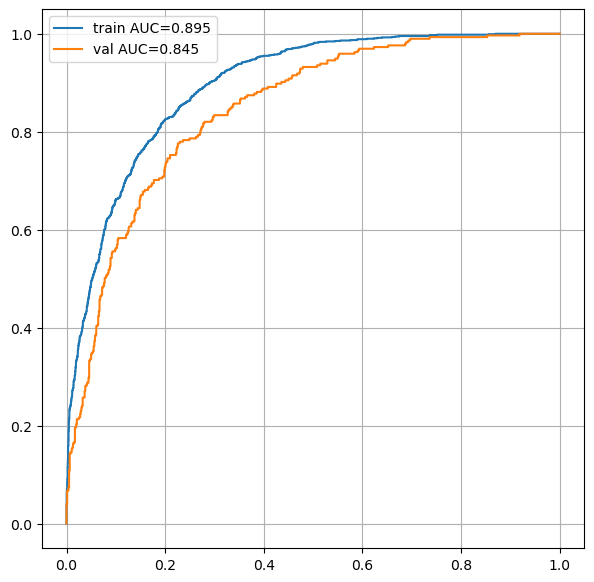

In [96]:
y_train_pred = boost_model_cv.predict_proba(X_train)[:, 1]
y_val_pred = boost_model_cv.predict_proba(X_val)[:, 1]

train_score = roc_auc_score(y_train, y_train_pred)
val_score = roc_auc_score(y_val, y_val_pred)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(*roc_curve(y_train, y_train_pred)[:2], label=f'train AUC={train_score:.3f}')
ax.plot(*roc_curve(y_val, y_val_pred)[:2], label=f'val AUC={val_score:.3f}')
ax.legend()
ax.grid()

Видим, что стандартные параметры дают примерно такой же ROC-AUC. Разве что там гораздо больше деревьев.

# Предсказания

In [34]:
best_model = boost_model

In [35]:
test_data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.40,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.60,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


In [36]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   float64
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [37]:
X_test = test_data # уже исправлены пропуски в данных
submission = pd.read_csv("./submission.csv")

In [38]:
submission.head()

,Id,Churn
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [39]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

y_test_pred = best_model.predict_proba(X_test)[:, 1]

In [40]:
y_test_pred

array([0.04102873, 0.69738124, 0.62161412, ..., 0.85961761, 0.58142721,
       0.00832641])

In [41]:
submission['Churn'] = y_test_pred
submission.to_csv('./my_submission.csv', index=None)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.